In [1]:
import os, gc
import numpy as np
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
from typing import List, Dict
from tqdm.notebook import tqdm

from sklearn.model_selection import KFold

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2
from torch.optim.lr_scheduler import OneCycleLR
from time import time, ctime

from transformers import PatchTSMixerConfig, PatchTSMixerForTimeSeriesClassification

from engine_hms_trainer import (
    seed_everything, gen_non_overlap_samples, calc_entropy, evaluate_oof, get_logger, TARGETS, TARGETS_PRED, Trainer
)
from engine_hms_model import (
    KagglePaths, LocalPaths, ModelConfig
)

from scipy.signal import butter, lfilter, freqz
from scipy.stats import entropy

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PATHS = KagglePaths if os.path.exists(KagglePaths.OUTPUT_DIR) else LocalPaths
print("Output Dir: ", PATHS.OUTPUT_DIR)

EEG_FEAT_ALL = [
    'Fp1', 'F3', 'C3', 'P3', 
    'F7', 'T3', 'T5', 'O1', 
    'Fz', 'Cz', 'Pz', 'Fp2', 
    'F4', 'C4', 'P4', 'F8', 
    'T4', 'T6', 'O2', 'EKG'
    ]

EEG_FEAT_USE =  ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
EEF_FEAT_INDEX = {x:y for x,y in zip(EEG_FEAT_USE, range(len(EEG_FEAT_USE)))}

seed_everything(ModelConfig.SEED)

Output Dir:  ./outputs/


In [3]:
def eeg_from_parquet(parquet_path: str, display: bool = False) -> np.ndarray:
    """
    This function reads a parquet file and extracts the middle 50 seconds of readings. Then it fills NaN values
    with the mean value (ignoring NaNs).
    :param parquet_path: path to parquet file.
    :param display: whether to display EEG plots or not.
    :return data: np.array of shape  (time_steps, eeg_features) -> (10_000, 8)
    """
    # === Extract middle 50 seconds ===
    eeg = pd.read_parquet(parquet_path, columns=EEG_FEAT_USE)
    rows = len(eeg)
    offset = (rows - 10_000) // 2 # 50 * 200 = 10_000
    eeg = eeg.iloc[offset:offset+10_000] # middle 50 seconds, has the same amount of readings to left and right
    if display: 
        plt.figure(figsize=(10,5))
        offset = 0
    # === Convert to numpy ===
    data = np.zeros((10_000, len(EEG_FEAT_USE))) # create placeholder of same shape with zeros
    for index, feature in enumerate(EEG_FEAT_USE):
        x = eeg[feature].values.astype('float32') # convert to float32
        mean = np.nanmean(x) # arithmetic mean along the specified axis, ignoring NaNs
        nan_percentage = np.isnan(x).mean() # percentage of NaN values in feature
        # === Fill nan values ===
        if nan_percentage < 1: # if some values are nan, but not all
            x = np.nan_to_num(x, nan=mean)
        else: # if all values are nan
            x[:] = 0
        data[:, index] = x
        if display: 
            if index != 0:
                offset += x.max()
            plt.plot(range(10_000), x-offset, label=feature)
            offset -= x.min()
    if display:
        plt.legend()
        name = parquet_path.split('/')[-1].split('.')[0]
        plt.yticks([])
        plt.title(f'EEG {name}',size=16)
        plt.show()    
    return data

In [4]:
CREATE_EEGS = False
ALL_EEG_SIGNALS = {}
eeg_paths = list(Path(PATHS.TRAIN_EEGS).glob('*.parquet'))
preload_eegs_path = Path('./inputs/eegs.npy')

if CREATE_EEGS:
    for parquet_path in tqdm(eeg_paths, total=len(eeg_paths)):
        # Save EEG to Python dictionary of numpy arrays
        eeg_id = int(parquet_path.stem)
        eeg_path = str(parquet_path)
        data = eeg_from_parquet(eeg_path, display=eeg_id<1)
        ALL_EEG_SIGNALS[eeg_id] = data

    np.save("./inputs/eegs.npy", ALL_EEG_SIGNALS)
else:
    ALL_EEG_SIGNALS = np.load(preload_eegs_path, allow_pickle=True).item()

In [5]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter(order, [lowcut, highcut], fs=fs, btype='band')
    y = lfilter(b, a, data)
    return y

def denoise_filter(x):
    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 200.0
    lowcut = 1.0
    highcut = 25.0
    
    # Filter a noisy signal.
    T = 50
    nsamples = T * fs
    t = np.arange(0, nsamples) / fs
    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
    y = (y + np.roll(y,-1)+ np.roll(y,-2)+ np.roll(y,-3))/4
    y = y[0:-1:4]
    
    return y

def mu_law_encoding(data, mu):
    mu_x = np.sign(data) * np.log(1 + mu * np.abs(data)) / np.log(mu + 1)
    return mu_x

def mu_law_expansion(data, mu):
    s = np.sign(data) * (np.exp(np.abs(data) * np.log(mu + 1)) - 1) / mu
    return s

def quantize_data(data, classes):
    mu_x = mu_law_encoding(data, classes)
    return mu_x #quantized

def butter_lowpass_filter(data, cutoff_freq=20, sampling_rate=200, order=4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data


In [6]:
class TXMixerDataset(Dataset):
    def __init__(self, df, config, eegs, mode='train', downsample=None):
        self.df = df
        self.config = config
        self.mode = mode
        self.eegs = eegs
        self.downsample = downsample

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        X, y_prob = self.__data_generation(idx)

        if self.downsample is not None:
            X = X[::self.downsample,:]

        return torch.tensor(X, dtype=torch.float32), torch.tensor(y_prob, dtype=torch.float32)
    
    def __data_generation(self, index):
        row = self.df.iloc[index]
        X = np.zeros((10_000, 8), dtype='float32')
        y = np.zeros(6, dtype='float32')
        data = self.eegs[row.eeg_id]

        # === Feature engineering ===
        X[:,0] = data[:,EEF_FEAT_INDEX['Fp1']] - data[:,EEF_FEAT_INDEX['T3']]
        X[:,1] = data[:,EEF_FEAT_INDEX['T3']] - data[:,EEF_FEAT_INDEX['O1']]

        X[:,2] = data[:,EEF_FEAT_INDEX['Fp1']] - data[:,EEF_FEAT_INDEX['C3']]
        X[:,3] = data[:,EEF_FEAT_INDEX['C3']] - data[:,EEF_FEAT_INDEX['O1']]

        X[:,4] = data[:,EEF_FEAT_INDEX['Fp2']] - data[:,EEF_FEAT_INDEX['C4']]
        X[:,5] = data[:,EEF_FEAT_INDEX['C4']] - data[:,EEF_FEAT_INDEX['O2']]

        X[:,6] = data[:,EEF_FEAT_INDEX['Fp2']] - data[:,EEF_FEAT_INDEX['T4']]
        X[:,7] = data[:,EEF_FEAT_INDEX['T4']] - data[:,EEF_FEAT_INDEX['O2']]

        # === Standarize ===
        X = np.clip(X,-1024, 1024)
        X = np.nan_to_num(X, nan=0) / 32.0

        # === Butter Low-pass Filter ===
        X = butter_lowpass_filter(X)

        if self.mode != 'test':
            y_prob = row[TARGETS].values.astype(np.float32)

        return X, y_prob

def pad_collate(batch, max_length=512):
    x = [item[0] for item in batch]
    y = [item[1] for item in batch]

    x_tensor = torch.stack(x, dim=0).unsqueeze(0)
    y_tensor = torch.stack(y, dim=0)

    pad_len = (max_length - x_tensor.size(2)) // 2
    x_pad = F.pad(x_tensor, (0, 0, pad_len, pad_len), mode='constant', value=0).squeeze(0)

    return x_pad, y_tensor

class CustomPatchTSMixer(nn.Module):
    def __init__(self, in_channels=8, num_classes=6):
        super().__init__()

        mixer_config = PatchTSMixerConfig().from_pretrained("ibm/patchtsmixer-etth1-pretrain")
        mixer_config.num_input_channels = in_channels
        mixer_config.num_targets = num_classes

        self.model = PatchTSMixerForTimeSeriesClassification(mixer_config)
    
    def forward(self, x):
        output = self.model(x)
        return output.prediction_outputs


In [7]:
def prepare_k_fold(df, k_folds=5):

    kf = KFold(n_splits=k_folds, shuffle=True, random_state=ModelConfig.SEED)
    unique_spec_id = df['spectrogram_id'].unique()
    df['fold'] = k_folds

    for fold, (train_index, valid_index) in enumerate(kf.split(unique_spec_id)):
        df.loc[df['spectrogram_id'].isin(unique_spec_id[valid_index]), 'fold'] = fold

    return df


def train_fold(model, fold_id, train_folds, valid_folds, logger, stage=1, checkpoint=None):

    train_dataset = TXMixerDataset(train_folds, ModelConfig, ALL_EEG_SIGNALS, mode="train", downsample=20)
    valid_dataset = TXMixerDataset(valid_folds, ModelConfig, ALL_EEG_SIGNALS, mode="valid", downsample=20)

    # ======== DATALOADERS ==========
    loader_kwargs = {
        "batch_size": ModelConfig.BATCH_SIZE,
        "num_workers": ModelConfig.NUM_WORKERS,
        "pin_memory": True,
        "shuffle": False,
    }

    train_loader = DataLoader(train_dataset, drop_last=True, collate_fn=pad_collate, **loader_kwargs)
    valid_loader = DataLoader(valid_dataset, drop_last=False, collate_fn=pad_collate, **loader_kwargs)

    trainer = Trainer(model, ModelConfig, logger)
    best_weights, best_preds, loss_records = trainer.train(
        train_loader, valid_loader, from_checkpoint=checkpoint)

    save_model_name = f"{ModelConfig.MODEL_NAME}_fold_{fold_id}_stage_{stage}.pth"
    torch.save(best_weights, os.path.join(PATHS.OUTPUT_DIR, save_model_name))

    del train_dataset, valid_dataset, train_loader, valid_loader
    torch.cuda.empty_cache()
    gc.collect()

    return best_preds, loss_records

In [8]:
train_csv = pd.read_csv(PATHS.TRAIN_CSV)
targets = train_csv.columns[-6:]

print("targets: ", targets.to_list())

train_csv['entropy'] = train_csv.apply(calc_entropy, axis=1, tgt_list=targets)
train_csv['total_votes'] = train_csv[targets].sum(axis=1)

hard_csv = train_csv[train_csv['entropy'] < ModelConfig.SPLIT_ENTROPY].copy().reset_index(drop=True)

train_all = gen_non_overlap_samples(train_csv, targets)
train_hard = gen_non_overlap_samples(hard_csv, targets)

print("train_all.shape = ", train_all.shape)
print("train_all nan_count: ", train_all.isnull().sum().sum())
display(train_all.head())

print(" ")

print("train_hard.shape = ", train_hard.shape)
print("train_hard nan_count: ", train_hard.isnull().sum().sum())
display(train_hard.head())

targets:  ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
train_all.shape =  (20183, 12)
train_all nan_count:  0


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,patient_id,target
0,568657,0.0,0.000000,0.25,0.000000,0.166667,0.583333,789577333,0.0,16.0,20654,Other
1,582999,0.0,0.857143,0.00,0.071429,0.000000,0.071429,1552638400,0.0,38.0,20230,LPD
2,642382,0.0,0.000000,0.00,0.000000,0.000000,1.000000,14960202,1008.0,1032.0,5955,Other
3,751790,0.0,0.000000,1.00,0.000000,0.000000,0.000000,618728447,908.0,908.0,38549,GPD
4,778705,0.0,0.000000,0.00,0.000000,0.000000,1.000000,52296320,0.0,0.0,40955,Other


 
train_hard.shape =  (6187, 12)
train_hard nan_count:  0


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,patient_id,target
0,568657,0.000000,0.000000,0.250000,0.000000,0.166667,0.583333,789577333,0.0,16.0,20654,Other
1,582999,0.000000,0.857143,0.000000,0.071429,0.000000,0.071429,1552638400,0.0,38.0,20230,LPD
2,1895581,0.076923,0.000000,0.000000,0.000000,0.076923,0.846154,128369999,1138.0,1138.0,47999,Other
3,2482631,0.000000,0.000000,0.133333,0.066667,0.133333,0.666667,978166025,1902.0,1944.0,20606,Other
4,2521897,0.000000,0.000000,0.083333,0.083333,0.333333,0.500000,673742515,0.0,4.0,62117,Other


In [9]:
# # visualize the dataset
# train_dataset = TXMixerDataset(train_all, ModelConfig, ALL_EEG_SIGNALS, mode="train", downsample=20)
# train_loader = DataLoader(train_dataset, drop_last=True, collate_fn=pad_collate, batch_size=16, num_workers=4, pin_memory=True, shuffle=False)

# for batch in train_loader:
#     X, y = batch
#     print(f"X shape: {X.shape}")
#     print(f"y shape: {y.shape}")
#     # for item in range(4):
#     #     plt.figure(figsize=(20,4))
#     #     offset = 0
#     #     for col in range(X.shape[-1]):
#     #         if col != 0:
#     #             offset -= X[item,:,col].min()
#     #         plt.plot(np.arange(X.shape[1]), X[item,:,col]+offset, label=f'feature {col+1}')
#     #         offset += X[item,:,col].max()
#     #     tt = f'{y[col][0]:0.1f}'
#     #     for t in y[col][1:]:
#     #         tt += f', {t:0.1f}'
#     #     plt.title(f'Target = {tt}',size=14)
#     #     plt.legend()
#     #     plt.show()
#     break

In [9]:
ModelConfig.EPOCHS = 15
ModelConfig.BATCH_SIZE = 32
ModelConfig.GRADIENT_ACCUMULATION_STEPS = 1
ModelConfig.MODEL_BACKBONE = 'patchtsmixer'
ModelConfig.MODEL_NAME = "PatchTSMixer"

In [10]:
logger = get_logger(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_train.log")

logger.info(f"{'*' * 100}")
logger.info(f"Script Start: {ctime()}")
logger.info(f"Model Configurations:")
for key, value in ModelConfig.__dict__.items():
    if not key.startswith("__"):
        logger.info(f"{key}: {value}")
logger.info(f"{'*' * 100}")

# ================== Run Training ==================

k_folds = 5
train_all = prepare_k_fold(train_all, k_folds=k_folds)

oof_stage_1, oof_stage_2 = pd.DataFrame(), pd.DataFrame()
loss_history_1, loss_history_2 = [], []

for fold in range(k_folds):
    tik = time()

    model = CustomPatchTSMixer()

    valid_folds = train_all[train_all['fold'] == fold].reset_index(drop=True)
    train_folds = train_all[train_all['fold'] != fold].reset_index(drop=True)

    # STAGE 1
    logger.info(f"{'=' * 100}\nFold: {fold} || Valid size {valid_folds.shape[0]} \n{'=' * 100}")
    logger.info(f"- First Stage -")
    valid_predicts, loss_records = train_fold(
        model, fold, train_folds, valid_folds, logger, stage=1, checkpoint=None)

    loss_history_1.append(loss_records)
    valid_folds[TARGETS_PRED] = valid_predicts
    oof_stage_1 = pd.concat([oof_stage_1, valid_folds], axis=0).reset_index(drop=True)
    kl_loss_torch = evaluate_oof(valid_folds)
    info = f"{'=' * 100}\nFold {fold} Valid Loss: {kl_loss_torch}\n"
    info += f"Elapse: {(time() - tik) / 60:.2f} min \n{'=' * 100}"
    logger.info(info)
    oof_stage_1.to_csv(os.path.join(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_oof_1.csv"), index=False)

    # STAGE 2
    tik = time()
    logger.info(f"- Second Stage -")
    check_point = os.path.join(
        PATHS.OUTPUT_DIR,
        f"{ModelConfig.MODEL_NAME}_fold_{fold}_stage_1.pth"
    )
    logger.info(f"Use Checkpoint: {check_point.split('/')[-1]}")

    model = CustomPatchTSMixer()
    valid_predicts, loss_records = train_fold(
        model, fold, train_hard, valid_folds, logger, stage=2, checkpoint=check_point)

    loss_history_2.append(loss_records)
    valid_folds[TARGETS_PRED] = valid_predicts
    oof_stage_2 = pd.concat([oof_stage_2, valid_folds], axis=0).reset_index(drop=True)
    kl_loss_torch = evaluate_oof(valid_folds)
    info = f"{'=' * 100}\nFold {fold} Valid Loss: {kl_loss_torch}\n"
    info += f"Elapse: {(time() - tik) / 60:.2f} min \n{'=' * 100}"
    logger.info(info)
    oof_stage_2.to_csv(os.path.join(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_oof_2.csv"), index=False)

****************************************************************************************************
Script Start: Mon Mar 25 01:44:22 2024
Model Configurations:
SEED: 20
SPLIT_ENTROPY: 5.5
MODEL_NAME: PatchTSMixer
MODEL_BACKBONE: patchtsmixer
BATCH_SIZE: 32
EPOCHS: 15
GRADIENT_ACCUMULATION_STEPS: 1
DROP_RATE: 0.15
DROP_PATH_RATE: 0.25
WEIGHT_DECAY: 0.01
REGULARIZATION: None
USE_KAGGLE_SPECTROGRAMS: True
USE_EEG_SPECTROGRAMS: True
AMP: True
AUGMENT: False
AUGMENTATIONS: ['h_flip', 'v_flip', 'xy_masking', 'cutmix']
PRINT_FREQ: 50
FREEZE: False
NUM_FROZEN_LAYERS: 0
NUM_WORKERS: 0
MAX_GRAD_NORM: 10000000.0
DUAL_ENCODER_BACKBONE: tf_efficientnet_b2
MAE_PRETRAINED_WEIGHTS: facebook/vit-mae-base
MAE_HIDDEN_DROPOUT_PROB: 0.05
MAE_ATTENTION_DROPOUT_PROB: 0.05
****************************************************************************************************
Fold: 0 || Valid size 3988 
- First Stage -


Train [0]:   0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 1 [0/506] | Train Loss: 1.4880 Grad: 190778.8750 LR: 4.0004e-06 | Elapse: 0.36s
Epoch 1 [50/506] | Train Loss: 1.4160 Grad: 129359.8125 LR: 5.0683e-06 | Elapse: 2.87s
Epoch 1 [100/506] | Train Loss: 1.3903 Grad: 278513.3438 LR: 8.1444e-06 | Elapse: 5.32s
Epoch 1 [150/506] | Train Loss: 1.3843 Grad: 175436.3750 LR: 1.3097e-05 | Elapse: 7.76s
Epoch 1 [200/506] | Train Loss: 1.3781 Grad: 192201.6719 LR: 1.9715e-05 | Elapse: 10.20s
Epoch 1 [250/506] | Train Loss: 1.3654 Grad: 137501.9844 LR: 2.7713e-05 | Elapse: 12.69s
Epoch 1 [300/506] | Train Loss: 1.3548 Grad: 110536.7734 LR: 3.6752e-05 | Elapse: 15.15s
Epoch 1 [350/506] | Train Loss: 1.3472 Grad: 140179.0156 LR: 4.6442e-05 | Elapse: 17.66s
Epoch 1 [400/506] | Train Loss: 1.3398 Grad: 126895.2500 LR: 5.6371e-05 | Elapse: 20.14s
Epoch 1 [450/506] | Train Loss: 1.3313 Grad: 107270.7031 LR: 6.6112e-05 | Elapse: 22.62s
Epoch 1 [500/506] | Train Loss: 1.3247 Grad: 102964.9531 LR: 7.5250e-05 | Elapse: 25.12s
Epoch 1 [505/506] | Train Lo

Valid [0]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 1 [0/125] | Valid Loss: 1.2169 | Elapse: 0.05s
Epoch 1 [50/125] | Valid Loss: 1.2824 | Elapse: 2.17s
Epoch 1 [100/125] | Valid Loss: 1.2750 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 1.3241; (valid) 1.2693 | Time: 30.67s
Best model found in epoch 1 | valid loss: 1.2693


Epoch 1 [124/125] | Valid Loss: 1.2693 | Elapse: 5.30s


Train [1]:   0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 2 [0/506] | Train Loss: 1.3835 Grad: 117209.8125 LR: 7.6287e-05 | Elapse: 0.05s
Epoch 2 [50/506] | Train Loss: 1.2770 Grad: 49754.9297 LR: 8.4285e-05 | Elapse: 2.52s
Epoch 2 [100/506] | Train Loss: 1.2620 Grad: 139432.8438 LR: 9.0903e-05 | Elapse: 4.98s
Epoch 2 [150/506] | Train Loss: 1.2720 Grad: 57364.9219 LR: 9.5856e-05 | Elapse: 7.47s
Epoch 2 [200/506] | Train Loss: 1.2735 Grad: 72708.0000 LR: 9.8932e-05 | Elapse: 9.95s
Epoch 2 [250/506] | Train Loss: 1.2716 Grad: 55497.4727 LR: 1.0000e-04 | Elapse: 12.41s
Epoch 2 [300/506] | Train Loss: 1.2676 Grad: 41522.7188 LR: 9.9987e-05 | Elapse: 14.89s
Epoch 2 [350/506] | Train Loss: 1.2662 Grad: 55308.4375 LR: 9.9948e-05 | Elapse: 17.36s
Epoch 2 [400/506] | Train Loss: 1.2614 Grad: 51483.2148 LR: 9.9883e-05 | Elapse: 19.86s
Epoch 2 [450/506] | Train Loss: 1.2560 Grad: 43121.4570 LR: 9.9791e-05 | Elapse: 22.36s
Epoch 2 [500/506] | Train Loss: 1.2527 Grad: 49652.2734 LR: 9.9673e-05 | Elapse: 24.87s
Epoch 2 [505/506] | Train Loss: 1.2522

Valid [1]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 2 [0/125] | Valid Loss: 1.1469 | Elapse: 0.05s
Epoch 2 [50/125] | Valid Loss: 1.2254 | Elapse: 2.18s
Epoch 2 [100/125] | Valid Loss: 1.2240 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 1.2522; (valid) 1.2184 | Time: 30.43s
Best model found in epoch 2 | valid loss: 1.2184


Epoch 2 [124/125] | Valid Loss: 1.2184 | Elapse: 5.31s


Train [2]:   0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 3 [0/506] | Train Loss: 1.3168 Grad: 106155.5156 LR: 9.9657e-05 | Elapse: 0.05s
Epoch 3 [50/506] | Train Loss: 1.2307 Grad: 86217.9922 LR: 9.9509e-05 | Elapse: 2.51s
Epoch 3 [100/506] | Train Loss: 1.2106 Grad: 263161.0000 LR: 9.9335e-05 | Elapse: 4.98s
Epoch 3 [150/506] | Train Loss: 1.2203 Grad: 98713.9141 LR: 9.9136e-05 | Elapse: 7.49s
Epoch 3 [200/506] | Train Loss: 1.2222 Grad: 132473.0781 LR: 9.8910e-05 | Elapse: 9.97s
Epoch 3 [250/506] | Train Loss: 1.2208 Grad: 108710.2344 LR: 9.8658e-05 | Elapse: 12.46s
Epoch 3 [300/506] | Train Loss: 1.2171 Grad: 87815.4141 LR: 9.8381e-05 | Elapse: 14.93s
Epoch 3 [350/506] | Train Loss: 1.2149 Grad: 110115.3125 LR: 9.8078e-05 | Elapse: 17.41s
Epoch 3 [400/506] | Train Loss: 1.2119 Grad: 99427.1797 LR: 9.7749e-05 | Elapse: 19.88s
Epoch 3 [450/506] | Train Loss: 1.2072 Grad: 99881.3750 LR: 9.7396e-05 | Elapse: 22.38s
Epoch 3 [500/506] | Train Loss: 1.2040 Grad: 91163.2969 LR: 9.7017e-05 | Elapse: 24.87s
Epoch 3 [505/506] | Train Loss: 1.2

Valid [2]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 3 [0/125] | Valid Loss: 1.0755 | Elapse: 0.05s
Epoch 3 [50/125] | Valid Loss: 1.1727 | Elapse: 2.19s
Epoch 3 [100/125] | Valid Loss: 1.1773 | Elapse: 4.32s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 1.2033; (valid) 1.1714 | Time: 30.44s
Best model found in epoch 3 | valid loss: 1.1714


Epoch 3 [124/125] | Valid Loss: 1.1714 | Elapse: 5.32s


Train [3]:   0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 4 [0/506] | Train Loss: 1.2412 Grad: 113001.6328 LR: 9.6970e-05 | Elapse: 0.05s
Epoch 4 [50/506] | Train Loss: 1.1863 Grad: 91643.9141 LR: 9.6564e-05 | Elapse: 2.56s
Epoch 4 [100/506] | Train Loss: 1.1723 Grad: 278655.5000 LR: 9.6133e-05 | Elapse: 5.04s
Epoch 4 [150/506] | Train Loss: 1.1846 Grad: 109110.0703 LR: 9.5677e-05 | Elapse: 7.54s
Epoch 4 [200/506] | Train Loss: 1.1841 Grad: 138244.1250 LR: 9.5198e-05 | Elapse: 10.01s
Epoch 4 [250/506] | Train Loss: 1.1793 Grad: 110430.2266 LR: 9.4694e-05 | Elapse: 12.48s
Epoch 4 [300/506] | Train Loss: 1.1765 Grad: 93045.2188 LR: 9.4167e-05 | Elapse: 14.99s
Epoch 4 [350/506] | Train Loss: 1.1750 Grad: 103860.5312 LR: 9.3617e-05 | Elapse: 17.50s
Epoch 4 [400/506] | Train Loss: 1.1726 Grad: 97734.0781 LR: 9.3043e-05 | Elapse: 19.99s
Epoch 4 [450/506] | Train Loss: 1.1682 Grad: 90680.6719 LR: 9.2447e-05 | Elapse: 22.48s
Epoch 4 [500/506] | Train Loss: 1.1664 Grad: 88763.0391 LR: 9.1828e-05 | Elapse: 24.95s
Epoch 4 [505/506] | Train Loss: 1

Valid [3]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 4 [0/125] | Valid Loss: 1.0213 | Elapse: 0.05s
Epoch 4 [50/125] | Valid Loss: 1.1362 | Elapse: 2.18s
Epoch 4 [100/125] | Valid Loss: 1.1447 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 1.1656; (valid) 1.1390 | Time: 30.50s
Best model found in epoch 4 | valid loss: 1.1390


Epoch 4 [124/125] | Valid Loss: 1.1390 | Elapse: 5.30s


Train [4]:   0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 5 [0/506] | Train Loss: 1.1904 Grad: 105793.7734 LR: 9.1752e-05 | Elapse: 0.05s
Epoch 5 [50/506] | Train Loss: 1.1504 Grad: 98890.1484 LR: 9.1109e-05 | Elapse: 2.51s
Epoch 5 [100/506] | Train Loss: 1.1364 Grad: 276307.0000 LR: 9.0444e-05 | Elapse: 4.95s
Epoch 5 [150/506] | Train Loss: 1.1506 Grad: 108126.3359 LR: 8.9757e-05 | Elapse: 7.42s
Epoch 5 [200/506] | Train Loss: 1.1519 Grad: 137206.8594 LR: 8.9050e-05 | Elapse: 9.92s
Epoch 5 [250/506] | Train Loss: 1.1494 Grad: 112649.9688 LR: 8.8322e-05 | Elapse: 12.40s
Epoch 5 [300/506] | Train Loss: 1.1477 Grad: 91586.2109 LR: 8.7573e-05 | Elapse: 14.87s
Epoch 5 [350/506] | Train Loss: 1.1468 Grad: 108630.4297 LR: 8.6805e-05 | Elapse: 17.35s
Epoch 5 [400/506] | Train Loss: 1.1452 Grad: 100781.0625 LR: 8.6017e-05 | Elapse: 19.86s
Epoch 5 [450/506] | Train Loss: 1.1411 Grad: 96666.4609 LR: 8.5211e-05 | Elapse: 22.36s
Epoch 5 [500/506] | Train Loss: 1.1406 Grad: 100286.3359 LR: 8.4385e-05 | Elapse: 24.80s
Epoch 5 [505/506] | Train Loss: 

Valid [4]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 5 [0/125] | Valid Loss: 0.9971 | Elapse: 0.05s
Epoch 5 [50/125] | Valid Loss: 1.1150 | Elapse: 2.17s
Epoch 5 [100/125] | Valid Loss: 1.1254 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 1.1399; (valid) 1.1202 | Time: 30.36s
Best model found in epoch 5 | valid loss: 1.1202


Epoch 5 [124/125] | Valid Loss: 1.1202 | Elapse: 5.32s


Train [5]:   0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 6 [0/506] | Train Loss: 1.1399 Grad: 98482.9922 LR: 8.4285e-05 | Elapse: 0.06s
Epoch 6 [50/506] | Train Loss: 1.1245 Grad: 94553.7109 LR: 8.3439e-05 | Elapse: 2.56s
Epoch 6 [100/506] | Train Loss: 1.1145 Grad: 278514.1250 LR: 8.2576e-05 | Elapse: 5.04s
Epoch 6 [150/506] | Train Loss: 1.1315 Grad: 104578.8906 LR: 8.1695e-05 | Elapse: 7.51s
Epoch 6 [200/506] | Train Loss: 1.1348 Grad: 131375.5312 LR: 8.0798e-05 | Elapse: 10.01s
Epoch 6 [250/506] | Train Loss: 1.1311 Grad: 109764.8906 LR: 7.9884e-05 | Elapse: 12.48s
Epoch 6 [300/506] | Train Loss: 1.1309 Grad: 93172.5000 LR: 7.8955e-05 | Elapse: 14.97s
Epoch 6 [350/506] | Train Loss: 1.1300 Grad: 107908.1953 LR: 7.8010e-05 | Elapse: 17.48s
Epoch 6 [400/506] | Train Loss: 1.1285 Grad: 90174.3281 LR: 7.7051e-05 | Elapse: 19.97s
Epoch 6 [450/506] | Train Loss: 1.1241 Grad: 90139.9766 LR: 7.6077e-05 | Elapse: 22.46s
Epoch 6 [500/506] | Train Loss: 1.1236 Grad: 89802.7109 LR: 7.5090e-05 | Elapse: 24.97s
Epoch 6 [505/506] | Train Loss: 1.

Valid [5]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 6 [0/125] | Valid Loss: 0.9789 | Elapse: 0.05s
Epoch 6 [50/125] | Valid Loss: 1.1026 | Elapse: 2.17s
Epoch 6 [100/125] | Valid Loss: 1.1141 | Elapse: 4.29s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 1.1230; (valid) 1.1093 | Time: 30.50s
Best model found in epoch 6 | valid loss: 1.1093


Epoch 6 [124/125] | Valid Loss: 1.1093 | Elapse: 5.29s


Train [6]:   0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 7 [0/506] | Train Loss: 1.0731 Grad: 104712.8516 LR: 7.4970e-05 | Elapse: 0.05s
Epoch 7 [50/506] | Train Loss: 1.1081 Grad: 98395.3516 LR: 7.3968e-05 | Elapse: 2.55s
Epoch 7 [100/506] | Train Loss: 1.0967 Grad: 272880.3750 LR: 7.2953e-05 | Elapse: 5.06s
Epoch 7 [150/506] | Train Loss: 1.1127 Grad: 105172.1250 LR: 7.1926e-05 | Elapse: 7.53s
Epoch 7 [200/506] | Train Loss: 1.1171 Grad: 130225.7031 LR: 7.0887e-05 | Elapse: 10.02s
Epoch 7 [250/506] | Train Loss: 1.1139 Grad: 117463.8750 LR: 6.9837e-05 | Elapse: 12.52s
Epoch 7 [300/506] | Train Loss: 1.1153 Grad: 91932.1328 LR: 6.8777e-05 | Elapse: 15.00s
Epoch 7 [350/506] | Train Loss: 1.1141 Grad: 105893.3516 LR: 6.7707e-05 | Elapse: 17.49s
Epoch 7 [400/506] | Train Loss: 1.1137 Grad: 96847.9688 LR: 6.6627e-05 | Elapse: 19.95s
Epoch 7 [450/506] | Train Loss: 1.1103 Grad: 91939.3828 LR: 6.5539e-05 | Elapse: 22.43s
Epoch 7 [500/506] | Train Loss: 1.1104 Grad: 95329.3438 LR: 6.4442e-05 | Elapse: 24.91s
Epoch 7 [505/506] | Train Loss: 1

Valid [6]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 7 [0/125] | Valid Loss: 0.9670 | Elapse: 0.05s
Epoch 7 [50/125] | Valid Loss: 1.0913 | Elapse: 2.17s
Epoch 7 [100/125] | Valid Loss: 1.1034 | Elapse: 4.29s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 1.1099; (valid) 1.0990 | Time: 30.47s
Best model found in epoch 7 | valid loss: 1.0990


Epoch 7 [124/125] | Valid Loss: 1.0990 | Elapse: 5.29s


Train [7]:   0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 8 [0/506] | Train Loss: 1.1416 Grad: 112509.0234 LR: 6.4310e-05 | Elapse: 0.05s
Epoch 8 [50/506] | Train Loss: 1.0978 Grad: 101164.1250 LR: 6.3205e-05 | Elapse: 2.53s
Epoch 8 [100/506] | Train Loss: 1.0871 Grad: 273463.9688 LR: 6.2093e-05 | Elapse: 5.01s
Epoch 8 [150/506] | Train Loss: 1.1037 Grad: 107042.3672 LR: 6.0975e-05 | Elapse: 7.50s
Epoch 8 [200/506] | Train Loss: 1.1075 Grad: 136095.2969 LR: 5.9851e-05 | Elapse: 9.98s
Epoch 8 [250/506] | Train Loss: 1.1043 Grad: 114429.8203 LR: 5.8722e-05 | Elapse: 12.47s
Epoch 8 [300/506] | Train Loss: 1.1058 Grad: 101987.2969 LR: 5.7588e-05 | Elapse: 14.96s
Epoch 8 [350/506] | Train Loss: 1.1047 Grad: 106712.4453 LR: 5.6450e-05 | Elapse: 17.43s
Epoch 8 [400/506] | Train Loss: 1.1050 Grad: 96740.4688 LR: 5.5308e-05 | Elapse: 19.91s
Epoch 8 [450/506] | Train Loss: 1.1020 Grad: 84710.6094 LR: 5.4164e-05 | Elapse: 22.38s
Epoch 8 [500/506] | Train Loss: 1.1033 Grad: 90951.5391 LR: 5.3018e-05 | Elapse: 24.86s
Epoch 8 [505/506] | Train Loss: 

Valid [7]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 8 [0/125] | Valid Loss: 0.9627 | Elapse: 0.05s
Epoch 8 [50/125] | Valid Loss: 1.0834 | Elapse: 2.17s
Epoch 8 [100/125] | Valid Loss: 1.0956 | Elapse: 4.28s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 1.1031; (valid) 1.0914 | Time: 30.40s
Best model found in epoch 8 | valid loss: 1.0914


Epoch 8 [124/125] | Valid Loss: 1.0914 | Elapse: 5.28s


Train [8]:   0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 9 [0/506] | Train Loss: 1.1868 Grad: 109120.5469 LR: 5.2880e-05 | Elapse: 0.05s
Epoch 9 [50/506] | Train Loss: 1.0914 Grad: 104675.2812 LR: 5.1732e-05 | Elapse: 2.53s
Epoch 9 [100/506] | Train Loss: 1.0826 Grad: 269122.6250 LR: 5.0583e-05 | Elapse: 5.02s
Epoch 9 [150/506] | Train Loss: 1.0996 Grad: 106239.3672 LR: 4.9434e-05 | Elapse: 7.51s
Epoch 9 [200/506] | Train Loss: 1.1046 Grad: 126506.3828 LR: 4.8285e-05 | Elapse: 10.00s
Epoch 9 [250/506] | Train Loss: 1.1022 Grad: 113312.6484 LR: 4.7137e-05 | Elapse: 12.50s
Epoch 9 [300/506] | Train Loss: 1.1019 Grad: 99682.7656 LR: 4.5990e-05 | Elapse: 15.00s
Epoch 9 [350/506] | Train Loss: 1.0996 Grad: 108161.8594 LR: 4.4846e-05 | Elapse: 17.48s
Epoch 9 [400/506] | Train Loss: 1.0985 Grad: 96749.9219 LR: 4.3704e-05 | Elapse: 19.95s
Epoch 9 [450/506] | Train Loss: 1.0953 Grad: 96754.1172 LR: 4.2566e-05 | Elapse: 22.45s
Epoch 9 [500/506] | Train Loss: 1.0963 Grad: 81940.8906 LR: 4.1432e-05 | Elapse: 24.94s
Epoch 9 [505/506] | Train Loss: 

Valid [8]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 9 [0/125] | Valid Loss: 0.9568 | Elapse: 0.06s
Epoch 9 [50/125] | Valid Loss: 1.0787 | Elapse: 2.18s
Epoch 9 [100/125] | Valid Loss: 1.0914 | Elapse: 4.29s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 1.0960; (valid) 1.0874 | Time: 30.49s
Best model found in epoch 9 | valid loss: 1.0874


Epoch 9 [124/125] | Valid Loss: 1.0874 | Elapse: 5.30s


Train [9]:   0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 10 [0/506] | Train Loss: 1.0981 Grad: 112546.0078 LR: 4.1296e-05 | Elapse: 0.05s
Epoch 10 [50/506] | Train Loss: 1.0751 Grad: 104666.5781 LR: 4.0167e-05 | Elapse: 2.54s
Epoch 10 [100/506] | Train Loss: 1.0697 Grad: 258125.0156 LR: 3.9043e-05 | Elapse: 4.96s
Epoch 10 [150/506] | Train Loss: 1.0857 Grad: 102926.1797 LR: 3.7924e-05 | Elapse: 7.41s
Epoch 10 [200/506] | Train Loss: 1.0908 Grad: 137986.3594 LR: 3.6812e-05 | Elapse: 9.85s
Epoch 10 [250/506] | Train Loss: 1.0908 Grad: 104967.3594 LR: 3.5708e-05 | Elapse: 12.30s
Epoch 10 [300/506] | Train Loss: 1.0921 Grad: 97394.4531 LR: 3.4610e-05 | Elapse: 14.77s
Epoch 10 [350/506] | Train Loss: 1.0909 Grad: 111852.8125 LR: 3.3521e-05 | Elapse: 17.22s
Epoch 10 [400/506] | Train Loss: 1.0917 Grad: 93830.7109 LR: 3.2441e-05 | Elapse: 19.71s
Epoch 10 [450/506] | Train Loss: 1.0877 Grad: 95181.0000 LR: 3.1370e-05 | Elapse: 22.19s
Epoch 10 [500/506] | Train Loss: 1.0885 Grad: 96660.8594 LR: 3.0308e-05 | Elapse: 24.70s
Epoch 10 [505/506] | T

Valid [9]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 10 [0/125] | Valid Loss: 0.9531 | Elapse: 0.05s
Epoch 10 [50/125] | Valid Loss: 1.0746 | Elapse: 2.16s
Epoch 10 [100/125] | Valid Loss: 1.0874 | Elapse: 4.28s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 1.0878; (valid) 1.0837 | Time: 30.22s
Best model found in epoch 10 | valid loss: 1.0837


Epoch 10 [124/125] | Valid Loss: 1.0837 | Elapse: 5.28s


Train [10]:   0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 11 [0/506] | Train Loss: 1.0344 Grad: 107905.2891 LR: 3.0182e-05 | Elapse: 0.05s
Epoch 11 [50/506] | Train Loss: 1.0704 Grad: 107584.2656 LR: 2.9132e-05 | Elapse: 2.52s
Epoch 11 [100/506] | Train Loss: 1.0667 Grad: 280257.9688 LR: 2.8094e-05 | Elapse: 5.00s
Epoch 11 [150/506] | Train Loss: 1.0863 Grad: 103111.8672 LR: 2.7067e-05 | Elapse: 7.48s
Epoch 11 [200/506] | Train Loss: 1.0909 Grad: 122162.8203 LR: 2.6052e-05 | Elapse: 9.96s
Epoch 11 [250/506] | Train Loss: 1.0883 Grad: 111105.7109 LR: 2.5050e-05 | Elapse: 12.44s
Epoch 11 [300/506] | Train Loss: 1.0886 Grad: 94076.7656 LR: 2.4061e-05 | Elapse: 14.93s
Epoch 11 [350/506] | Train Loss: 1.0878 Grad: 101340.1484 LR: 2.3086e-05 | Elapse: 17.42s
Epoch 11 [400/506] | Train Loss: 1.0883 Grad: 97958.3125 LR: 2.2125e-05 | Elapse: 19.92s
Epoch 11 [450/506] | Train Loss: 1.0848 Grad: 97675.5156 LR: 2.1179e-05 | Elapse: 22.42s
Epoch 11 [500/506] | Train Loss: 1.0849 Grad: 91515.8203 LR: 2.0248e-05 | Elapse: 24.92s
Epoch 11 [505/506] | T

Valid [10]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 11 [0/125] | Valid Loss: 0.9497 | Elapse: 0.05s
Epoch 11 [50/125] | Valid Loss: 1.0730 | Elapse: 2.17s
Epoch 11 [100/125] | Valid Loss: 1.0855 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 11 - Average Loss: (train) 1.0843; (valid) 1.0821 | Time: 30.47s
Best model found in epoch 11 | valid loss: 1.0821


Epoch 11 [124/125] | Valid Loss: 1.0821 | Elapse: 5.30s


Train [11]:   0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 12 [0/506] | Train Loss: 1.1108 Grad: 114189.6953 LR: 2.0137e-05 | Elapse: 0.05s
Epoch 12 [50/506] | Train Loss: 1.0717 Grad: 114662.6797 LR: 1.9224e-05 | Elapse: 2.54s
Epoch 12 [100/506] | Train Loss: 1.0614 Grad: 269482.5000 LR: 1.8327e-05 | Elapse: 5.01s
Epoch 12 [150/506] | Train Loss: 1.0769 Grad: 106199.1797 LR: 1.7447e-05 | Elapse: 7.50s
Epoch 12 [200/506] | Train Loss: 1.0850 Grad: 139828.0000 LR: 1.6584e-05 | Elapse: 10.02s
Epoch 12 [250/506] | Train Loss: 1.0817 Grad: 113112.1484 LR: 1.5738e-05 | Elapse: 12.49s
Epoch 12 [300/506] | Train Loss: 1.0847 Grad: 100062.1328 LR: 1.4911e-05 | Elapse: 14.95s
Epoch 12 [350/506] | Train Loss: 1.0834 Grad: 105796.6328 LR: 1.4103e-05 | Elapse: 17.42s
Epoch 12 [400/506] | Train Loss: 1.0860 Grad: 98991.7656 LR: 1.3313e-05 | Elapse: 19.92s
Epoch 12 [450/506] | Train Loss: 1.0831 Grad: 94733.4531 LR: 1.2543e-05 | Elapse: 22.36s
Epoch 12 [500/506] | Train Loss: 1.0841 Grad: 91099.1797 LR: 1.1792e-05 | Elapse: 24.85s
Epoch 12 [505/506] |

Valid [11]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 12 [0/125] | Valid Loss: 0.9481 | Elapse: 0.05s
Epoch 12 [50/125] | Valid Loss: 1.0721 | Elapse: 2.19s
Epoch 12 [100/125] | Valid Loss: 1.0844 | Elapse: 4.32s


----------------------------------------------------------------------------------------------------
Epoch 12 - Average Loss: (train) 1.0838; (valid) 1.0812 | Time: 30.43s
Best model found in epoch 12 | valid loss: 1.0812


Epoch 12 [124/125] | Valid Loss: 1.0812 | Elapse: 5.33s


Train [12]:   0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 13 [0/506] | Train Loss: 1.1189 Grad: 116606.1953 LR: 1.1704e-05 | Elapse: 0.05s
Epoch 13 [50/506] | Train Loss: 1.0655 Grad: 110162.4297 LR: 1.0976e-05 | Elapse: 2.52s
Epoch 13 [100/506] | Train Loss: 1.0556 Grad: 285432.9375 LR: 1.0269e-05 | Elapse: 5.01s
Epoch 13 [150/506] | Train Loss: 1.0726 Grad: 115482.8594 LR: 9.5826e-06 | Elapse: 7.47s
Epoch 13 [200/506] | Train Loss: 1.0821 Grad: 133667.6875 LR: 8.9179e-06 | Elapse: 9.96s
Epoch 13 [250/506] | Train Loss: 1.0803 Grad: 124640.6953 LR: 8.2750e-06 | Elapse: 12.44s
Epoch 13 [300/506] | Train Loss: 1.0825 Grad: 96287.4453 LR: 7.6541e-06 | Elapse: 14.93s
Epoch 13 [350/506] | Train Loss: 1.0819 Grad: 101277.2422 LR: 7.0556e-06 | Elapse: 17.38s
Epoch 13 [400/506] | Train Loss: 1.0833 Grad: 96250.9766 LR: 6.4798e-06 | Elapse: 19.86s
Epoch 13 [450/506] | Train Loss: 1.0806 Grad: 93803.1172 LR: 5.9270e-06 | Elapse: 22.36s
Epoch 13 [500/506] | Train Loss: 1.0813 Grad: 95741.2656 LR: 5.3976e-06 | Elapse: 24.84s
Epoch 13 [505/506] | T

Valid [12]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 13 [0/125] | Valid Loss: 0.9476 | Elapse: 0.05s
Epoch 13 [50/125] | Valid Loss: 1.0709 | Elapse: 2.17s
Epoch 13 [100/125] | Valid Loss: 1.0834 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 13 - Average Loss: (train) 1.0810; (valid) 1.0802 | Time: 30.40s
Best model found in epoch 13 | valid loss: 1.0802


Epoch 13 [124/125] | Valid Loss: 1.0802 | Elapse: 5.31s


Train [13]:   0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 14 [0/506] | Train Loss: 1.0962 Grad: 112885.6875 LR: 5.3356e-06 | Elapse: 0.05s
Epoch 14 [50/506] | Train Loss: 1.0706 Grad: 110068.3125 LR: 4.8326e-06 | Elapse: 2.58s
Epoch 14 [100/506] | Train Loss: 1.0631 Grad: 269757.4062 LR: 4.3535e-06 | Elapse: 5.07s
Epoch 14 [150/506] | Train Loss: 1.0807 Grad: 111450.5234 LR: 3.8986e-06 | Elapse: 7.55s
Epoch 14 [200/506] | Train Loss: 1.0855 Grad: 131361.6719 LR: 3.4680e-06 | Elapse: 10.00s
Epoch 14 [250/506] | Train Loss: 1.0829 Grad: 115369.5703 LR: 3.0620e-06 | Elapse: 12.49s
Epoch 14 [300/506] | Train Loss: 1.0826 Grad: 99865.9844 LR: 2.6809e-06 | Elapse: 14.98s
Epoch 14 [350/506] | Train Loss: 1.0822 Grad: 104957.5625 LR: 2.3248e-06 | Elapse: 17.46s
Epoch 14 [400/506] | Train Loss: 1.0817 Grad: 100370.2734 LR: 1.9939e-06 | Elapse: 19.97s
Epoch 14 [450/506] | Train Loss: 1.0787 Grad: 91574.1328 LR: 1.6884e-06 | Elapse: 22.46s
Epoch 14 [500/506] | Train Loss: 1.0795 Grad: 90444.2969 LR: 1.4085e-06 | Elapse: 24.95s
Epoch 14 [505/506] |

Valid [13]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 14 [0/125] | Valid Loss: 0.9476 | Elapse: 0.05s
Epoch 14 [50/125] | Valid Loss: 1.0707 | Elapse: 2.17s
Epoch 14 [100/125] | Valid Loss: 1.0832 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 14 - Average Loss: (train) 1.0790; (valid) 1.0800 | Time: 30.51s
Best model found in epoch 14 | valid loss: 1.0800


Epoch 14 [124/125] | Valid Loss: 1.0800 | Elapse: 5.30s


Train [14]:   0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 15 [0/506] | Train Loss: 1.1193 Grad: 117731.4766 LR: 1.3766e-06 | Elapse: 0.05s
Epoch 15 [50/506] | Train Loss: 1.0685 Grad: 97041.6562 LR: 1.1255e-06 | Elapse: 2.49s
Epoch 15 [100/506] | Train Loss: 1.0600 Grad: 263783.1250 LR: 9.0022e-07 | Elapse: 4.99s
Epoch 15 [150/506] | Train Loss: 1.0778 Grad: 110977.2344 LR: 7.0091e-07 | Elapse: 7.50s
Epoch 15 [200/506] | Train Loss: 1.0846 Grad: 134374.2812 LR: 5.2768e-07 | Elapse: 9.94s
Epoch 15 [250/506] | Train Loss: 1.0832 Grad: 114642.9688 LR: 3.8062e-07 | Elapse: 12.39s
Epoch 15 [300/506] | Train Loss: 1.0857 Grad: 103641.6094 LR: 2.5981e-07 | Elapse: 14.83s
Epoch 15 [350/506] | Train Loss: 1.0837 Grad: 102026.9062 LR: 1.6530e-07 | Elapse: 17.27s
Epoch 15 [400/506] | Train Loss: 1.0839 Grad: 108504.2891 LR: 9.7159e-08 | Elapse: 19.72s
Epoch 15 [450/506] | Train Loss: 1.0808 Grad: 94029.0234 LR: 5.5412e-08 | Elapse: 22.14s
Epoch 15 [500/506] | Train Loss: 1.0815 Grad: 92557.7578 LR: 4.0085e-08 | Elapse: 24.59s
Epoch 15 [505/506] | 

Valid [14]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 15 [0/125] | Valid Loss: 0.9477 | Elapse: 0.05s
Epoch 15 [50/125] | Valid Loss: 1.0707 | Elapse: 2.17s
Epoch 15 [100/125] | Valid Loss: 1.0832 | Elapse: 4.29s


----------------------------------------------------------------------------------------------------
Epoch 15 - Average Loss: (train) 1.0812; (valid) 1.0799 | Time: 30.14s
Best model found in epoch 15 | valid loss: 1.0799
Fold 0 Valid Loss: 1.079906702041626
Elapse: 7.63 min 
- Second Stage -
Use Checkpoint: PatchTSMixer_fold_0_stage_1.pth


Epoch 15 [124/125] | Valid Loss: 1.0799 | Elapse: 5.29s


Train [0]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 1 [0/193] | Train Loss: 0.6391 Grad: 76600.3281 LR: 4.0028e-06 | Elapse: 0.05s
Epoch 1 [50/193] | Train Loss: 0.7392 Grad: 94226.9141 LR: 1.1214e-05 | Elapse: 2.51s
Epoch 1 [100/193] | Train Loss: 0.7361 Grad: 88451.0859 LR: 3.0220e-05 | Elapse: 4.96s
Epoch 1 [150/193] | Train Loss: 0.7339 Grad: 64030.9414 LR: 5.5525e-05 | Elapse: 7.42s
Epoch 1 [192/193] | Train Loss: 0.7252 Grad: 84486.8672 LR: 7.6301e-05 | Elapse: 9.49s


Valid [0]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 1 [0/125] | Valid Loss: 1.0036 | Elapse: 0.05s
Epoch 1 [50/125] | Valid Loss: 1.1186 | Elapse: 2.17s
Epoch 1 [100/125] | Valid Loss: 1.1323 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.7252; (valid) 1.1263 | Time: 14.80s
Best model found in epoch 1 | valid loss: 1.1263


Epoch 1 [124/125] | Valid Loss: 1.1263 | Elapse: 5.30s


Train [1]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 2 [0/193] | Train Loss: 0.6056 Grad: 61545.0625 LR: 7.6750e-05 | Elapse: 0.05s
Epoch 2 [50/193] | Train Loss: 0.6959 Grad: 84228.6875 LR: 9.4474e-05 | Elapse: 2.55s
Epoch 2 [100/193] | Train Loss: 0.6956 Grad: 78304.3828 LR: 9.9999e-05 | Elapse: 5.03s
Epoch 2 [150/193] | Train Loss: 0.6979 Grad: 57129.2891 LR: 9.9888e-05 | Elapse: 7.50s
Epoch 2 [192/193] | Train Loss: 0.6953 Grad: 76106.4375 LR: 9.9655e-05 | Elapse: 9.59s


Valid [1]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 2 [0/125] | Valid Loss: 1.0457 | Elapse: 0.05s
Epoch 2 [50/125] | Valid Loss: 1.1475 | Elapse: 2.18s
Epoch 2 [100/125] | Valid Loss: 1.1611 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.6953; (valid) 1.1545 | Time: 14.90s


Epoch 2 [124/125] | Valid Loss: 1.1545 | Elapse: 5.30s


Train [2]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 3 [0/193] | Train Loss: 0.6014 Grad: 60767.3242 LR: 9.9648e-05 | Elapse: 0.05s
Epoch 3 [50/193] | Train Loss: 0.6902 Grad: 79167.0625 LR: 9.9201e-05 | Elapse: 2.55s
Epoch 3 [100/193] | Train Loss: 0.6909 Grad: 73170.2109 LR: 9.8575e-05 | Elapse: 5.06s
Epoch 3 [150/193] | Train Loss: 0.6947 Grad: 61971.6758 LR: 9.7773e-05 | Elapse: 7.56s
Epoch 3 [192/193] | Train Loss: 0.6912 Grad: 80152.2422 LR: 9.6965e-05 | Elapse: 9.65s


Valid [2]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 3 [0/125] | Valid Loss: 1.0540 | Elapse: 0.05s
Epoch 3 [50/125] | Valid Loss: 1.1502 | Elapse: 2.18s
Epoch 3 [100/125] | Valid Loss: 1.1639 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.6912; (valid) 1.1573 | Time: 14.96s


Epoch 3 [124/125] | Valid Loss: 1.1573 | Elapse: 5.31s


Train [3]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 4 [0/193] | Train Loss: 0.6125 Grad: 56379.4062 LR: 9.6944e-05 | Elapse: 0.05s
Epoch 4 [50/193] | Train Loss: 0.6842 Grad: 77058.9141 LR: 9.5822e-05 | Elapse: 2.55s
Epoch 4 [100/193] | Train Loss: 0.6867 Grad: 75316.7500 LR: 9.4534e-05 | Elapse: 5.03s
Epoch 4 [150/193] | Train Loss: 0.6900 Grad: 61565.6680 LR: 9.3084e-05 | Elapse: 7.51s
Epoch 4 [192/193] | Train Loss: 0.6862 Grad: 72516.3438 LR: 9.1745e-05 | Elapse: 9.58s


Valid [3]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 4 [0/125] | Valid Loss: 1.0530 | Elapse: 0.05s
Epoch 4 [50/125] | Valid Loss: 1.1473 | Elapse: 2.19s
Epoch 4 [100/125] | Valid Loss: 1.1610 | Elapse: 4.32s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.6862; (valid) 1.1542 | Time: 14.90s


Epoch 4 [124/125] | Valid Loss: 1.1542 | Elapse: 5.33s


Train [4]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 5 [0/193] | Train Loss: 0.6075 Grad: 59071.9102 LR: 9.1711e-05 | Elapse: 0.05s
Epoch 5 [50/193] | Train Loss: 0.6783 Grad: 74509.2422 LR: 8.9975e-05 | Elapse: 2.56s
Epoch 5 [100/193] | Train Loss: 0.6799 Grad: 78686.5156 LR: 8.8093e-05 | Elapse: 5.04s
Epoch 5 [150/193] | Train Loss: 0.6857 Grad: 55852.1641 LR: 8.6073e-05 | Elapse: 7.49s
Epoch 5 [192/193] | Train Loss: 0.6826 Grad: 73058.6953 LR: 8.4274e-05 | Elapse: 9.58s


Valid [4]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 5 [0/125] | Valid Loss: 1.0491 | Elapse: 0.05s
Epoch 5 [50/125] | Valid Loss: 1.1483 | Elapse: 2.17s
Epoch 5 [100/125] | Valid Loss: 1.1623 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.6826; (valid) 1.1556 | Time: 14.89s


Epoch 5 [124/125] | Valid Loss: 1.1556 | Elapse: 5.30s


Train [5]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 6 [0/193] | Train Loss: 0.6408 Grad: 56808.0586 LR: 8.4231e-05 | Elapse: 0.05s
Epoch 6 [50/193] | Train Loss: 0.6796 Grad: 76188.0000 LR: 8.1973e-05 | Elapse: 2.54s
Epoch 6 [100/193] | Train Loss: 0.6810 Grad: 67615.8047 LR: 7.9599e-05 | Elapse: 5.06s
Epoch 6 [150/193] | Train Loss: 0.6859 Grad: 57852.2578 LR: 7.7118e-05 | Elapse: 7.56s
Epoch 6 [192/193] | Train Loss: 0.6827 Grad: 72315.3672 LR: 7.4958e-05 | Elapse: 9.64s


Valid [5]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 6 [0/125] | Valid Loss: 1.0533 | Elapse: 0.05s
Epoch 6 [50/125] | Valid Loss: 1.1502 | Elapse: 2.18s
Epoch 6 [100/125] | Valid Loss: 1.1646 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.6827; (valid) 1.1579 | Time: 14.94s


Epoch 6 [124/125] | Valid Loss: 1.1579 | Elapse: 5.30s


Train [6]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 7 [0/193] | Train Loss: 0.6339 Grad: 60187.5977 LR: 7.4906e-05 | Elapse: 0.05s
Epoch 7 [50/193] | Train Loss: 0.6728 Grad: 73846.7344 LR: 7.2249e-05 | Elapse: 2.56s
Epoch 7 [100/193] | Train Loss: 0.6759 Grad: 68276.6172 LR: 6.9511e-05 | Elapse: 5.06s
Epoch 7 [150/193] | Train Loss: 0.6796 Grad: 56325.1289 LR: 6.6703e-05 | Elapse: 7.55s
Epoch 7 [192/193] | Train Loss: 0.6766 Grad: 74653.7031 LR: 6.4297e-05 | Elapse: 9.64s


Valid [6]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 7 [0/125] | Valid Loss: 1.0480 | Elapse: 0.05s
Epoch 7 [50/125] | Valid Loss: 1.1440 | Elapse: 2.20s
Epoch 7 [100/125] | Valid Loss: 1.1583 | Elapse: 4.34s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 0.6766; (valid) 1.1518 | Time: 15.00s


Epoch 7 [124/125] | Valid Loss: 1.1518 | Elapse: 5.35s


Train [7]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 8 [0/193] | Train Loss: 0.6285 Grad: 58917.8047 LR: 6.4239e-05 | Elapse: 0.06s
Epoch 8 [50/193] | Train Loss: 0.6762 Grad: 74567.3203 LR: 6.1326e-05 | Elapse: 2.55s
Epoch 8 [100/193] | Train Loss: 0.6758 Grad: 68042.3438 LR: 5.8372e-05 | Elapse: 5.05s
Epoch 8 [150/193] | Train Loss: 0.6822 Grad: 62727.4336 LR: 5.5388e-05 | Elapse: 7.50s
Epoch 8 [192/193] | Train Loss: 0.6789 Grad: 67366.7109 LR: 5.2866e-05 | Elapse: 9.56s


Valid [7]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 8 [0/125] | Valid Loss: 1.0455 | Elapse: 0.05s
Epoch 8 [50/125] | Valid Loss: 1.1407 | Elapse: 2.18s
Epoch 8 [100/125] | Valid Loss: 1.1551 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 0.6789; (valid) 1.1489 | Time: 14.88s


Epoch 8 [124/125] | Valid Loss: 1.1489 | Elapse: 5.32s


Train [8]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 9 [0/193] | Train Loss: 0.6179 Grad: 57111.9336 LR: 5.2806e-05 | Elapse: 0.05s
Epoch 9 [50/193] | Train Loss: 0.6724 Grad: 74448.6953 LR: 4.9794e-05 | Elapse: 2.53s
Epoch 9 [100/193] | Train Loss: 0.6741 Grad: 71927.1328 LR: 4.6783e-05 | Elapse: 5.00s
Epoch 9 [150/193] | Train Loss: 0.6790 Grad: 54158.9141 LR: 4.3784e-05 | Elapse: 7.49s
Epoch 9 [192/193] | Train Loss: 0.6758 Grad: 75359.8516 LR: 4.1282e-05 | Elapse: 9.58s


Valid [8]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 9 [0/125] | Valid Loss: 1.0459 | Elapse: 0.05s
Epoch 9 [50/125] | Valid Loss: 1.1396 | Elapse: 2.18s
Epoch 9 [100/125] | Valid Loss: 1.1541 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 0.6758; (valid) 1.1479 | Time: 14.91s


Epoch 9 [124/125] | Valid Loss: 1.1479 | Elapse: 5.32s


Train [9]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 10 [0/193] | Train Loss: 0.6172 Grad: 53157.6211 LR: 4.1222e-05 | Elapse: 0.05s
Epoch 10 [50/193] | Train Loss: 0.6711 Grad: 79547.7500 LR: 3.8274e-05 | Elapse: 2.56s
Epoch 10 [100/193] | Train Loss: 0.6713 Grad: 68811.3203 LR: 3.5368e-05 | Elapse: 5.07s
Epoch 10 [150/193] | Train Loss: 0.6756 Grad: 62078.6055 LR: 3.2516e-05 | Elapse: 7.59s
Epoch 10 [192/193] | Train Loss: 0.6731 Grad: 79661.3828 LR: 3.0169e-05 | Elapse: 9.67s


Valid [9]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 10 [0/125] | Valid Loss: 1.0437 | Elapse: 0.05s
Epoch 10 [50/125] | Valid Loss: 1.1381 | Elapse: 2.18s
Epoch 10 [100/125] | Valid Loss: 1.1526 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 0.6731; (valid) 1.1465 | Time: 14.99s


Epoch 10 [124/125] | Valid Loss: 1.1465 | Elapse: 5.32s


Train [10]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 11 [0/193] | Train Loss: 0.6260 Grad: 56117.6875 LR: 3.0113e-05 | Elapse: 0.05s
Epoch 11 [50/193] | Train Loss: 0.6702 Grad: 73372.8047 LR: 2.7387e-05 | Elapse: 2.56s
Epoch 11 [100/193] | Train Loss: 0.6683 Grad: 66032.4453 LR: 2.4744e-05 | Elapse: 5.05s
Epoch 11 [150/193] | Train Loss: 0.6740 Grad: 58554.7305 LR: 2.2192e-05 | Elapse: 7.55s
Epoch 11 [192/193] | Train Loss: 0.6717 Grad: 75534.2188 LR: 2.0126e-05 | Elapse: 9.65s


Valid [10]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 11 [0/125] | Valid Loss: 1.0443 | Elapse: 0.05s
Epoch 11 [50/125] | Valid Loss: 1.1381 | Elapse: 2.19s
Epoch 11 [100/125] | Valid Loss: 1.1526 | Elapse: 4.33s


----------------------------------------------------------------------------------------------------
Epoch 11 - Average Loss: (train) 0.6717; (valid) 1.1465 | Time: 14.99s


Epoch 11 [124/125] | Valid Loss: 1.1465 | Elapse: 5.34s


Train [11]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 12 [0/193] | Train Loss: 0.6096 Grad: 59184.7891 LR: 2.0077e-05 | Elapse: 0.05s
Epoch 12 [50/193] | Train Loss: 0.6667 Grad: 75052.7812 LR: 1.7721e-05 | Elapse: 2.55s
Epoch 12 [100/193] | Train Loss: 0.6691 Grad: 67401.5938 LR: 1.5481e-05 | Elapse: 5.07s
Epoch 12 [150/193] | Train Loss: 0.6740 Grad: 56904.3125 LR: 1.3367e-05 | Elapse: 7.55s
Epoch 12 [192/193] | Train Loss: 0.6711 Grad: 82524.9531 LR: 1.1694e-05 | Elapse: 9.65s


Valid [11]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 12 [0/125] | Valid Loss: 1.0423 | Elapse: 0.05s
Epoch 12 [50/125] | Valid Loss: 1.1364 | Elapse: 2.19s
Epoch 12 [100/125] | Valid Loss: 1.1506 | Elapse: 4.32s


----------------------------------------------------------------------------------------------------
Epoch 12 - Average Loss: (train) 0.6711; (valid) 1.1446 | Time: 14.99s


Epoch 12 [124/125] | Valid Loss: 1.1446 | Elapse: 5.34s


Train [12]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 13 [0/193] | Train Loss: 0.6064 Grad: 56961.6445 LR: 1.1656e-05 | Elapse: 0.05s
Epoch 13 [50/193] | Train Loss: 0.6672 Grad: 79452.2812 LR: 9.7953e-06 | Elapse: 2.53s
Epoch 13 [100/193] | Train Loss: 0.6709 Grad: 68035.7109 LR: 8.0811e-06 | Elapse: 5.02s
Epoch 13 [150/193] | Train Loss: 0.6728 Grad: 59668.1914 LR: 6.5193e-06 | Elapse: 7.48s
Epoch 13 [192/193] | Train Loss: 0.6714 Grad: 75682.4844 LR: 5.3292e-06 | Elapse: 9.54s


Valid [12]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 13 [0/125] | Valid Loss: 1.0421 | Elapse: 0.05s
Epoch 13 [50/125] | Valid Loss: 1.1364 | Elapse: 2.18s
Epoch 13 [100/125] | Valid Loss: 1.1506 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 13 - Average Loss: (train) 0.6714; (valid) 1.1446 | Time: 14.85s


Epoch 13 [124/125] | Valid Loss: 1.1446 | Elapse: 5.30s


Train [13]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 14 [0/193] | Train Loss: 0.6155 Grad: 52938.5742 LR: 5.3023e-06 | Elapse: 0.05s
Epoch 14 [50/193] | Train Loss: 0.6676 Grad: 71390.6406 LR: 4.0385e-06 | Elapse: 2.50s
Epoch 14 [100/193] | Train Loss: 0.6685 Grad: 69514.9609 LR: 2.9418e-06 | Elapse: 4.95s
Epoch 14 [150/193] | Train Loss: 0.6745 Grad: 61845.8789 LR: 2.0162e-06 | Elapse: 7.41s
Epoch 14 [192/193] | Train Loss: 0.6716 Grad: 77345.3906 LR: 1.3734e-06 | Elapse: 9.48s


Valid [13]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 14 [0/125] | Valid Loss: 1.0415 | Elapse: 0.05s
Epoch 14 [50/125] | Valid Loss: 1.1356 | Elapse: 2.18s
Epoch 14 [100/125] | Valid Loss: 1.1498 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 14 - Average Loss: (train) 0.6716; (valid) 1.1438 | Time: 14.79s


Epoch 14 [124/125] | Valid Loss: 1.1438 | Elapse: 5.31s


Train [14]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 15 [0/193] | Train Loss: 0.6124 Grad: 53859.3398 LR: 1.3596e-06 | Elapse: 0.05s
Epoch 15 [50/193] | Train Loss: 0.6692 Grad: 69261.8359 LR: 7.6057e-07 | Elapse: 2.52s
Epoch 15 [100/193] | Train Loss: 0.6685 Grad: 71118.4844 LR: 3.4056e-07 | Elapse: 4.97s
Epoch 15 [150/193] | Train Loss: 0.6740 Grad: 59551.3438 LR: 1.0106e-07 | Elapse: 7.43s
Epoch 15 [192/193] | Train Loss: 0.6714 Grad: 76640.0547 LR: 4.0036e-08 | Elapse: 9.50s


Valid [14]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 15 [0/125] | Valid Loss: 1.0415 | Elapse: 0.05s
Epoch 15 [50/125] | Valid Loss: 1.1356 | Elapse: 2.18s
Epoch 15 [100/125] | Valid Loss: 1.1497 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 15 - Average Loss: (train) 0.6714; (valid) 1.1438 | Time: 14.82s
Fold 0 Valid Loss: 1.1262528896331787
Elapse: 3.73 min 


Epoch 15 [124/125] | Valid Loss: 1.1438 | Elapse: 5.31s


Fold: 1 || Valid size 3886 
- First Stage -


Train [0]:   0%|          | 0/509 [00:00<?, ?batch/s]

Epoch 1 [0/509] | Train Loss: 1.6708 Grad: 282720.4375 LR: 4.0004e-06 | Elapse: 0.06s
Epoch 1 [50/509] | Train Loss: 1.6600 Grad: 143746.8750 LR: 5.0558e-06 | Elapse: 2.58s
Epoch 1 [100/509] | Train Loss: 1.6347 Grad: 131883.5938 LR: 8.0964e-06 | Elapse: 5.09s
Epoch 1 [150/509] | Train Loss: 1.6171 Grad: 119046.4922 LR: 1.2994e-05 | Elapse: 7.56s
Epoch 1 [200/509] | Train Loss: 1.5894 Grad: 108820.8438 LR: 1.9540e-05 | Elapse: 10.05s
Epoch 1 [250/509] | Train Loss: 1.5551 Grad: 74953.5391 LR: 2.7460e-05 | Elapse: 12.52s
Epoch 1 [300/509] | Train Loss: 1.5220 Grad: 79066.1953 LR: 3.6417e-05 | Elapse: 14.99s
Epoch 1 [350/509] | Train Loss: 1.4928 Grad: 69258.4297 LR: 4.6033e-05 | Elapse: 17.45s
Epoch 1 [400/509] | Train Loss: 1.4696 Grad: 62360.9883 LR: 5.5902e-05 | Elapse: 19.88s
Epoch 1 [450/509] | Train Loss: 1.4509 Grad: 82513.9688 LR: 6.5605e-05 | Elapse: 22.30s
Epoch 1 [500/509] | Train Loss: 1.4302 Grad: 67001.2656 LR: 7.4733e-05 | Elapse: 24.76s
Epoch 1 [508/509] | Train Loss: 1.

Valid [0]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 1 [0/122] | Valid Loss: 1.1349 | Elapse: 0.05s
Epoch 1 [50/122] | Valid Loss: 1.2682 | Elapse: 2.16s
Epoch 1 [100/122] | Valid Loss: 1.2589 | Elapse: 4.27s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 1.4274; (valid) 1.2572 | Time: 30.28s
Best model found in epoch 1 | valid loss: 1.2572


Epoch 1 [121/122] | Valid Loss: 1.2572 | Elapse: 5.14s


Train [1]:   0%|          | 0/509 [00:00<?, ?batch/s]

Epoch 2 [0/509] | Train Loss: 1.2771 Grad: 138335.1406 LR: 7.6285e-05 | Elapse: 0.05s
Epoch 2 [50/509] | Train Loss: 1.2850 Grad: 116325.3047 LR: 8.4241e-05 | Elapse: 2.49s
Epoch 2 [100/509] | Train Loss: 1.2677 Grad: 235700.2344 LR: 9.0833e-05 | Elapse: 4.94s
Epoch 2 [150/509] | Train Loss: 1.2820 Grad: 118321.7656 LR: 9.5783e-05 | Elapse: 7.38s
Epoch 2 [200/509] | Train Loss: 1.2866 Grad: 114346.7812 LR: 9.8881e-05 | Elapse: 9.82s
Epoch 2 [250/509] | Train Loss: 1.2839 Grad: 110329.7109 LR: 9.9997e-05 | Elapse: 12.29s
Epoch 2 [300/509] | Train Loss: 1.2788 Grad: 97175.8984 LR: 9.9988e-05 | Elapse: 14.73s
Epoch 2 [350/509] | Train Loss: 1.2771 Grad: 111700.9062 LR: 9.9950e-05 | Elapse: 17.19s
Epoch 2 [400/509] | Train Loss: 1.2743 Grad: 98654.6953 LR: 9.9886e-05 | Elapse: 19.63s
Epoch 2 [450/509] | Train Loss: 1.2708 Grad: 139208.5938 LR: 9.9796e-05 | Elapse: 22.06s
Epoch 2 [500/509] | Train Loss: 1.2651 Grad: 121171.4609 LR: 9.9680e-05 | Elapse: 24.50s
Epoch 2 [508/509] | Train Loss:

Valid [1]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 2 [0/122] | Valid Loss: 1.0844 | Elapse: 0.05s
Epoch 2 [50/122] | Valid Loss: 1.2263 | Elapse: 2.16s
Epoch 2 [100/122] | Valid Loss: 1.2174 | Elapse: 4.28s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 1.2637; (valid) 1.2156 | Time: 30.04s
Best model found in epoch 2 | valid loss: 1.2156


Epoch 2 [121/122] | Valid Loss: 1.2156 | Elapse: 5.14s


Train [2]:   0%|          | 0/509 [00:00<?, ?batch/s]

Epoch 3 [0/509] | Train Loss: 1.1849 Grad: 108214.4922 LR: 9.9657e-05 | Elapse: 0.05s
Epoch 3 [50/509] | Train Loss: 1.2517 Grad: 95410.8125 LR: 9.9510e-05 | Elapse: 2.49s
Epoch 3 [100/509] | Train Loss: 1.2308 Grad: 205912.2031 LR: 9.9338e-05 | Elapse: 4.95s
Epoch 3 [150/509] | Train Loss: 1.2370 Grad: 107022.0234 LR: 9.9139e-05 | Elapse: 7.38s
Epoch 3 [200/509] | Train Loss: 1.2372 Grad: 100552.8359 LR: 9.8915e-05 | Elapse: 9.83s
Epoch 3 [250/509] | Train Loss: 1.2355 Grad: 106554.2734 LR: 9.8666e-05 | Elapse: 12.28s
Epoch 3 [300/509] | Train Loss: 1.2320 Grad: 100048.0234 LR: 9.8391e-05 | Elapse: 14.74s
Epoch 3 [350/509] | Train Loss: 1.2299 Grad: 111596.4297 LR: 9.8091e-05 | Elapse: 17.17s
Epoch 3 [400/509] | Train Loss: 1.2268 Grad: 95910.3438 LR: 9.7766e-05 | Elapse: 19.61s
Epoch 3 [450/509] | Train Loss: 1.2240 Grad: 133020.7344 LR: 9.7415e-05 | Elapse: 22.05s
Epoch 3 [500/509] | Train Loss: 1.2188 Grad: 112841.7109 LR: 9.7040e-05 | Elapse: 24.49s
Epoch 3 [508/509] | Train Loss:

Valid [2]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 3 [0/122] | Valid Loss: 1.0202 | Elapse: 0.05s
Epoch 3 [50/122] | Valid Loss: 1.1803 | Elapse: 2.16s
Epoch 3 [100/122] | Valid Loss: 1.1708 | Elapse: 4.27s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 1.2172; (valid) 1.1686 | Time: 30.02s
Best model found in epoch 3 | valid loss: 1.1686


Epoch 3 [121/122] | Valid Loss: 1.1686 | Elapse: 5.14s


Train [3]:   0%|          | 0/509 [00:00<?, ?batch/s]

Epoch 4 [0/509] | Train Loss: 1.1334 Grad: 104587.5625 LR: 9.6970e-05 | Elapse: 0.06s
Epoch 4 [50/509] | Train Loss: 1.2024 Grad: 97463.5312 LR: 9.6566e-05 | Elapse: 2.53s
Epoch 4 [100/509] | Train Loss: 1.1838 Grad: 209653.5000 LR: 9.6138e-05 | Elapse: 5.01s
Epoch 4 [150/509] | Train Loss: 1.1956 Grad: 101075.1172 LR: 9.5686e-05 | Elapse: 7.46s
Epoch 4 [200/509] | Train Loss: 1.1953 Grad: 110568.5625 LR: 9.5209e-05 | Elapse: 9.94s
Epoch 4 [250/509] | Train Loss: 1.1927 Grad: 114304.4844 LR: 9.4709e-05 | Elapse: 12.42s
Epoch 4 [300/509] | Train Loss: 1.1905 Grad: 91210.9609 LR: 9.4186e-05 | Elapse: 14.88s
Epoch 4 [350/509] | Train Loss: 1.1894 Grad: 117961.1016 LR: 9.3640e-05 | Elapse: 17.35s
Epoch 4 [400/509] | Train Loss: 1.1871 Grad: 99562.6250 LR: 9.3071e-05 | Elapse: 19.81s
Epoch 4 [450/509] | Train Loss: 1.1842 Grad: 129831.4297 LR: 9.2479e-05 | Elapse: 22.34s
Epoch 4 [500/509] | Train Loss: 1.1802 Grad: 125462.4141 LR: 9.1865e-05 | Elapse: 24.78s
Epoch 4 [508/509] | Train Loss: 

Valid [3]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 4 [0/122] | Valid Loss: 0.9700 | Elapse: 0.05s
Epoch 4 [50/122] | Valid Loss: 1.1451 | Elapse: 2.17s
Epoch 4 [100/122] | Valid Loss: 1.1358 | Elapse: 4.29s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 1.1793; (valid) 1.1333 | Time: 30.35s
Best model found in epoch 4 | valid loss: 1.1333


Epoch 4 [121/122] | Valid Loss: 1.1333 | Elapse: 5.16s


Train [4]:   0%|          | 0/509 [00:00<?, ?batch/s]

Epoch 5 [0/509] | Train Loss: 1.0207 Grad: 104515.5625 LR: 9.1753e-05 | Elapse: 0.05s
Epoch 5 [50/509] | Train Loss: 1.1647 Grad: 95326.1484 LR: 9.1113e-05 | Elapse: 2.54s
Epoch 5 [100/509] | Train Loss: 1.1506 Grad: 204274.0781 LR: 9.0452e-05 | Elapse: 5.03s
Epoch 5 [150/509] | Train Loss: 1.1632 Grad: 89965.6641 LR: 8.9770e-05 | Elapse: 7.51s
Epoch 5 [200/509] | Train Loss: 1.1675 Grad: 106974.2266 LR: 8.9067e-05 | Elapse: 9.99s
Epoch 5 [250/509] | Train Loss: 1.1649 Grad: 114689.3281 LR: 8.8344e-05 | Elapse: 12.50s
Epoch 5 [300/509] | Train Loss: 1.1630 Grad: 88189.5234 LR: 8.7600e-05 | Elapse: 14.99s
Epoch 5 [350/509] | Train Loss: 1.1623 Grad: 107441.7266 LR: 8.6837e-05 | Elapse: 17.49s
Epoch 5 [400/509] | Train Loss: 1.1615 Grad: 93182.4609 LR: 8.6055e-05 | Elapse: 19.99s
Epoch 5 [450/509] | Train Loss: 1.1580 Grad: 133644.9375 LR: 8.5254e-05 | Elapse: 22.45s
Epoch 5 [500/509] | Train Loss: 1.1542 Grad: 114074.0078 LR: 8.4435e-05 | Elapse: 24.94s
Epoch 5 [508/509] | Train Loss: 1

Valid [4]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 5 [0/122] | Valid Loss: 0.9398 | Elapse: 0.05s
Epoch 5 [50/122] | Valid Loss: 1.1231 | Elapse: 2.17s
Epoch 5 [100/122] | Valid Loss: 1.1146 | Elapse: 4.28s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 1.1531; (valid) 1.1122 | Time: 30.48s
Best model found in epoch 5 | valid loss: 1.1122


Epoch 5 [121/122] | Valid Loss: 1.1122 | Elapse: 5.14s


Train [5]:   0%|          | 0/509 [00:00<?, ?batch/s]

Epoch 6 [0/509] | Train Loss: 1.0733 Grad: 102791.0391 LR: 8.4285e-05 | Elapse: 0.05s
Epoch 6 [50/509] | Train Loss: 1.1461 Grad: 94840.4219 LR: 8.3444e-05 | Elapse: 2.53s
Epoch 6 [100/509] | Train Loss: 1.1355 Grad: 210619.7344 LR: 8.2586e-05 | Elapse: 5.02s
Epoch 6 [150/509] | Train Loss: 1.1444 Grad: 105239.4297 LR: 8.1711e-05 | Elapse: 7.47s
Epoch 6 [200/509] | Train Loss: 1.1461 Grad: 104552.4219 LR: 8.0820e-05 | Elapse: 9.94s
Epoch 6 [250/509] | Train Loss: 1.1416 Grad: 113483.1562 LR: 7.9912e-05 | Elapse: 12.41s
Epoch 6 [300/509] | Train Loss: 1.1425 Grad: 95451.6875 LR: 7.8988e-05 | Elapse: 14.85s
Epoch 6 [350/509] | Train Loss: 1.1415 Grad: 111094.0703 LR: 7.8050e-05 | Elapse: 17.34s
Epoch 6 [400/509] | Train Loss: 1.1407 Grad: 99425.1250 LR: 7.7097e-05 | Elapse: 19.82s
Epoch 6 [450/509] | Train Loss: 1.1383 Grad: 126616.0391 LR: 7.6129e-05 | Elapse: 22.29s
Epoch 6 [500/509] | Train Loss: 1.1356 Grad: 113232.1875 LR: 7.5148e-05 | Elapse: 24.76s
Epoch 6 [508/509] | Train Loss: 

Valid [5]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 6 [0/122] | Valid Loss: 0.9267 | Elapse: 0.05s
Epoch 6 [50/122] | Valid Loss: 1.1079 | Elapse: 2.16s
Epoch 6 [100/122] | Valid Loss: 1.0997 | Elapse: 4.28s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 1.1349; (valid) 1.0973 | Time: 30.31s
Best model found in epoch 6 | valid loss: 1.0973


Epoch 6 [121/122] | Valid Loss: 1.0973 | Elapse: 5.15s


Train [6]:   0%|          | 0/509 [00:00<?, ?batch/s]

Epoch 7 [0/509] | Train Loss: 1.0120 Grad: 99044.3594 LR: 7.4970e-05 | Elapse: 0.06s
Epoch 7 [50/509] | Train Loss: 1.1179 Grad: 91424.6562 LR: 7.3974e-05 | Elapse: 2.53s
Epoch 7 [100/509] | Train Loss: 1.1100 Grad: 199095.9531 LR: 7.2965e-05 | Elapse: 5.02s
Epoch 7 [150/509] | Train Loss: 1.1212 Grad: 94648.1953 LR: 7.1944e-05 | Elapse: 7.52s
Epoch 7 [200/509] | Train Loss: 1.1260 Grad: 101255.7891 LR: 7.0912e-05 | Elapse: 10.01s
Epoch 7 [250/509] | Train Loss: 1.1252 Grad: 113073.2188 LR: 6.9869e-05 | Elapse: 12.50s
Epoch 7 [300/509] | Train Loss: 1.1267 Grad: 87874.3906 LR: 6.8815e-05 | Elapse: 15.00s
Epoch 7 [350/509] | Train Loss: 1.1268 Grad: 122461.5469 LR: 6.7751e-05 | Elapse: 17.46s
Epoch 7 [400/509] | Train Loss: 1.1268 Grad: 98697.4844 LR: 6.6679e-05 | Elapse: 19.94s
Epoch 7 [450/509] | Train Loss: 1.1250 Grad: 134331.0625 LR: 6.5597e-05 | Elapse: 22.43s
Epoch 7 [500/509] | Train Loss: 1.1220 Grad: 108949.4766 LR: 6.4508e-05 | Elapse: 24.91s
Epoch 7 [508/509] | Train Loss: 1

Valid [6]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 7 [0/122] | Valid Loss: 0.9165 | Elapse: 0.05s
Epoch 7 [50/122] | Valid Loss: 1.0938 | Elapse: 2.16s
Epoch 7 [100/122] | Valid Loss: 1.0862 | Elapse: 4.27s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 1.1214; (valid) 1.0841 | Time: 30.45s
Best model found in epoch 7 | valid loss: 1.0841


Epoch 7 [121/122] | Valid Loss: 1.0841 | Elapse: 5.14s


Train [7]:   0%|          | 0/509 [00:00<?, ?batch/s]

Epoch 8 [0/509] | Train Loss: 1.0004 Grad: 99488.5312 LR: 6.4311e-05 | Elapse: 0.05s
Epoch 8 [50/509] | Train Loss: 1.1135 Grad: 97016.6328 LR: 6.3212e-05 | Elapse: 2.55s
Epoch 8 [100/509] | Train Loss: 1.1037 Grad: 197304.8438 LR: 6.2107e-05 | Elapse: 5.04s
Epoch 8 [150/509] | Train Loss: 1.1138 Grad: 93073.8281 LR: 6.0995e-05 | Elapse: 7.52s
Epoch 8 [200/509] | Train Loss: 1.1169 Grad: 98417.3281 LR: 5.9878e-05 | Elapse: 9.99s
Epoch 8 [250/509] | Train Loss: 1.1145 Grad: 116342.0703 LR: 5.8755e-05 | Elapse: 12.45s
Epoch 8 [300/509] | Train Loss: 1.1159 Grad: 93743.8047 LR: 5.7628e-05 | Elapse: 14.94s
Epoch 8 [350/509] | Train Loss: 1.1150 Grad: 111882.4219 LR: 5.6497e-05 | Elapse: 17.42s
Epoch 8 [400/509] | Train Loss: 1.1135 Grad: 91709.2344 LR: 5.5362e-05 | Elapse: 19.88s
Epoch 8 [450/509] | Train Loss: 1.1114 Grad: 130101.5625 LR: 5.4225e-05 | Elapse: 22.35s
Epoch 8 [500/509] | Train Loss: 1.1093 Grad: 111641.3594 LR: 5.3086e-05 | Elapse: 24.80s
Epoch 8 [508/509] | Train Loss: 1.1

Valid [7]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 8 [0/122] | Valid Loss: 0.9095 | Elapse: 0.05s
Epoch 8 [50/122] | Valid Loss: 1.0833 | Elapse: 2.16s
Epoch 8 [100/122] | Valid Loss: 1.0764 | Elapse: 4.28s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 1.1088; (valid) 1.0746 | Time: 30.32s
Best model found in epoch 8 | valid loss: 1.0746


Epoch 8 [121/122] | Valid Loss: 1.0746 | Elapse: 5.14s


Train [8]:   0%|          | 0/509 [00:00<?, ?batch/s]

Epoch 9 [0/509] | Train Loss: 0.9679 Grad: 96351.8281 LR: 5.2880e-05 | Elapse: 0.05s
Epoch 9 [50/509] | Train Loss: 1.0936 Grad: 96527.2344 LR: 5.1739e-05 | Elapse: 2.49s
Epoch 9 [100/509] | Train Loss: 1.0879 Grad: 204047.0469 LR: 5.0597e-05 | Elapse: 4.95s
Epoch 9 [150/509] | Train Loss: 1.0981 Grad: 96708.5781 LR: 4.9454e-05 | Elapse: 7.40s
Epoch 9 [200/509] | Train Loss: 1.1039 Grad: 106930.6016 LR: 4.8312e-05 | Elapse: 9.86s
Epoch 9 [250/509] | Train Loss: 1.1031 Grad: 112053.4688 LR: 4.7171e-05 | Elapse: 12.30s
Epoch 9 [300/509] | Train Loss: 1.1049 Grad: 92681.8750 LR: 4.6031e-05 | Elapse: 14.74s
Epoch 9 [350/509] | Train Loss: 1.1044 Grad: 103339.6016 LR: 4.4893e-05 | Elapse: 17.20s
Epoch 9 [400/509] | Train Loss: 1.1045 Grad: 94381.7266 LR: 4.3758e-05 | Elapse: 19.65s
Epoch 9 [450/509] | Train Loss: 1.1035 Grad: 135656.1250 LR: 4.2627e-05 | Elapse: 22.11s
Epoch 9 [500/509] | Train Loss: 1.1011 Grad: 119629.0703 LR: 4.1499e-05 | Elapse: 24.60s
Epoch 9 [508/509] | Train Loss: 1.

Valid [8]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 9 [0/122] | Valid Loss: 0.9038 | Elapse: 0.05s
Epoch 9 [50/122] | Valid Loss: 1.0752 | Elapse: 2.16s
Epoch 9 [100/122] | Valid Loss: 1.0689 | Elapse: 4.27s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 1.1008; (valid) 1.0673 | Time: 30.14s
Best model found in epoch 9 | valid loss: 1.0673


Epoch 9 [121/122] | Valid Loss: 1.0673 | Elapse: 5.14s


Train [9]:   0%|          | 0/509 [00:00<?, ?batch/s]

Epoch 10 [0/509] | Train Loss: 1.0090 Grad: 104497.1250 LR: 4.1296e-05 | Elapse: 0.05s
Epoch 10 [50/509] | Train Loss: 1.0882 Grad: 92319.0391 LR: 4.0173e-05 | Elapse: 2.52s
Epoch 10 [100/509] | Train Loss: 1.0839 Grad: 195323.6250 LR: 3.9056e-05 | Elapse: 5.00s
Epoch 10 [150/509] | Train Loss: 1.0930 Grad: 91398.5703 LR: 3.7944e-05 | Elapse: 7.46s
Epoch 10 [200/509] | Train Loss: 1.0983 Grad: 106526.6719 LR: 3.6839e-05 | Elapse: 9.95s
Epoch 10 [250/509] | Train Loss: 1.0976 Grad: 118944.4766 LR: 3.5740e-05 | Elapse: 12.42s
Epoch 10 [300/509] | Train Loss: 1.0991 Grad: 89965.4766 LR: 3.4649e-05 | Elapse: 14.91s
Epoch 10 [350/509] | Train Loss: 1.0979 Grad: 112268.4219 LR: 3.3566e-05 | Elapse: 17.38s
Epoch 10 [400/509] | Train Loss: 1.0982 Grad: 101637.3438 LR: 3.2492e-05 | Elapse: 19.82s
Epoch 10 [450/509] | Train Loss: 1.0966 Grad: 132285.7656 LR: 3.1426e-05 | Elapse: 22.29s
Epoch 10 [500/509] | Train Loss: 1.0954 Grad: 127280.4688 LR: 3.0371e-05 | Elapse: 24.77s
Epoch 10 [508/509] | 

Valid [9]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 10 [0/122] | Valid Loss: 0.9044 | Elapse: 0.05s
Epoch 10 [50/122] | Valid Loss: 1.0694 | Elapse: 2.17s
Epoch 10 [100/122] | Valid Loss: 1.0636 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 1.0953; (valid) 1.0620 | Time: 30.33s
Best model found in epoch 10 | valid loss: 1.0620


Epoch 10 [121/122] | Valid Loss: 1.0620 | Elapse: 5.16s


Train [10]:   0%|          | 0/509 [00:00<?, ?batch/s]

Epoch 11 [0/509] | Train Loss: 0.9988 Grad: 104627.2656 LR: 3.0182e-05 | Elapse: 0.05s
Epoch 11 [50/509] | Train Loss: 1.0911 Grad: 100794.9062 LR: 2.9139e-05 | Elapse: 2.54s
Epoch 11 [100/509] | Train Loss: 1.0813 Grad: 201013.2188 LR: 2.8106e-05 | Elapse: 5.02s
Epoch 11 [150/509] | Train Loss: 1.0881 Grad: 93029.7266 LR: 2.7085e-05 | Elapse: 7.50s
Epoch 11 [200/509] | Train Loss: 1.0940 Grad: 112949.9609 LR: 2.6076e-05 | Elapse: 9.95s
Epoch 11 [250/509] | Train Loss: 1.0929 Grad: 115725.4297 LR: 2.5079e-05 | Elapse: 12.39s
Epoch 11 [300/509] | Train Loss: 1.0961 Grad: 89572.6406 LR: 2.4096e-05 | Elapse: 14.85s
Epoch 11 [350/509] | Train Loss: 1.0962 Grad: 116922.3594 LR: 2.3126e-05 | Elapse: 17.33s
Epoch 11 [400/509] | Train Loss: 1.0964 Grad: 102542.2812 LR: 2.2170e-05 | Elapse: 19.83s
Epoch 11 [450/509] | Train Loss: 1.0948 Grad: 137554.2969 LR: 2.1229e-05 | Elapse: 22.31s
Epoch 11 [500/509] | Train Loss: 1.0928 Grad: 129002.2578 LR: 2.0302e-05 | Elapse: 24.83s
Epoch 11 [508/509] |

Valid [10]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 11 [0/122] | Valid Loss: 0.9045 | Elapse: 0.05s
Epoch 11 [50/122] | Valid Loss: 1.0658 | Elapse: 2.18s
Epoch 11 [100/122] | Valid Loss: 1.0598 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 11 - Average Loss: (train) 1.0926; (valid) 1.0582 | Time: 30.41s
Best model found in epoch 11 | valid loss: 1.0582


Epoch 11 [121/122] | Valid Loss: 1.0582 | Elapse: 5.17s


Train [11]:   0%|          | 0/509 [00:00<?, ?batch/s]

Epoch 12 [0/509] | Train Loss: 0.9444 Grad: 113115.1641 LR: 2.0137e-05 | Elapse: 0.05s
Epoch 12 [50/509] | Train Loss: 1.0810 Grad: 88242.3750 LR: 1.9229e-05 | Elapse: 2.53s
Epoch 12 [100/509] | Train Loss: 1.0736 Grad: 192299.4844 LR: 1.8338e-05 | Elapse: 5.01s
Epoch 12 [150/509] | Train Loss: 1.0822 Grad: 93497.5625 LR: 1.7462e-05 | Elapse: 7.48s
Epoch 12 [200/509] | Train Loss: 1.0884 Grad: 105670.3359 LR: 1.6604e-05 | Elapse: 9.96s
Epoch 12 [250/509] | Train Loss: 1.0871 Grad: 116977.0781 LR: 1.5763e-05 | Elapse: 12.42s
Epoch 12 [300/509] | Train Loss: 1.0906 Grad: 91254.3750 LR: 1.4940e-05 | Elapse: 14.93s
Epoch 12 [350/509] | Train Loss: 1.0911 Grad: 101117.4609 LR: 1.4136e-05 | Elapse: 17.40s
Epoch 12 [400/509] | Train Loss: 1.0923 Grad: 98163.4766 LR: 1.3350e-05 | Elapse: 19.87s
Epoch 12 [450/509] | Train Loss: 1.0916 Grad: 136464.9844 LR: 1.2583e-05 | Elapse: 22.35s
Epoch 12 [500/509] | Train Loss: 1.0904 Grad: 120614.5703 LR: 1.1836e-05 | Elapse: 24.83s
Epoch 12 [508/509] | T

Valid [11]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 12 [0/122] | Valid Loss: 0.9049 | Elapse: 0.05s
Epoch 12 [50/122] | Valid Loss: 1.0635 | Elapse: 2.16s
Epoch 12 [100/122] | Valid Loss: 1.0575 | Elapse: 4.28s


----------------------------------------------------------------------------------------------------
Epoch 12 - Average Loss: (train) 1.0898; (valid) 1.0559 | Time: 30.40s
Best model found in epoch 12 | valid loss: 1.0559


Epoch 12 [121/122] | Valid Loss: 1.0559 | Elapse: 5.15s


Train [12]:   0%|          | 0/509 [00:00<?, ?batch/s]

Epoch 13 [0/509] | Train Loss: 1.0271 Grad: 111869.9844 LR: 1.1704e-05 | Elapse: 0.06s
Epoch 13 [50/509] | Train Loss: 1.0810 Grad: 94002.1328 LR: 1.0980e-05 | Elapse: 2.55s
Epoch 13 [100/509] | Train Loss: 1.0727 Grad: 182642.5000 LR: 1.0277e-05 | Elapse: 4.98s
Epoch 13 [150/509] | Train Loss: 1.0835 Grad: 91100.2812 LR: 9.5947e-06 | Elapse: 7.44s
Epoch 13 [200/509] | Train Loss: 1.0865 Grad: 108318.5469 LR: 8.9335e-06 | Elapse: 9.89s
Epoch 13 [250/509] | Train Loss: 1.0854 Grad: 120884.1172 LR: 8.2937e-06 | Elapse: 12.34s
Epoch 13 [300/509] | Train Loss: 1.0878 Grad: 93653.7031 LR: 7.6758e-06 | Elapse: 14.79s
Epoch 13 [350/509] | Train Loss: 1.0873 Grad: 104232.9609 LR: 7.0799e-06 | Elapse: 17.22s
Epoch 13 [400/509] | Train Loss: 1.0882 Grad: 101703.7422 LR: 6.5065e-06 | Elapse: 19.66s
Epoch 13 [450/509] | Train Loss: 1.0877 Grad: 139738.7812 LR: 5.9559e-06 | Elapse: 22.10s
Epoch 13 [500/509] | Train Loss: 1.0866 Grad: 123657.8594 LR: 5.4283e-06 | Elapse: 24.57s
Epoch 13 [508/509] | 

Valid [12]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 13 [0/122] | Valid Loss: 0.9051 | Elapse: 0.05s
Epoch 13 [50/122] | Valid Loss: 1.0622 | Elapse: 2.16s
Epoch 13 [100/122] | Valid Loss: 1.0563 | Elapse: 4.27s


----------------------------------------------------------------------------------------------------
Epoch 13 - Average Loss: (train) 1.0861; (valid) 1.0547 | Time: 30.09s
Best model found in epoch 13 | valid loss: 1.0547


Epoch 13 [121/122] | Valid Loss: 1.0547 | Elapse: 5.13s


Train [13]:   0%|          | 0/509 [00:00<?, ?batch/s]

Epoch 14 [0/509] | Train Loss: 0.9660 Grad: 107337.8672 LR: 5.3357e-06 | Elapse: 0.05s
Epoch 14 [50/509] | Train Loss: 1.0797 Grad: 100646.0469 LR: 4.8356e-06 | Elapse: 2.51s
Epoch 14 [100/509] | Train Loss: 1.0738 Grad: 205479.2031 LR: 4.3591e-06 | Elapse: 4.95s
Epoch 14 [150/509] | Train Loss: 1.0821 Grad: 86909.4766 LR: 3.9065e-06 | Elapse: 7.41s
Epoch 14 [200/509] | Train Loss: 1.0875 Grad: 116165.3906 LR: 3.4780e-06 | Elapse: 9.88s
Epoch 14 [250/509] | Train Loss: 1.0855 Grad: 124732.0156 LR: 3.0737e-06 | Elapse: 12.34s
Epoch 14 [300/509] | Train Loss: 1.0896 Grad: 99316.0391 LR: 2.6940e-06 | Elapse: 14.78s
Epoch 14 [350/509] | Train Loss: 1.0887 Grad: 103119.1875 LR: 2.3391e-06 | Elapse: 17.24s
Epoch 14 [400/509] | Train Loss: 1.0887 Grad: 99015.6250 LR: 2.0090e-06 | Elapse: 19.67s
Epoch 14 [450/509] | Train Loss: 1.0876 Grad: 125392.7578 LR: 1.7041e-06 | Elapse: 22.13s
Epoch 14 [500/509] | Train Loss: 1.0870 Grad: 138378.3906 LR: 1.4244e-06 | Elapse: 24.55s
Epoch 14 [508/509] | 

Valid [13]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 14 [0/122] | Valid Loss: 0.9053 | Elapse: 0.05s
Epoch 14 [50/122] | Valid Loss: 1.0617 | Elapse: 2.16s
Epoch 14 [100/122] | Valid Loss: 1.0559 | Elapse: 4.27s


----------------------------------------------------------------------------------------------------
Epoch 14 - Average Loss: (train) 1.0866; (valid) 1.0543 | Time: 30.09s
Best model found in epoch 14 | valid loss: 1.0543


Epoch 14 [121/122] | Valid Loss: 1.0543 | Elapse: 5.14s


Train [14]:   0%|          | 0/509 [00:00<?, ?batch/s]

Epoch 15 [0/509] | Train Loss: 0.9157 Grad: 109543.3906 LR: 1.3767e-06 | Elapse: 0.05s
Epoch 15 [50/509] | Train Loss: 1.0742 Grad: 93818.1328 LR: 1.1270e-06 | Elapse: 2.49s
Epoch 15 [100/509] | Train Loss: 1.0703 Grad: 186128.7812 LR: 9.0278e-07 | Elapse: 4.95s
Epoch 15 [150/509] | Train Loss: 1.0784 Grad: 89062.3438 LR: 7.0426e-07 | Elapse: 7.40s
Epoch 15 [200/509] | Train Loss: 1.0844 Grad: 104498.5156 LR: 5.3150e-07 | Elapse: 9.85s
Epoch 15 [250/509] | Train Loss: 1.0848 Grad: 115437.2031 LR: 3.8461e-07 | Elapse: 12.31s
Epoch 15 [300/509] | Train Loss: 1.0877 Grad: 94940.9844 LR: 2.6366e-07 | Elapse: 14.76s
Epoch 15 [350/509] | Train Loss: 1.0866 Grad: 110624.2109 LR: 1.6870e-07 | Elapse: 17.18s
Epoch 15 [400/509] | Train Loss: 1.0872 Grad: 100763.0859 LR: 9.9792e-08 | Elapse: 19.60s
Epoch 15 [450/509] | Train Loss: 1.0870 Grad: 130905.4453 LR: 5.6970e-08 | Elapse: 22.03s
Epoch 15 [500/509] | Train Loss: 1.0856 Grad: 122728.4297 LR: 4.0256e-08 | Elapse: 24.47s
Epoch 15 [508/509] | 

Valid [14]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 15 [0/122] | Valid Loss: 0.9051 | Elapse: 0.05s
Epoch 15 [50/122] | Valid Loss: 1.0617 | Elapse: 2.16s
Epoch 15 [100/122] | Valid Loss: 1.0558 | Elapse: 4.27s


----------------------------------------------------------------------------------------------------
Epoch 15 - Average Loss: (train) 1.0851; (valid) 1.0543 | Time: 30.01s
Best model found in epoch 15 | valid loss: 1.0543
Fold 1 Valid Loss: 1.0542757511138916
Elapse: 7.57 min 
- Second Stage -
Use Checkpoint: PatchTSMixer_fold_1_stage_1.pth


Epoch 15 [121/122] | Valid Loss: 1.0543 | Elapse: 5.14s


Train [0]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 1 [0/193] | Train Loss: 0.6620 Grad: 82092.0312 LR: 4.0028e-06 | Elapse: 0.05s
Epoch 1 [50/193] | Train Loss: 0.7376 Grad: 93764.1641 LR: 1.1214e-05 | Elapse: 2.52s
Epoch 1 [100/193] | Train Loss: 0.7282 Grad: 83645.9531 LR: 3.0220e-05 | Elapse: 4.97s
Epoch 1 [150/193] | Train Loss: 0.7275 Grad: 67135.6719 LR: 5.5525e-05 | Elapse: 7.43s
Epoch 1 [192/193] | Train Loss: 0.7189 Grad: 83079.0000 LR: 7.6301e-05 | Elapse: 9.48s


Valid [0]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 1 [0/122] | Valid Loss: 0.9746 | Elapse: 0.05s
Epoch 1 [50/122] | Valid Loss: 1.1121 | Elapse: 2.18s
Epoch 1 [100/122] | Valid Loss: 1.1116 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.7189; (valid) 1.1109 | Time: 14.66s
Best model found in epoch 1 | valid loss: 1.1109


Epoch 1 [121/122] | Valid Loss: 1.1109 | Elapse: 5.18s


Train [1]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 2 [0/193] | Train Loss: 0.6064 Grad: 61765.1602 LR: 7.6750e-05 | Elapse: 0.05s
Epoch 2 [50/193] | Train Loss: 0.6927 Grad: 89488.4688 LR: 9.4474e-05 | Elapse: 2.55s
Epoch 2 [100/193] | Train Loss: 0.6925 Grad: 71857.0859 LR: 9.9999e-05 | Elapse: 5.05s
Epoch 2 [150/193] | Train Loss: 0.6973 Grad: 61589.9023 LR: 9.9888e-05 | Elapse: 7.52s
Epoch 2 [192/193] | Train Loss: 0.6927 Grad: 80915.1172 LR: 9.9655e-05 | Elapse: 9.58s


Valid [1]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 2 [0/122] | Valid Loss: 0.9983 | Elapse: 0.05s
Epoch 2 [50/122] | Valid Loss: 1.1375 | Elapse: 2.18s
Epoch 2 [100/122] | Valid Loss: 1.1368 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.6927; (valid) 1.1362 | Time: 14.77s


Epoch 2 [121/122] | Valid Loss: 1.1362 | Elapse: 5.18s


Train [2]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 3 [0/193] | Train Loss: 0.6342 Grad: 55863.2539 LR: 9.9648e-05 | Elapse: 0.05s
Epoch 3 [50/193] | Train Loss: 0.6894 Grad: 85491.3828 LR: 9.9201e-05 | Elapse: 2.52s
Epoch 3 [100/193] | Train Loss: 0.6897 Grad: 74385.2578 LR: 9.8575e-05 | Elapse: 5.00s
Epoch 3 [150/193] | Train Loss: 0.6929 Grad: 62821.8477 LR: 9.7773e-05 | Elapse: 7.46s
Epoch 3 [192/193] | Train Loss: 0.6891 Grad: 76138.7891 LR: 9.6965e-05 | Elapse: 9.53s


Valid [2]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 3 [0/122] | Valid Loss: 1.0019 | Elapse: 0.05s
Epoch 3 [50/122] | Valid Loss: 1.1462 | Elapse: 2.18s
Epoch 3 [100/122] | Valid Loss: 1.1459 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.6891; (valid) 1.1453 | Time: 14.71s


Epoch 3 [121/122] | Valid Loss: 1.1453 | Elapse: 5.17s


Train [3]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 4 [0/193] | Train Loss: 0.6187 Grad: 52330.9102 LR: 9.6944e-05 | Elapse: 0.05s
Epoch 4 [50/193] | Train Loss: 0.6813 Grad: 82966.6250 LR: 9.5822e-05 | Elapse: 2.52s
Epoch 4 [100/193] | Train Loss: 0.6789 Grad: 69602.9453 LR: 9.4534e-05 | Elapse: 5.01s
Epoch 4 [150/193] | Train Loss: 0.6845 Grad: 59540.4258 LR: 9.3084e-05 | Elapse: 7.48s
Epoch 4 [192/193] | Train Loss: 0.6807 Grad: 74858.6641 LR: 9.1745e-05 | Elapse: 9.55s


Valid [3]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 4 [0/122] | Valid Loss: 0.9978 | Elapse: 0.05s
Epoch 4 [50/122] | Valid Loss: 1.1434 | Elapse: 2.18s
Epoch 4 [100/122] | Valid Loss: 1.1435 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.6807; (valid) 1.1430 | Time: 14.72s


Epoch 4 [121/122] | Valid Loss: 1.1430 | Elapse: 5.17s


Train [4]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 5 [0/193] | Train Loss: 0.6271 Grad: 58946.7070 LR: 9.1711e-05 | Elapse: 0.05s
Epoch 5 [50/193] | Train Loss: 0.6790 Grad: 73115.3672 LR: 8.9975e-05 | Elapse: 2.53s
Epoch 5 [100/193] | Train Loss: 0.6786 Grad: 66441.6484 LR: 8.8093e-05 | Elapse: 5.04s
Epoch 5 [150/193] | Train Loss: 0.6825 Grad: 59857.8438 LR: 8.6073e-05 | Elapse: 7.53s
Epoch 5 [192/193] | Train Loss: 0.6794 Grad: 74641.4922 LR: 8.4274e-05 | Elapse: 9.66s


Valid [4]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 5 [0/122] | Valid Loss: 0.9970 | Elapse: 0.06s
Epoch 5 [50/122] | Valid Loss: 1.1454 | Elapse: 2.20s
Epoch 5 [100/122] | Valid Loss: 1.1459 | Elapse: 4.38s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.6794; (valid) 1.1454 | Time: 14.91s


Epoch 5 [121/122] | Valid Loss: 1.1454 | Elapse: 5.25s


Train [5]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 6 [0/193] | Train Loss: 0.6285 Grad: 54371.9023 LR: 8.4231e-05 | Elapse: 0.05s
Epoch 6 [50/193] | Train Loss: 0.6822 Grad: 79155.2969 LR: 8.1973e-05 | Elapse: 2.53s
Epoch 6 [100/193] | Train Loss: 0.6806 Grad: 70561.9688 LR: 7.9599e-05 | Elapse: 4.99s
Epoch 6 [150/193] | Train Loss: 0.6835 Grad: 65224.0195 LR: 7.7118e-05 | Elapse: 7.46s
Epoch 6 [192/193] | Train Loss: 0.6795 Grad: 78056.5547 LR: 7.4958e-05 | Elapse: 9.53s


Valid [5]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 6 [0/122] | Valid Loss: 0.9921 | Elapse: 0.05s
Epoch 6 [50/122] | Valid Loss: 1.1436 | Elapse: 2.19s
Epoch 6 [100/122] | Valid Loss: 1.1434 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.6795; (valid) 1.1428 | Time: 14.71s


Epoch 6 [121/122] | Valid Loss: 1.1428 | Elapse: 5.18s


Train [6]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 7 [0/193] | Train Loss: 0.6159 Grad: 51619.5820 LR: 7.4906e-05 | Elapse: 0.05s
Epoch 7 [50/193] | Train Loss: 0.6734 Grad: 78889.0469 LR: 7.2249e-05 | Elapse: 2.55s
Epoch 7 [100/193] | Train Loss: 0.6739 Grad: 75638.2969 LR: 6.9511e-05 | Elapse: 5.03s
Epoch 7 [150/193] | Train Loss: 0.6805 Grad: 61060.8398 LR: 6.6703e-05 | Elapse: 7.53s
Epoch 7 [192/193] | Train Loss: 0.6762 Grad: 82537.1562 LR: 6.4297e-05 | Elapse: 9.64s


Valid [6]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 7 [0/122] | Valid Loss: 0.9863 | Elapse: 0.05s
Epoch 7 [50/122] | Valid Loss: 1.1360 | Elapse: 2.18s
Epoch 7 [100/122] | Valid Loss: 1.1361 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 0.6762; (valid) 1.1355 | Time: 14.82s


Epoch 7 [121/122] | Valid Loss: 1.1355 | Elapse: 5.18s


Train [7]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 8 [0/193] | Train Loss: 0.5986 Grad: 54318.0195 LR: 6.4239e-05 | Elapse: 0.05s
Epoch 8 [50/193] | Train Loss: 0.6730 Grad: 76028.2188 LR: 6.1326e-05 | Elapse: 2.53s
Epoch 8 [100/193] | Train Loss: 0.6740 Grad: 70565.7969 LR: 5.8372e-05 | Elapse: 5.00s
Epoch 8 [150/193] | Train Loss: 0.6782 Grad: 62263.5625 LR: 5.5388e-05 | Elapse: 7.48s
Epoch 8 [192/193] | Train Loss: 0.6745 Grad: 78100.1094 LR: 5.2866e-05 | Elapse: 9.57s


Valid [7]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 8 [0/122] | Valid Loss: 0.9861 | Elapse: 0.05s
Epoch 8 [50/122] | Valid Loss: 1.1359 | Elapse: 2.22s
Epoch 8 [100/122] | Valid Loss: 1.1362 | Elapse: 4.34s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 0.6745; (valid) 1.1356 | Time: 14.79s


Epoch 8 [121/122] | Valid Loss: 1.1356 | Elapse: 5.21s


Train [8]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 9 [0/193] | Train Loss: 0.6047 Grad: 55385.2031 LR: 5.2806e-05 | Elapse: 0.06s
Epoch 9 [50/193] | Train Loss: 0.6709 Grad: 73881.4688 LR: 4.9794e-05 | Elapse: 2.57s
Epoch 9 [100/193] | Train Loss: 0.6704 Grad: 66222.2266 LR: 4.6783e-05 | Elapse: 5.03s
Epoch 9 [150/193] | Train Loss: 0.6765 Grad: 56603.4766 LR: 4.3784e-05 | Elapse: 7.50s
Epoch 9 [192/193] | Train Loss: 0.6724 Grad: 80052.4297 LR: 4.1282e-05 | Elapse: 9.57s


Valid [8]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 9 [0/122] | Valid Loss: 0.9845 | Elapse: 0.05s
Epoch 9 [50/122] | Valid Loss: 1.1339 | Elapse: 2.17s
Epoch 9 [100/122] | Valid Loss: 1.1336 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 0.6724; (valid) 1.1330 | Time: 14.74s


Epoch 9 [121/122] | Valid Loss: 1.1330 | Elapse: 5.17s


Train [9]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 10 [0/193] | Train Loss: 0.6035 Grad: 56584.9062 LR: 4.1222e-05 | Elapse: 0.05s
Epoch 10 [50/193] | Train Loss: 0.6699 Grad: 73399.5703 LR: 3.8274e-05 | Elapse: 2.55s
Epoch 10 [100/193] | Train Loss: 0.6695 Grad: 69730.3672 LR: 3.5368e-05 | Elapse: 5.01s
Epoch 10 [150/193] | Train Loss: 0.6745 Grad: 61263.5977 LR: 3.2516e-05 | Elapse: 7.47s
Epoch 10 [192/193] | Train Loss: 0.6707 Grad: 81832.1719 LR: 3.0169e-05 | Elapse: 9.53s


Valid [9]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 10 [0/122] | Valid Loss: 0.9859 | Elapse: 0.05s
Epoch 10 [50/122] | Valid Loss: 1.1349 | Elapse: 2.18s
Epoch 10 [100/122] | Valid Loss: 1.1349 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 0.6707; (valid) 1.1343 | Time: 14.71s


Epoch 10 [121/122] | Valid Loss: 1.1343 | Elapse: 5.18s


Train [10]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 11 [0/193] | Train Loss: 0.5973 Grad: 52460.3320 LR: 3.0113e-05 | Elapse: 0.05s
Epoch 11 [50/193] | Train Loss: 0.6681 Grad: 71023.4219 LR: 2.7387e-05 | Elapse: 2.53s
Epoch 11 [100/193] | Train Loss: 0.6674 Grad: 80110.7656 LR: 2.4744e-05 | Elapse: 4.98s
Epoch 11 [150/193] | Train Loss: 0.6735 Grad: 58442.5859 LR: 2.2192e-05 | Elapse: 7.43s
Epoch 11 [192/193] | Train Loss: 0.6696 Grad: 76920.9219 LR: 2.0126e-05 | Elapse: 9.50s


Valid [10]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 11 [0/122] | Valid Loss: 0.9861 | Elapse: 0.05s
Epoch 11 [50/122] | Valid Loss: 1.1344 | Elapse: 2.18s
Epoch 11 [100/122] | Valid Loss: 1.1346 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 11 - Average Loss: (train) 0.6696; (valid) 1.1342 | Time: 14.69s


Epoch 11 [121/122] | Valid Loss: 1.1342 | Elapse: 5.18s


Train [11]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 12 [0/193] | Train Loss: 0.6096 Grad: 53488.2031 LR: 2.0077e-05 | Elapse: 0.05s
Epoch 12 [50/193] | Train Loss: 0.6663 Grad: 71192.5781 LR: 1.7721e-05 | Elapse: 2.50s
Epoch 12 [100/193] | Train Loss: 0.6669 Grad: 69791.7734 LR: 1.5481e-05 | Elapse: 4.97s
Epoch 12 [150/193] | Train Loss: 0.6711 Grad: 60724.9883 LR: 1.3367e-05 | Elapse: 7.44s
Epoch 12 [192/193] | Train Loss: 0.6672 Grad: 72829.1016 LR: 1.1694e-05 | Elapse: 9.53s


Valid [11]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 12 [0/122] | Valid Loss: 0.9876 | Elapse: 0.05s
Epoch 12 [50/122] | Valid Loss: 1.1325 | Elapse: 2.18s
Epoch 12 [100/122] | Valid Loss: 1.1326 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 12 - Average Loss: (train) 0.6672; (valid) 1.1321 | Time: 14.71s


Epoch 12 [121/122] | Valid Loss: 1.1321 | Elapse: 5.18s


Train [12]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 13 [0/193] | Train Loss: 0.5937 Grad: 53432.1758 LR: 1.1656e-05 | Elapse: 0.05s
Epoch 13 [50/193] | Train Loss: 0.6620 Grad: 73503.2031 LR: 9.7953e-06 | Elapse: 2.52s
Epoch 13 [100/193] | Train Loss: 0.6620 Grad: 67447.2734 LR: 8.0811e-06 | Elapse: 5.00s
Epoch 13 [150/193] | Train Loss: 0.6690 Grad: 67416.4844 LR: 6.5193e-06 | Elapse: 7.50s
Epoch 13 [192/193] | Train Loss: 0.6668 Grad: 79706.8125 LR: 5.3292e-06 | Elapse: 9.59s


Valid [12]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 13 [0/122] | Valid Loss: 0.9865 | Elapse: 0.05s
Epoch 13 [50/122] | Valid Loss: 1.1307 | Elapse: 2.18s
Epoch 13 [100/122] | Valid Loss: 1.1307 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 13 - Average Loss: (train) 0.6668; (valid) 1.1302 | Time: 14.77s


Epoch 13 [121/122] | Valid Loss: 1.1302 | Elapse: 5.18s


Train [13]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 14 [0/193] | Train Loss: 0.6262 Grad: 58630.3242 LR: 5.3023e-06 | Elapse: 0.05s
Epoch 14 [50/193] | Train Loss: 0.6667 Grad: 73070.3516 LR: 4.0385e-06 | Elapse: 2.55s
Epoch 14 [100/193] | Train Loss: 0.6665 Grad: 70739.5938 LR: 2.9418e-06 | Elapse: 5.04s
Epoch 14 [150/193] | Train Loss: 0.6733 Grad: 65659.4766 LR: 2.0162e-06 | Elapse: 7.52s
Epoch 14 [192/193] | Train Loss: 0.6695 Grad: 76971.6172 LR: 1.3734e-06 | Elapse: 9.61s


Valid [13]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 14 [0/122] | Valid Loss: 0.9864 | Elapse: 0.05s
Epoch 14 [50/122] | Valid Loss: 1.1305 | Elapse: 2.19s
Epoch 14 [100/122] | Valid Loss: 1.1305 | Elapse: 4.33s


----------------------------------------------------------------------------------------------------
Epoch 14 - Average Loss: (train) 0.6695; (valid) 1.1300 | Time: 14.83s


Epoch 14 [121/122] | Valid Loss: 1.1300 | Elapse: 5.21s


Train [14]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 15 [0/193] | Train Loss: 0.6055 Grad: 51652.0586 LR: 1.3596e-06 | Elapse: 0.06s
Epoch 15 [50/193] | Train Loss: 0.6644 Grad: 69253.9453 LR: 7.6057e-07 | Elapse: 2.60s
Epoch 15 [100/193] | Train Loss: 0.6645 Grad: 67296.1484 LR: 3.4056e-07 | Elapse: 5.08s
Epoch 15 [150/193] | Train Loss: 0.6700 Grad: 62489.6250 LR: 1.0106e-07 | Elapse: 7.60s
Epoch 15 [192/193] | Train Loss: 0.6665 Grad: 77531.7109 LR: 4.0036e-08 | Elapse: 9.71s


Valid [14]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 15 [0/122] | Valid Loss: 0.9863 | Elapse: 0.05s
Epoch 15 [50/122] | Valid Loss: 1.1304 | Elapse: 2.19s
Epoch 15 [100/122] | Valid Loss: 1.1303 | Elapse: 4.33s


----------------------------------------------------------------------------------------------------
Epoch 15 - Average Loss: (train) 0.6665; (valid) 1.1299 | Time: 14.91s
Fold 1 Valid Loss: 1.1109051704406738
Elapse: 3.69 min 


Epoch 15 [121/122] | Valid Loss: 1.1299 | Elapse: 5.20s


Fold: 2 || Valid size 4124 
- First Stage -


Train [0]:   0%|          | 0/501 [00:00<?, ?batch/s]

Epoch 1 [0/501] | Train Loss: 1.5029 Grad: 211087.7656 LR: 4.0004e-06 | Elapse: 0.05s
Epoch 1 [50/501] | Train Loss: 1.5000 Grad: 104726.6562 LR: 5.0897e-06 | Elapse: 2.59s
Epoch 1 [100/501] | Train Loss: 1.4715 Grad: 112505.2266 LR: 8.2264e-06 | Elapse: 5.16s
Epoch 1 [150/501] | Train Loss: 1.4628 Grad: 94750.7188 LR: 1.3274e-05 | Elapse: 7.67s
Epoch 1 [200/501] | Train Loss: 1.4522 Grad: 83583.3359 LR: 2.0011e-05 | Elapse: 10.15s
Epoch 1 [250/501] | Train Loss: 1.4313 Grad: 69841.8281 LR: 2.8145e-05 | Elapse: 12.64s
Epoch 1 [300/501] | Train Loss: 1.4096 Grad: 83122.6250 LR: 3.7320e-05 | Elapse: 15.09s
Epoch 1 [350/501] | Train Loss: 1.3944 Grad: 85447.6328 LR: 4.7136e-05 | Elapse: 17.56s
Epoch 1 [400/501] | Train Loss: 1.3804 Grad: 57180.8984 LR: 5.7164e-05 | Elapse: 20.08s
Epoch 1 [450/501] | Train Loss: 1.3694 Grad: 56795.7891 LR: 6.6967e-05 | Elapse: 22.56s
Epoch 1 [500/501] | Train Loss: 1.3582 Grad: 83587.0156 LR: 7.6116e-05 | Elapse: 25.05s


Valid [0]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 1 [0/129] | Valid Loss: 1.1496 | Elapse: 0.05s
Epoch 1 [50/129] | Valid Loss: 1.2217 | Elapse: 2.17s
Epoch 1 [100/129] | Valid Loss: 1.2333 | Elapse: 4.29s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 1.3582; (valid) 1.2292 | Time: 30.52s
Best model found in epoch 1 | valid loss: 1.2292


Epoch 1 [128/129] | Valid Loss: 1.2292 | Elapse: 5.48s


Train [1]:   0%|          | 0/501 [00:00<?, ?batch/s]

Epoch 2 [0/501] | Train Loss: 1.1888 Grad: 105426.8516 LR: 7.6289e-05 | Elapse: 0.05s
Epoch 2 [50/501] | Train Loss: 1.2880 Grad: 54929.1406 LR: 8.4361e-05 | Elapse: 2.56s
Epoch 2 [100/501] | Train Loss: 1.2712 Grad: 67283.7266 LR: 9.1021e-05 | Elapse: 5.05s
Epoch 2 [150/501] | Train Loss: 1.2785 Grad: 57462.5469 LR: 9.5977e-05 | Elapse: 7.55s
Epoch 2 [200/501] | Train Loss: 1.2781 Grad: 76355.3125 LR: 9.9014e-05 | Elapse: 10.04s
Epoch 2 [250/501] | Train Loss: 1.2720 Grad: 56582.9883 LR: 1.0000e-04 | Elapse: 12.53s
Epoch 2 [300/501] | Train Loss: 1.2652 Grad: 58563.6562 LR: 9.9986e-05 | Elapse: 15.05s
Epoch 2 [350/501] | Train Loss: 1.2612 Grad: 64348.1289 LR: 9.9944e-05 | Elapse: 17.54s
Epoch 2 [400/501] | Train Loss: 1.2571 Grad: 46829.2656 LR: 9.9876e-05 | Elapse: 20.00s
Epoch 2 [450/501] | Train Loss: 1.2517 Grad: 48784.5703 LR: 9.9781e-05 | Elapse: 22.48s
Epoch 2 [500/501] | Train Loss: 1.2454 Grad: 82556.0547 LR: 9.9659e-05 | Elapse: 24.93s


Valid [1]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 2 [0/129] | Valid Loss: 1.0833 | Elapse: 0.05s
Epoch 2 [50/129] | Valid Loss: 1.1736 | Elapse: 2.17s
Epoch 2 [100/129] | Valid Loss: 1.1862 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 1.2454; (valid) 1.1847 | Time: 30.42s
Best model found in epoch 2 | valid loss: 1.1847


Epoch 2 [128/129] | Valid Loss: 1.1847 | Elapse: 5.49s


Train [2]:   0%|          | 0/501 [00:00<?, ?batch/s]

Epoch 3 [0/501] | Train Loss: 1.1839 Grad: 102523.5078 LR: 9.9657e-05 | Elapse: 0.05s
Epoch 3 [50/501] | Train Loss: 1.2385 Grad: 51931.2969 LR: 9.9507e-05 | Elapse: 2.50s
Epoch 3 [100/501] | Train Loss: 1.2081 Grad: 61225.3359 LR: 9.9332e-05 | Elapse: 4.99s
Epoch 3 [150/501] | Train Loss: 1.2170 Grad: 52807.1914 LR: 9.9129e-05 | Elapse: 7.49s
Epoch 3 [200/501] | Train Loss: 1.2176 Grad: 73431.1484 LR: 9.8900e-05 | Elapse: 9.96s
Epoch 3 [250/501] | Train Loss: 1.2120 Grad: 54989.7969 LR: 9.8645e-05 | Elapse: 12.45s
Epoch 3 [300/501] | Train Loss: 1.2078 Grad: 54889.8086 LR: 9.8363e-05 | Elapse: 14.95s
Epoch 3 [350/501] | Train Loss: 1.2065 Grad: 61229.1211 LR: 9.8056e-05 | Elapse: 17.42s
Epoch 3 [400/501] | Train Loss: 1.2032 Grad: 48527.4883 LR: 9.7722e-05 | Elapse: 19.93s
Epoch 3 [450/501] | Train Loss: 1.2002 Grad: 50181.8203 LR: 9.7363e-05 | Elapse: 22.41s
Epoch 3 [500/501] | Train Loss: 1.1956 Grad: 81911.2422 LR: 9.6978e-05 | Elapse: 24.93s


Valid [2]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 3 [0/129] | Valid Loss: 1.0234 | Elapse: 0.05s
Epoch 3 [50/129] | Valid Loss: 1.1355 | Elapse: 2.18s
Epoch 3 [100/129] | Valid Loss: 1.1477 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 1.1956; (valid) 1.1488 | Time: 30.42s
Best model found in epoch 3 | valid loss: 1.1488


Epoch 3 [128/129] | Valid Loss: 1.1488 | Elapse: 5.49s


Train [3]:   0%|          | 0/501 [00:00<?, ?batch/s]

Epoch 4 [0/501] | Train Loss: 1.1348 Grad: 100905.5391 LR: 9.6970e-05 | Elapse: 0.05s
Epoch 4 [50/501] | Train Loss: 1.1893 Grad: 52010.6719 LR: 9.6559e-05 | Elapse: 2.54s
Epoch 4 [100/501] | Train Loss: 1.1697 Grad: 65079.2070 LR: 9.6124e-05 | Elapse: 5.03s
Epoch 4 [150/501] | Train Loss: 1.1769 Grad: 51889.7305 LR: 9.5663e-05 | Elapse: 7.51s
Epoch 4 [200/501] | Train Loss: 1.1792 Grad: 68835.7734 LR: 9.5178e-05 | Elapse: 9.99s
Epoch 4 [250/501] | Train Loss: 1.1748 Grad: 54929.6445 LR: 9.4668e-05 | Elapse: 12.46s
Epoch 4 [300/501] | Train Loss: 1.1739 Grad: 55263.9922 LR: 9.4134e-05 | Elapse: 14.96s
Epoch 4 [350/501] | Train Loss: 1.1722 Grad: 63293.5742 LR: 9.3577e-05 | Elapse: 17.44s
Epoch 4 [400/501] | Train Loss: 1.1705 Grad: 49430.9961 LR: 9.2996e-05 | Elapse: 19.93s
Epoch 4 [450/501] | Train Loss: 1.1670 Grad: 48385.0039 LR: 9.2392e-05 | Elapse: 22.42s
Epoch 4 [500/501] | Train Loss: 1.1626 Grad: 77222.6797 LR: 9.1765e-05 | Elapse: 24.93s


Valid [3]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 4 [0/129] | Valid Loss: 0.9948 | Elapse: 0.05s
Epoch 4 [50/129] | Valid Loss: 1.1106 | Elapse: 2.19s
Epoch 4 [100/129] | Valid Loss: 1.1233 | Elapse: 4.33s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 1.1626; (valid) 1.1259 | Time: 30.45s
Best model found in epoch 4 | valid loss: 1.1259


Epoch 4 [128/129] | Valid Loss: 1.1259 | Elapse: 5.53s


Train [4]:   0%|          | 0/501 [00:00<?, ?batch/s]

Epoch 5 [0/501] | Train Loss: 1.0608 Grad: 102041.9141 LR: 9.1752e-05 | Elapse: 0.06s
Epoch 5 [50/501] | Train Loss: 1.1631 Grad: 99269.8359 LR: 9.1102e-05 | Elapse: 2.57s
Epoch 5 [100/501] | Train Loss: 1.1440 Grad: 133144.6719 LR: 9.0430e-05 | Elapse: 5.06s
Epoch 5 [150/501] | Train Loss: 1.1533 Grad: 112861.8047 LR: 8.9736e-05 | Elapse: 7.57s
Epoch 5 [200/501] | Train Loss: 1.1543 Grad: 125613.6016 LR: 8.9021e-05 | Elapse: 10.04s
Epoch 5 [250/501] | Train Loss: 1.1496 Grad: 111725.7109 LR: 8.8285e-05 | Elapse: 12.54s
Epoch 5 [300/501] | Train Loss: 1.1483 Grad: 109056.5703 LR: 8.7528e-05 | Elapse: 15.06s
Epoch 5 [350/501] | Train Loss: 1.1466 Grad: 120696.4922 LR: 8.6750e-05 | Elapse: 17.55s
Epoch 5 [400/501] | Train Loss: 1.1460 Grad: 94115.4844 LR: 8.5953e-05 | Elapse: 20.05s
Epoch 5 [450/501] | Train Loss: 1.1432 Grad: 94069.1406 LR: 8.5137e-05 | Elapse: 22.53s
Epoch 5 [500/501] | Train Loss: 1.1409 Grad: 163502.4062 LR: 8.4301e-05 | Elapse: 24.98s


Valid [4]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 5 [0/129] | Valid Loss: 0.9692 | Elapse: 0.05s
Epoch 5 [50/129] | Valid Loss: 1.0961 | Elapse: 2.19s
Epoch 5 [100/129] | Valid Loss: 1.1093 | Elapse: 4.33s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 1.1409; (valid) 1.1133 | Time: 30.51s
Best model found in epoch 5 | valid loss: 1.1133


Epoch 5 [128/129] | Valid Loss: 1.1133 | Elapse: 5.53s


Train [5]:   0%|          | 0/501 [00:00<?, ?batch/s]

Epoch 6 [0/501] | Train Loss: 1.0269 Grad: 95114.5938 LR: 8.4285e-05 | Elapse: 0.05s
Epoch 6 [50/501] | Train Loss: 1.1522 Grad: 96181.1172 LR: 8.3430e-05 | Elapse: 2.52s
Epoch 6 [100/501] | Train Loss: 1.1352 Grad: 120834.6797 LR: 8.2558e-05 | Elapse: 4.99s
Epoch 6 [150/501] | Train Loss: 1.1405 Grad: 116906.1641 LR: 8.1668e-05 | Elapse: 7.47s
Epoch 6 [200/501] | Train Loss: 1.1422 Grad: 128348.5312 LR: 8.0761e-05 | Elapse: 9.95s
Epoch 6 [250/501] | Train Loss: 1.1378 Grad: 106092.8281 LR: 7.9838e-05 | Elapse: 12.41s
Epoch 6 [300/501] | Train Loss: 1.1357 Grad: 109278.2734 LR: 7.8899e-05 | Elapse: 14.88s
Epoch 6 [350/501] | Train Loss: 1.1346 Grad: 115930.4062 LR: 7.7943e-05 | Elapse: 17.35s
Epoch 6 [400/501] | Train Loss: 1.1334 Grad: 96060.0312 LR: 7.6973e-05 | Elapse: 19.83s
Epoch 6 [450/501] | Train Loss: 1.1311 Grad: 97067.7422 LR: 7.5989e-05 | Elapse: 22.34s
Epoch 6 [500/501] | Train Loss: 1.1284 Grad: 159604.7500 LR: 7.4990e-05 | Elapse: 24.83s


Valid [5]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 6 [0/129] | Valid Loss: 0.9524 | Elapse: 0.06s
Epoch 6 [50/129] | Valid Loss: 1.0839 | Elapse: 2.21s
Epoch 6 [100/129] | Valid Loss: 1.0972 | Elapse: 4.35s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 1.1284; (valid) 1.1019 | Time: 30.37s
Best model found in epoch 6 | valid loss: 1.1019


Epoch 6 [128/129] | Valid Loss: 1.1019 | Elapse: 5.55s


Train [6]:   0%|          | 0/501 [00:00<?, ?batch/s]

Epoch 7 [0/501] | Train Loss: 0.9911 Grad: 95090.3984 LR: 7.4970e-05 | Elapse: 0.06s
Epoch 7 [50/501] | Train Loss: 1.1269 Grad: 94442.2031 LR: 7.3957e-05 | Elapse: 2.62s
Epoch 7 [100/501] | Train Loss: 1.1089 Grad: 139476.3750 LR: 7.2932e-05 | Elapse: 5.13s
Epoch 7 [150/501] | Train Loss: 1.1213 Grad: 114388.2812 LR: 7.1894e-05 | Elapse: 7.65s
Epoch 7 [200/501] | Train Loss: 1.1244 Grad: 115087.1250 LR: 7.0845e-05 | Elapse: 10.12s
Epoch 7 [250/501] | Train Loss: 1.1219 Grad: 109115.7734 LR: 6.9784e-05 | Elapse: 12.61s
Epoch 7 [300/501] | Train Loss: 1.1213 Grad: 117856.0859 LR: 6.8713e-05 | Elapse: 15.10s
Epoch 7 [350/501] | Train Loss: 1.1211 Grad: 118390.9375 LR: 6.7631e-05 | Elapse: 17.63s
Epoch 7 [400/501] | Train Loss: 1.1204 Grad: 95287.7344 LR: 6.6540e-05 | Elapse: 20.11s
Epoch 7 [450/501] | Train Loss: 1.1186 Grad: 97094.3438 LR: 6.5440e-05 | Elapse: 22.64s
Epoch 7 [500/501] | Train Loss: 1.1160 Grad: 151193.5625 LR: 6.4332e-05 | Elapse: 25.13s


Valid [6]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 7 [0/129] | Valid Loss: 0.9439 | Elapse: 0.05s
Epoch 7 [50/129] | Valid Loss: 1.0751 | Elapse: 2.21s
Epoch 7 [100/129] | Valid Loss: 1.0886 | Elapse: 4.37s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 1.1160; (valid) 1.0936 | Time: 30.71s
Best model found in epoch 7 | valid loss: 1.0936


Epoch 7 [128/129] | Valid Loss: 1.0936 | Elapse: 5.57s


Train [7]:   0%|          | 0/501 [00:00<?, ?batch/s]

Epoch 8 [0/501] | Train Loss: 1.0010 Grad: 90669.9844 LR: 6.4310e-05 | Elapse: 0.06s
Epoch 8 [50/501] | Train Loss: 1.1184 Grad: 96460.8125 LR: 6.3194e-05 | Elapse: 2.57s
Epoch 8 [100/501] | Train Loss: 1.1048 Grad: 120411.2812 LR: 6.2071e-05 | Elapse: 5.05s
Epoch 8 [150/501] | Train Loss: 1.1118 Grad: 114874.4453 LR: 6.0941e-05 | Elapse: 7.55s
Epoch 8 [200/501] | Train Loss: 1.1152 Grad: 125063.4141 LR: 5.9805e-05 | Elapse: 10.02s
Epoch 8 [250/501] | Train Loss: 1.1117 Grad: 110775.4297 LR: 5.8665e-05 | Elapse: 12.53s
Epoch 8 [300/501] | Train Loss: 1.1115 Grad: 114713.3125 LR: 5.7519e-05 | Elapse: 15.00s
Epoch 8 [350/501] | Train Loss: 1.1110 Grad: 111649.2422 LR: 5.6370e-05 | Elapse: 17.46s
Epoch 8 [400/501] | Train Loss: 1.1106 Grad: 97550.9375 LR: 5.5217e-05 | Elapse: 19.94s
Epoch 8 [450/501] | Train Loss: 1.1082 Grad: 97193.2969 LR: 5.4061e-05 | Elapse: 22.40s
Epoch 8 [500/501] | Train Loss: 1.1062 Grad: 160762.2031 LR: 5.2903e-05 | Elapse: 24.89s


Valid [7]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 8 [0/129] | Valid Loss: 0.9395 | Elapse: 0.05s
Epoch 8 [50/129] | Valid Loss: 1.0689 | Elapse: 2.19s
Epoch 8 [100/129] | Valid Loss: 1.0820 | Elapse: 4.33s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 1.1062; (valid) 1.0871 | Time: 30.41s
Best model found in epoch 8 | valid loss: 1.0871


Epoch 8 [128/129] | Valid Loss: 1.0871 | Elapse: 5.53s


Train [8]:   0%|          | 0/501 [00:00<?, ?batch/s]

Epoch 9 [0/501] | Train Loss: 0.9485 Grad: 96984.4531 LR: 5.2880e-05 | Elapse: 0.05s
Epoch 9 [50/501] | Train Loss: 1.1075 Grad: 89938.9766 LR: 5.1720e-05 | Elapse: 2.57s
Epoch 9 [100/501] | Train Loss: 1.0916 Grad: 135459.2656 LR: 5.0560e-05 | Elapse: 5.06s
Epoch 9 [150/501] | Train Loss: 1.1030 Grad: 120920.7109 LR: 4.9399e-05 | Elapse: 7.53s
Epoch 9 [200/501] | Train Loss: 1.1072 Grad: 119398.3984 LR: 4.8239e-05 | Elapse: 10.01s
Epoch 9 [250/501] | Train Loss: 1.1053 Grad: 105764.8203 LR: 4.7079e-05 | Elapse: 12.54s
Epoch 9 [300/501] | Train Loss: 1.1053 Grad: 116605.1953 LR: 4.5921e-05 | Elapse: 15.03s
Epoch 9 [350/501] | Train Loss: 1.1035 Grad: 112819.7969 LR: 4.4766e-05 | Elapse: 17.51s
Epoch 9 [400/501] | Train Loss: 1.1023 Grad: 97199.3125 LR: 4.3613e-05 | Elapse: 20.00s
Epoch 9 [450/501] | Train Loss: 1.1010 Grad: 94497.1094 LR: 4.2463e-05 | Elapse: 22.51s
Epoch 9 [500/501] | Train Loss: 1.0998 Grad: 155872.7656 LR: 4.1318e-05 | Elapse: 25.00s


Valid [8]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 9 [0/129] | Valid Loss: 0.9352 | Elapse: 0.05s
Epoch 9 [50/129] | Valid Loss: 1.0643 | Elapse: 2.18s
Epoch 9 [100/129] | Valid Loss: 1.0775 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 1.0998; (valid) 1.0828 | Time: 30.50s
Best model found in epoch 9 | valid loss: 1.0828


Epoch 9 [128/129] | Valid Loss: 1.0828 | Elapse: 5.50s


Train [9]:   0%|          | 0/501 [00:00<?, ?batch/s]

Epoch 10 [0/501] | Train Loss: 1.0105 Grad: 102445.7812 LR: 4.1295e-05 | Elapse: 0.05s
Epoch 10 [50/501] | Train Loss: 1.1031 Grad: 92869.7734 LR: 4.0155e-05 | Elapse: 2.56s
Epoch 10 [100/501] | Train Loss: 1.0916 Grad: 130946.3359 LR: 3.9020e-05 | Elapse: 5.06s
Epoch 10 [150/501] | Train Loss: 1.1002 Grad: 116087.7188 LR: 3.7890e-05 | Elapse: 7.52s
Epoch 10 [200/501] | Train Loss: 1.1056 Grad: 108421.7266 LR: 3.6768e-05 | Elapse: 10.04s
Epoch 10 [250/501] | Train Loss: 1.1017 Grad: 111890.8438 LR: 3.5652e-05 | Elapse: 12.56s
Epoch 10 [300/501] | Train Loss: 1.1022 Grad: 111335.9844 LR: 3.4544e-05 | Elapse: 15.06s
Epoch 10 [350/501] | Train Loss: 1.1009 Grad: 114109.0625 LR: 3.3445e-05 | Elapse: 17.55s
Epoch 10 [400/501] | Train Loss: 1.1013 Grad: 92492.1016 LR: 3.2354e-05 | Elapse: 20.05s
Epoch 10 [450/501] | Train Loss: 1.0991 Grad: 95524.4141 LR: 3.1273e-05 | Elapse: 22.54s
Epoch 10 [500/501] | Train Loss: 1.0960 Grad: 161398.2812 LR: 3.0203e-05 | Elapse: 25.03s


Valid [9]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 10 [0/129] | Valid Loss: 0.9358 | Elapse: 0.05s
Epoch 10 [50/129] | Valid Loss: 1.0609 | Elapse: 2.20s
Epoch 10 [100/129] | Valid Loss: 1.0741 | Elapse: 4.36s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 1.0960; (valid) 1.0795 | Time: 30.58s
Best model found in epoch 10 | valid loss: 1.0795


Epoch 10 [128/129] | Valid Loss: 1.0795 | Elapse: 5.55s


Train [10]:   0%|          | 0/501 [00:00<?, ?batch/s]

Epoch 11 [0/501] | Train Loss: 1.0136 Grad: 101306.6797 LR: 3.0181e-05 | Elapse: 0.05s
Epoch 11 [50/501] | Train Loss: 1.0964 Grad: 97044.4297 LR: 2.9121e-05 | Elapse: 2.53s
Epoch 11 [100/501] | Train Loss: 1.0814 Grad: 131966.7500 LR: 2.8073e-05 | Elapse: 5.00s
Epoch 11 [150/501] | Train Loss: 1.0915 Grad: 123585.2422 LR: 2.7036e-05 | Elapse: 7.48s
Epoch 11 [200/501] | Train Loss: 1.0971 Grad: 116906.0938 LR: 2.6011e-05 | Elapse: 9.94s
Epoch 11 [250/501] | Train Loss: 1.0955 Grad: 128445.3438 LR: 2.5000e-05 | Elapse: 12.41s
Epoch 11 [300/501] | Train Loss: 1.0954 Grad: 111797.0781 LR: 2.4002e-05 | Elapse: 14.89s
Epoch 11 [350/501] | Train Loss: 1.0944 Grad: 118676.4219 LR: 2.3018e-05 | Elapse: 17.38s
Epoch 11 [400/501] | Train Loss: 1.0952 Grad: 91609.9219 LR: 2.2048e-05 | Elapse: 19.85s
Epoch 11 [450/501] | Train Loss: 1.0934 Grad: 96377.5938 LR: 2.1094e-05 | Elapse: 22.34s
Epoch 11 [500/501] | Train Loss: 1.0912 Grad: 162190.1562 LR: 2.0155e-05 | Elapse: 24.82s


Valid [10]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 11 [0/129] | Valid Loss: 0.9322 | Elapse: 0.05s
Epoch 11 [50/129] | Valid Loss: 1.0588 | Elapse: 2.20s
Epoch 11 [100/129] | Valid Loss: 1.0718 | Elapse: 4.34s


----------------------------------------------------------------------------------------------------
Epoch 11 - Average Loss: (train) 1.0912; (valid) 1.0773 | Time: 30.36s
Best model found in epoch 11 | valid loss: 1.0773


Epoch 11 [128/129] | Valid Loss: 1.0773 | Elapse: 5.53s


Train [11]:   0%|          | 0/501 [00:00<?, ?batch/s]

Epoch 12 [0/501] | Train Loss: 0.9478 Grad: 101231.2578 LR: 2.0137e-05 | Elapse: 0.06s
Epoch 12 [50/501] | Train Loss: 1.0832 Grad: 96005.4766 LR: 1.9214e-05 | Elapse: 2.49s
Epoch 12 [100/501] | Train Loss: 1.0781 Grad: 125571.5234 LR: 1.8309e-05 | Elapse: 5.01s
Epoch 12 [150/501] | Train Loss: 1.0872 Grad: 135236.5156 LR: 1.7420e-05 | Elapse: 7.52s
Epoch 12 [200/501] | Train Loss: 1.0904 Grad: 137995.7500 LR: 1.6549e-05 | Elapse: 10.07s
Epoch 12 [250/501] | Train Loss: 1.0888 Grad: 108264.7422 LR: 1.5696e-05 | Elapse: 12.58s
Epoch 12 [300/501] | Train Loss: 1.0909 Grad: 110061.9297 LR: 1.4862e-05 | Elapse: 15.11s
Epoch 12 [350/501] | Train Loss: 1.0905 Grad: 112444.4688 LR: 1.4046e-05 | Elapse: 17.64s
Epoch 12 [400/501] | Train Loss: 1.0912 Grad: 96557.7500 LR: 1.3250e-05 | Elapse: 20.15s
Epoch 12 [450/501] | Train Loss: 1.0892 Grad: 92473.7422 LR: 1.2474e-05 | Elapse: 22.66s
Epoch 12 [500/501] | Train Loss: 1.0878 Grad: 153079.8594 LR: 1.1718e-05 | Elapse: 25.16s


Valid [11]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 12 [0/129] | Valid Loss: 0.9315 | Elapse: 0.05s
Epoch 12 [50/129] | Valid Loss: 1.0571 | Elapse: 2.19s
Epoch 12 [100/129] | Valid Loss: 1.0701 | Elapse: 4.36s


----------------------------------------------------------------------------------------------------
Epoch 12 - Average Loss: (train) 1.0878; (valid) 1.0757 | Time: 30.71s
Best model found in epoch 12 | valid loss: 1.0757


Epoch 12 [128/129] | Valid Loss: 1.0757 | Elapse: 5.55s


Train [12]:   0%|          | 0/501 [00:00<?, ?batch/s]

Epoch 13 [0/501] | Train Loss: 0.9811 Grad: 107547.2109 LR: 1.1703e-05 | Elapse: 0.06s
Epoch 13 [50/501] | Train Loss: 1.0891 Grad: 94313.4688 LR: 1.0968e-05 | Elapse: 2.58s
Epoch 13 [100/501] | Train Loss: 1.0796 Grad: 124052.8438 LR: 1.0255e-05 | Elapse: 5.07s
Epoch 13 [150/501] | Train Loss: 1.0881 Grad: 129709.6406 LR: 9.5621e-06 | Elapse: 7.58s
Epoch 13 [200/501] | Train Loss: 1.0932 Grad: 135984.7344 LR: 8.8916e-06 | Elapse: 10.10s
Epoch 13 [250/501] | Train Loss: 1.0917 Grad: 113106.9766 LR: 8.2432e-06 | Elapse: 12.58s
Epoch 13 [300/501] | Train Loss: 1.0925 Grad: 122947.8828 LR: 7.6173e-06 | Elapse: 15.10s
Epoch 13 [350/501] | Train Loss: 1.0911 Grad: 108224.1641 LR: 7.0144e-06 | Elapse: 17.57s
Epoch 13 [400/501] | Train Loss: 1.0909 Grad: 95912.1016 LR: 6.4346e-06 | Elapse: 20.06s
Epoch 13 [450/501] | Train Loss: 1.0900 Grad: 94557.6484 LR: 5.8783e-06 | Elapse: 22.58s
Epoch 13 [500/501] | Train Loss: 1.0885 Grad: 175644.3125 LR: 5.3458e-06 | Elapse: 25.07s


Valid [12]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 13 [0/129] | Valid Loss: 0.9316 | Elapse: 0.05s
Epoch 13 [50/129] | Valid Loss: 1.0564 | Elapse: 2.21s
Epoch 13 [100/129] | Valid Loss: 1.0693 | Elapse: 4.37s


----------------------------------------------------------------------------------------------------
Epoch 13 - Average Loss: (train) 1.0885; (valid) 1.0750 | Time: 30.63s
Best model found in epoch 13 | valid loss: 1.0750


Epoch 13 [128/129] | Valid Loss: 1.0750 | Elapse: 5.56s


Train [13]:   0%|          | 0/501 [00:00<?, ?batch/s]

Epoch 14 [0/501] | Train Loss: 0.9041 Grad: 99059.2266 LR: 5.3354e-06 | Elapse: 0.06s
Epoch 14 [50/501] | Train Loss: 1.0841 Grad: 89341.5938 LR: 4.8275e-06 | Elapse: 2.56s
Epoch 14 [100/501] | Train Loss: 1.0729 Grad: 132829.4688 LR: 4.3440e-06 | Elapse: 5.05s
Epoch 14 [150/501] | Train Loss: 1.0863 Grad: 131357.4219 LR: 3.8851e-06 | Elapse: 7.58s
Epoch 14 [200/501] | Train Loss: 1.0914 Grad: 125093.7656 LR: 3.4511e-06 | Elapse: 10.10s
Epoch 14 [250/501] | Train Loss: 1.0884 Grad: 106791.3750 LR: 3.0423e-06 | Elapse: 12.62s
Epoch 14 [300/501] | Train Loss: 1.0911 Grad: 122753.0156 LR: 2.6587e-06 | Elapse: 15.15s
Epoch 14 [350/501] | Train Loss: 1.0905 Grad: 110823.7812 LR: 2.3007e-06 | Elapse: 17.67s
Epoch 14 [400/501] | Train Loss: 1.0908 Grad: 96223.3438 LR: 1.9685e-06 | Elapse: 20.16s
Epoch 14 [450/501] | Train Loss: 1.0885 Grad: 96819.6250 LR: 1.6621e-06 | Elapse: 22.65s
Epoch 14 [500/501] | Train Loss: 1.0868 Grad: 156597.2344 LR: 1.3819e-06 | Elapse: 25.17s


Valid [13]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 14 [0/129] | Valid Loss: 0.9309 | Elapse: 0.05s
Epoch 14 [50/129] | Valid Loss: 1.0562 | Elapse: 2.19s
Epoch 14 [100/129] | Valid Loss: 1.0691 | Elapse: 4.34s


----------------------------------------------------------------------------------------------------
Epoch 14 - Average Loss: (train) 1.0868; (valid) 1.0748 | Time: 30.71s
Best model found in epoch 14 | valid loss: 1.0748


Epoch 14 [128/129] | Valid Loss: 1.0748 | Elapse: 5.53s


Train [14]:   0%|          | 0/501 [00:00<?, ?batch/s]

Epoch 15 [0/501] | Train Loss: 0.9395 Grad: 102178.0469 LR: 1.3765e-06 | Elapse: 0.05s
Epoch 15 [50/501] | Train Loss: 1.0790 Grad: 92081.3359 LR: 1.1230e-06 | Elapse: 2.55s
Epoch 15 [100/501] | Train Loss: 1.0698 Grad: 134343.4062 LR: 8.9590e-07 | Elapse: 5.10s
Epoch 15 [150/501] | Train Loss: 1.0812 Grad: 122595.3672 LR: 6.9527e-07 | Elapse: 7.59s
Epoch 15 [200/501] | Train Loss: 1.0882 Grad: 140900.2812 LR: 5.2125e-07 | Elapse: 10.10s
Epoch 15 [250/501] | Train Loss: 1.0879 Grad: 114751.7422 LR: 3.7392e-07 | Elapse: 12.60s
Epoch 15 [300/501] | Train Loss: 1.0903 Grad: 121165.6953 LR: 2.5336e-07 | Elapse: 15.13s
Epoch 15 [350/501] | Train Loss: 1.0895 Grad: 115055.6016 LR: 1.5965e-07 | Elapse: 17.64s
Epoch 15 [400/501] | Train Loss: 1.0908 Grad: 94697.6406 LR: 9.2834e-08 | Elapse: 20.15s
Epoch 15 [450/501] | Train Loss: 1.0892 Grad: 95080.6250 LR: 5.2945e-08 | Elapse: 22.65s
Epoch 15 [500/501] | Train Loss: 1.0881 Grad: 165724.4844 LR: 4.0005e-08 | Elapse: 25.14s


Valid [14]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 15 [0/129] | Valid Loss: 0.9302 | Elapse: 0.05s
Epoch 15 [50/129] | Valid Loss: 1.0562 | Elapse: 2.21s
Epoch 15 [100/129] | Valid Loss: 1.0691 | Elapse: 4.35s


----------------------------------------------------------------------------------------------------
Epoch 15 - Average Loss: (train) 1.0881; (valid) 1.0748 | Time: 30.69s
Best model found in epoch 15 | valid loss: 1.0748
Fold 2 Valid Loss: 1.0748398303985596
Elapse: 7.64 min 


Epoch 15 [128/129] | Valid Loss: 1.0748 | Elapse: 5.55s


- Second Stage -
Use Checkpoint: PatchTSMixer_fold_2_stage_1.pth


Train [0]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 1 [0/193] | Train Loss: 0.6661 Grad: 85594.5703 LR: 4.0028e-06 | Elapse: 0.06s
Epoch 1 [50/193] | Train Loss: 0.7385 Grad: 91327.7031 LR: 1.1214e-05 | Elapse: 2.56s
Epoch 1 [100/193] | Train Loss: 0.7321 Grad: 84013.6953 LR: 3.0220e-05 | Elapse: 5.05s
Epoch 1 [150/193] | Train Loss: 0.7329 Grad: 65416.0742 LR: 5.5525e-05 | Elapse: 7.57s
Epoch 1 [192/193] | Train Loss: 0.7257 Grad: 67022.4844 LR: 7.6301e-05 | Elapse: 9.65s


Valid [0]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 1 [0/129] | Valid Loss: 0.9591 | Elapse: 0.06s
Epoch 1 [50/129] | Valid Loss: 1.1046 | Elapse: 2.24s
Epoch 1 [100/129] | Valid Loss: 1.1199 | Elapse: 4.40s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.7257; (valid) 1.1213 | Time: 15.26s
Best model found in epoch 1 | valid loss: 1.1213


Epoch 1 [128/129] | Valid Loss: 1.1213 | Elapse: 5.61s


Train [1]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 2 [0/193] | Train Loss: 0.6201 Grad: 57539.4609 LR: 7.6750e-05 | Elapse: 0.05s
Epoch 2 [50/193] | Train Loss: 0.6854 Grad: 87362.3594 LR: 9.4474e-05 | Elapse: 2.55s
Epoch 2 [100/193] | Train Loss: 0.6898 Grad: 71257.1953 LR: 9.9999e-05 | Elapse: 5.02s
Epoch 2 [150/193] | Train Loss: 0.6957 Grad: 64552.1953 LR: 9.9888e-05 | Elapse: 7.48s
Epoch 2 [192/193] | Train Loss: 0.6926 Grad: 71945.2031 LR: 9.9655e-05 | Elapse: 9.57s


Valid [1]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 2 [0/129] | Valid Loss: 0.9896 | Elapse: 0.05s
Epoch 2 [50/129] | Valid Loss: 1.1325 | Elapse: 2.21s
Epoch 2 [100/129] | Valid Loss: 1.1501 | Elapse: 4.35s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.6926; (valid) 1.1495 | Time: 15.12s


Epoch 2 [128/129] | Valid Loss: 1.1495 | Elapse: 5.55s


Train [2]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 3 [0/193] | Train Loss: 0.6289 Grad: 55913.9062 LR: 9.9648e-05 | Elapse: 0.05s
Epoch 3 [50/193] | Train Loss: 0.6852 Grad: 80412.5156 LR: 9.9201e-05 | Elapse: 2.54s
Epoch 3 [100/193] | Train Loss: 0.6896 Grad: 71310.9297 LR: 9.8575e-05 | Elapse: 5.07s
Epoch 3 [150/193] | Train Loss: 0.6936 Grad: 64455.8047 LR: 9.7773e-05 | Elapse: 7.59s
Epoch 3 [192/193] | Train Loss: 0.6905 Grad: 61010.3672 LR: 9.6965e-05 | Elapse: 9.71s


Valid [2]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 3 [0/129] | Valid Loss: 0.9953 | Elapse: 0.05s
Epoch 3 [50/129] | Valid Loss: 1.1321 | Elapse: 2.20s
Epoch 3 [100/129] | Valid Loss: 1.1513 | Elapse: 4.35s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.6905; (valid) 1.1505 | Time: 15.28s


Epoch 3 [128/129] | Valid Loss: 1.1505 | Elapse: 5.57s


Train [3]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 4 [0/193] | Train Loss: 0.6663 Grad: 57402.1875 LR: 9.6944e-05 | Elapse: 0.06s
Epoch 4 [50/193] | Train Loss: 0.6858 Grad: 80956.8281 LR: 9.5822e-05 | Elapse: 2.62s
Epoch 4 [100/193] | Train Loss: 0.6864 Grad: 68650.6641 LR: 9.4534e-05 | Elapse: 5.18s
Epoch 4 [150/193] | Train Loss: 0.6902 Grad: 60053.7383 LR: 9.3084e-05 | Elapse: 7.70s
Epoch 4 [192/193] | Train Loss: 0.6877 Grad: 63280.3945 LR: 9.1745e-05 | Elapse: 9.78s


Valid [3]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 4 [0/129] | Valid Loss: 0.9940 | Elapse: 0.05s
Epoch 4 [50/129] | Valid Loss: 1.1295 | Elapse: 2.20s
Epoch 4 [100/129] | Valid Loss: 1.1489 | Elapse: 4.35s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.6877; (valid) 1.1480 | Time: 15.33s


Epoch 4 [128/129] | Valid Loss: 1.1480 | Elapse: 5.55s


Train [4]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 5 [0/193] | Train Loss: 0.6205 Grad: 55718.9219 LR: 9.1711e-05 | Elapse: 0.06s
Epoch 5 [50/193] | Train Loss: 0.6771 Grad: 78451.2344 LR: 8.9975e-05 | Elapse: 2.51s
Epoch 5 [100/193] | Train Loss: 0.6809 Grad: 69682.1797 LR: 8.8093e-05 | Elapse: 5.01s
Epoch 5 [150/193] | Train Loss: 0.6850 Grad: 61104.6406 LR: 8.6073e-05 | Elapse: 7.54s
Epoch 5 [192/193] | Train Loss: 0.6819 Grad: 58890.2891 LR: 8.4274e-05 | Elapse: 9.63s


Valid [4]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 5 [0/129] | Valid Loss: 0.9921 | Elapse: 0.05s
Epoch 5 [50/129] | Valid Loss: 1.1255 | Elapse: 2.19s
Epoch 5 [100/129] | Valid Loss: 1.1449 | Elapse: 4.32s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.6819; (valid) 1.1440 | Time: 15.14s


Epoch 5 [128/129] | Valid Loss: 1.1440 | Elapse: 5.51s


Train [5]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 6 [0/193] | Train Loss: 0.6206 Grad: 56433.5430 LR: 8.4231e-05 | Elapse: 0.05s
Epoch 6 [50/193] | Train Loss: 0.6773 Grad: 82459.0469 LR: 8.1973e-05 | Elapse: 2.57s
Epoch 6 [100/193] | Train Loss: 0.6774 Grad: 73600.9922 LR: 7.9599e-05 | Elapse: 5.07s
Epoch 6 [150/193] | Train Loss: 0.6827 Grad: 61334.3281 LR: 7.7118e-05 | Elapse: 7.59s
Epoch 6 [192/193] | Train Loss: 0.6800 Grad: 66027.3828 LR: 7.4958e-05 | Elapse: 9.68s


Valid [5]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 6 [0/129] | Valid Loss: 0.9908 | Elapse: 0.05s
Epoch 6 [50/129] | Valid Loss: 1.1247 | Elapse: 2.18s
Epoch 6 [100/129] | Valid Loss: 1.1448 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.6800; (valid) 1.1441 | Time: 15.18s


Epoch 6 [128/129] | Valid Loss: 1.1441 | Elapse: 5.49s


Train [6]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 7 [0/193] | Train Loss: 0.6202 Grad: 55721.2773 LR: 7.4906e-05 | Elapse: 0.05s
Epoch 7 [50/193] | Train Loss: 0.6731 Grad: 70009.6797 LR: 7.2249e-05 | Elapse: 2.56s
Epoch 7 [100/193] | Train Loss: 0.6749 Grad: 68326.2734 LR: 6.9511e-05 | Elapse: 5.07s
Epoch 7 [150/193] | Train Loss: 0.6800 Grad: 60808.3281 LR: 6.6703e-05 | Elapse: 7.58s
Epoch 7 [192/193] | Train Loss: 0.6771 Grad: 64609.7227 LR: 6.4297e-05 | Elapse: 9.69s


Valid [6]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 7 [0/129] | Valid Loss: 0.9899 | Elapse: 0.05s
Epoch 7 [50/129] | Valid Loss: 1.1229 | Elapse: 2.18s
Epoch 7 [100/129] | Valid Loss: 1.1436 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 0.6771; (valid) 1.1429 | Time: 15.19s


Epoch 7 [128/129] | Valid Loss: 1.1429 | Elapse: 5.49s


Train [7]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 8 [0/193] | Train Loss: 0.6154 Grad: 59354.3711 LR: 6.4239e-05 | Elapse: 0.05s
Epoch 8 [50/193] | Train Loss: 0.6736 Grad: 72128.3125 LR: 6.1326e-05 | Elapse: 2.56s
Epoch 8 [100/193] | Train Loss: 0.6740 Grad: 69043.8516 LR: 5.8372e-05 | Elapse: 5.08s
Epoch 8 [150/193] | Train Loss: 0.6794 Grad: 59948.1289 LR: 5.5388e-05 | Elapse: 7.59s
Epoch 8 [192/193] | Train Loss: 0.6766 Grad: 69153.1250 LR: 5.2866e-05 | Elapse: 9.72s


Valid [7]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 8 [0/129] | Valid Loss: 0.9865 | Elapse: 0.05s
Epoch 8 [50/129] | Valid Loss: 1.1176 | Elapse: 2.24s
Epoch 8 [100/129] | Valid Loss: 1.1384 | Elapse: 4.38s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 0.6766; (valid) 1.1378 | Time: 15.31s


Epoch 8 [128/129] | Valid Loss: 1.1378 | Elapse: 5.59s


Train [8]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 9 [0/193] | Train Loss: 0.5980 Grad: 54764.0664 LR: 5.2806e-05 | Elapse: 0.06s
Epoch 9 [50/193] | Train Loss: 0.6641 Grad: 76160.3828 LR: 4.9794e-05 | Elapse: 2.60s
Epoch 9 [100/193] | Train Loss: 0.6685 Grad: 66464.9219 LR: 4.6783e-05 | Elapse: 5.14s
Epoch 9 [150/193] | Train Loss: 0.6751 Grad: 67702.6406 LR: 4.3784e-05 | Elapse: 7.68s
Epoch 9 [192/193] | Train Loss: 0.6734 Grad: 65723.9062 LR: 4.1282e-05 | Elapse: 9.78s


Valid [8]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 9 [0/129] | Valid Loss: 0.9860 | Elapse: 0.06s
Epoch 9 [50/129] | Valid Loss: 1.1175 | Elapse: 2.24s
Epoch 9 [100/129] | Valid Loss: 1.1385 | Elapse: 4.40s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 0.6734; (valid) 1.1377 | Time: 15.38s


Epoch 9 [128/129] | Valid Loss: 1.1377 | Elapse: 5.60s


Train [9]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 10 [0/193] | Train Loss: 0.6142 Grad: 55707.5156 LR: 4.1222e-05 | Elapse: 0.05s
Epoch 10 [50/193] | Train Loss: 0.6709 Grad: 75973.6172 LR: 3.8274e-05 | Elapse: 2.57s
Epoch 10 [100/193] | Train Loss: 0.6726 Grad: 67445.5781 LR: 3.5368e-05 | Elapse: 5.07s
Epoch 10 [150/193] | Train Loss: 0.6783 Grad: 60722.6484 LR: 3.2516e-05 | Elapse: 7.56s
Epoch 10 [192/193] | Train Loss: 0.6756 Grad: 67338.0156 LR: 3.0169e-05 | Elapse: 9.65s


Valid [9]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 10 [0/129] | Valid Loss: 0.9850 | Elapse: 0.05s
Epoch 10 [50/129] | Valid Loss: 1.1154 | Elapse: 2.20s
Epoch 10 [100/129] | Valid Loss: 1.1366 | Elapse: 4.36s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 0.6756; (valid) 1.1359 | Time: 15.21s


Epoch 10 [128/129] | Valid Loss: 1.1359 | Elapse: 5.56s


Train [10]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 11 [0/193] | Train Loss: 0.6265 Grad: 51551.1562 LR: 3.0113e-05 | Elapse: 0.05s
Epoch 11 [50/193] | Train Loss: 0.6706 Grad: 75058.6797 LR: 2.7387e-05 | Elapse: 2.55s
Epoch 11 [100/193] | Train Loss: 0.6709 Grad: 65959.9688 LR: 2.4744e-05 | Elapse: 5.04s
Epoch 11 [150/193] | Train Loss: 0.6771 Grad: 59055.1328 LR: 2.2192e-05 | Elapse: 7.52s
Epoch 11 [192/193] | Train Loss: 0.6745 Grad: 70503.3828 LR: 2.0126e-05 | Elapse: 9.65s


Valid [10]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 11 [0/129] | Valid Loss: 0.9859 | Elapse: 0.05s
Epoch 11 [50/129] | Valid Loss: 1.1134 | Elapse: 2.21s
Epoch 11 [100/129] | Valid Loss: 1.1347 | Elapse: 4.36s


----------------------------------------------------------------------------------------------------
Epoch 11 - Average Loss: (train) 0.6745; (valid) 1.1341 | Time: 15.20s


Epoch 11 [128/129] | Valid Loss: 1.1341 | Elapse: 5.56s


Train [11]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 12 [0/193] | Train Loss: 0.6391 Grad: 54460.0820 LR: 2.0077e-05 | Elapse: 0.05s
Epoch 12 [50/193] | Train Loss: 0.6677 Grad: 74878.6875 LR: 1.7721e-05 | Elapse: 2.56s
Epoch 12 [100/193] | Train Loss: 0.6681 Grad: 70590.7734 LR: 1.5481e-05 | Elapse: 5.07s
Epoch 12 [150/193] | Train Loss: 0.6729 Grad: 64526.6875 LR: 1.3367e-05 | Elapse: 7.56s
Epoch 12 [192/193] | Train Loss: 0.6710 Grad: 68286.2344 LR: 1.1694e-05 | Elapse: 9.66s


Valid [11]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 12 [0/129] | Valid Loss: 0.9853 | Elapse: 0.05s
Epoch 12 [50/129] | Valid Loss: 1.1108 | Elapse: 2.20s
Epoch 12 [100/129] | Valid Loss: 1.1322 | Elapse: 4.35s


----------------------------------------------------------------------------------------------------
Epoch 12 - Average Loss: (train) 0.6710; (valid) 1.1315 | Time: 15.21s


Epoch 12 [128/129] | Valid Loss: 1.1315 | Elapse: 5.55s


Train [12]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 13 [0/193] | Train Loss: 0.6010 Grad: 50979.9531 LR: 1.1656e-05 | Elapse: 0.05s
Epoch 13 [50/193] | Train Loss: 0.6622 Grad: 74369.0781 LR: 9.7953e-06 | Elapse: 2.56s
Epoch 13 [100/193] | Train Loss: 0.6667 Grad: 67479.1328 LR: 8.0811e-06 | Elapse: 5.06s
Epoch 13 [150/193] | Train Loss: 0.6738 Grad: 65888.1562 LR: 6.5193e-06 | Elapse: 7.58s
Epoch 13 [192/193] | Train Loss: 0.6699 Grad: 62707.1523 LR: 5.3292e-06 | Elapse: 9.72s


Valid [12]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 13 [0/129] | Valid Loss: 0.9861 | Elapse: 0.05s
Epoch 13 [50/129] | Valid Loss: 1.1097 | Elapse: 2.20s
Epoch 13 [100/129] | Valid Loss: 1.1311 | Elapse: 4.36s


----------------------------------------------------------------------------------------------------
Epoch 13 - Average Loss: (train) 0.6699; (valid) 1.1305 | Time: 15.29s


Epoch 13 [128/129] | Valid Loss: 1.1305 | Elapse: 5.56s


Train [13]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 14 [0/193] | Train Loss: 0.6493 Grad: 58046.5703 LR: 5.3023e-06 | Elapse: 0.06s
Epoch 14 [50/193] | Train Loss: 0.6652 Grad: 72123.7031 LR: 4.0385e-06 | Elapse: 2.55s
Epoch 14 [100/193] | Train Loss: 0.6692 Grad: 67699.9531 LR: 2.9418e-06 | Elapse: 5.04s
Epoch 14 [150/193] | Train Loss: 0.6739 Grad: 57593.6680 LR: 2.0162e-06 | Elapse: 7.55s
Epoch 14 [192/193] | Train Loss: 0.6714 Grad: 63053.5742 LR: 1.3734e-06 | Elapse: 9.66s


Valid [13]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 14 [0/129] | Valid Loss: 0.9860 | Elapse: 0.05s
Epoch 14 [50/129] | Valid Loss: 1.1095 | Elapse: 2.21s
Epoch 14 [100/129] | Valid Loss: 1.1310 | Elapse: 4.35s


----------------------------------------------------------------------------------------------------
Epoch 14 - Average Loss: (train) 0.6714; (valid) 1.1304 | Time: 15.22s


Epoch 14 [128/129] | Valid Loss: 1.1304 | Elapse: 5.56s


Train [14]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 15 [0/193] | Train Loss: 0.6291 Grad: 53616.3828 LR: 1.3596e-06 | Elapse: 0.06s
Epoch 15 [50/193] | Train Loss: 0.6663 Grad: 73117.8516 LR: 7.6057e-07 | Elapse: 2.57s
Epoch 15 [100/193] | Train Loss: 0.6688 Grad: 65592.9453 LR: 3.4056e-07 | Elapse: 5.10s
Epoch 15 [150/193] | Train Loss: 0.6740 Grad: 62479.3164 LR: 1.0106e-07 | Elapse: 7.62s
Epoch 15 [192/193] | Train Loss: 0.6712 Grad: 63639.9805 LR: 4.0036e-08 | Elapse: 9.74s


Valid [14]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 15 [0/129] | Valid Loss: 0.9860 | Elapse: 0.05s
Epoch 15 [50/129] | Valid Loss: 1.1094 | Elapse: 2.19s
Epoch 15 [100/129] | Valid Loss: 1.1308 | Elapse: 4.33s


----------------------------------------------------------------------------------------------------
Epoch 15 - Average Loss: (train) 0.6712; (valid) 1.1302 | Time: 15.26s
Fold 2 Valid Loss: 1.121292233467102
Elapse: 3.81 min 


Epoch 15 [128/129] | Valid Loss: 1.1302 | Elapse: 5.51s


Fold: 3 || Valid size 3846 
- First Stage -


Train [0]:   0%|          | 0/510 [00:00<?, ?batch/s]

Epoch 1 [0/510] | Train Loss: 1.7010 Grad: 243973.1094 LR: 4.0004e-06 | Elapse: 0.05s
Epoch 1 [50/510] | Train Loss: 1.5259 Grad: 186443.9688 LR: 5.0517e-06 | Elapse: 2.56s
Epoch 1 [100/510] | Train Loss: 1.5025 Grad: 240045.8750 LR: 8.0805e-06 | Elapse: 5.09s
Epoch 1 [150/510] | Train Loss: 1.4890 Grad: 180083.3125 LR: 1.2959e-05 | Elapse: 7.62s
Epoch 1 [200/510] | Train Loss: 1.4776 Grad: 206477.8906 LR: 1.9483e-05 | Elapse: 10.11s
Epoch 1 [250/510] | Train Loss: 1.4563 Grad: 125672.3047 LR: 2.7376e-05 | Elapse: 12.64s
Epoch 1 [300/510] | Train Loss: 1.4336 Grad: 111617.5625 LR: 3.6306e-05 | Elapse: 15.11s
Epoch 1 [350/510] | Train Loss: 1.4153 Grad: 143360.7500 LR: 4.5898e-05 | Elapse: 17.62s
Epoch 1 [400/510] | Train Loss: 1.3993 Grad: 101234.2812 LR: 5.5746e-05 | Elapse: 20.12s
Epoch 1 [450/510] | Train Loss: 1.3862 Grad: 159132.8438 LR: 6.5437e-05 | Elapse: 22.60s
Epoch 1 [500/510] | Train Loss: 1.3746 Grad: 141252.1406 LR: 7.4562e-05 | Elapse: 25.10s
Epoch 1 [509/510] | Train Lo

Valid [0]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 1 [0/121] | Valid Loss: 1.1553 | Elapse: 0.05s
Epoch 1 [50/121] | Valid Loss: 1.2522 | Elapse: 2.17s
Epoch 1 [100/121] | Valid Loss: 1.2546 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 1.3733; (valid) 1.2492 | Time: 30.67s
Best model found in epoch 1 | valid loss: 1.2492


Epoch 1 [120/121] | Valid Loss: 1.2492 | Elapse: 5.12s


Train [1]:   0%|          | 0/510 [00:00<?, ?batch/s]

Epoch 2 [0/510] | Train Loss: 1.3750 Grad: 134648.0156 LR: 7.6284e-05 | Elapse: 0.05s
Epoch 2 [50/510] | Train Loss: 1.2936 Grad: 51812.3438 LR: 8.4226e-05 | Elapse: 2.52s
Epoch 2 [100/510] | Train Loss: 1.2804 Grad: 63715.5273 LR: 9.0810e-05 | Elapse: 5.00s
Epoch 2 [150/510] | Train Loss: 1.2795 Grad: 80138.4062 LR: 9.5759e-05 | Elapse: 7.49s
Epoch 2 [200/510] | Train Loss: 1.2808 Grad: 62991.0430 LR: 9.8865e-05 | Elapse: 9.97s
Epoch 2 [250/510] | Train Loss: 1.2788 Grad: 51924.3672 LR: 9.9996e-05 | Elapse: 12.43s
Epoch 2 [300/510] | Train Loss: 1.2728 Grad: 48075.3789 LR: 9.9989e-05 | Elapse: 14.92s
Epoch 2 [350/510] | Train Loss: 1.2694 Grad: 56063.9375 LR: 9.9951e-05 | Elapse: 17.42s
Epoch 2 [400/510] | Train Loss: 1.2642 Grad: 46283.8047 LR: 9.9888e-05 | Elapse: 19.91s
Epoch 2 [450/510] | Train Loss: 1.2593 Grad: 73080.9375 LR: 9.9798e-05 | Elapse: 22.42s
Epoch 2 [500/510] | Train Loss: 1.2551 Grad: 62278.0664 LR: 9.9683e-05 | Elapse: 24.92s
Epoch 2 [509/510] | Train Loss: 1.2550 

Valid [1]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 2 [0/121] | Valid Loss: 1.1296 | Elapse: 0.05s
Epoch 2 [50/121] | Valid Loss: 1.2065 | Elapse: 2.17s
Epoch 2 [100/121] | Valid Loss: 1.2069 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 1.2550; (valid) 1.2007 | Time: 30.49s
Best model found in epoch 2 | valid loss: 1.2007


Epoch 2 [120/121] | Valid Loss: 1.2007 | Elapse: 5.11s


Train [2]:   0%|          | 0/510 [00:00<?, ?batch/s]

Epoch 3 [0/510] | Train Loss: 1.2709 Grad: 114900.2969 LR: 9.9657e-05 | Elapse: 0.05s
Epoch 3 [50/510] | Train Loss: 1.2243 Grad: 96252.9531 LR: 9.9510e-05 | Elapse: 2.55s
Epoch 3 [100/510] | Train Loss: 1.2124 Grad: 119936.9766 LR: 9.9338e-05 | Elapse: 5.05s
Epoch 3 [150/510] | Train Loss: 1.2183 Grad: 148160.7812 LR: 9.9141e-05 | Elapse: 7.56s
Epoch 3 [200/510] | Train Loss: 1.2197 Grad: 121541.8906 LR: 9.8917e-05 | Elapse: 10.04s
Epoch 3 [250/510] | Train Loss: 1.2176 Grad: 102985.2109 LR: 9.8669e-05 | Elapse: 12.54s
Epoch 3 [300/510] | Train Loss: 1.2140 Grad: 98279.6562 LR: 9.8394e-05 | Elapse: 15.05s
Epoch 3 [350/510] | Train Loss: 1.2085 Grad: 109489.7188 LR: 9.8095e-05 | Elapse: 17.54s
Epoch 3 [400/510] | Train Loss: 1.2032 Grad: 93259.8203 LR: 9.7771e-05 | Elapse: 20.05s
Epoch 3 [450/510] | Train Loss: 1.1991 Grad: 142593.4688 LR: 9.7422e-05 | Elapse: 22.57s
Epoch 3 [500/510] | Train Loss: 1.1966 Grad: 136476.3750 LR: 9.7048e-05 | Elapse: 25.05s
Epoch 3 [509/510] | Train Loss:

Valid [2]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 3 [0/121] | Valid Loss: 1.0996 | Elapse: 0.05s
Epoch 3 [50/121] | Valid Loss: 1.1596 | Elapse: 2.17s
Epoch 3 [100/121] | Valid Loss: 1.1601 | Elapse: 4.29s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 1.1964; (valid) 1.1527 | Time: 30.62s
Best model found in epoch 3 | valid loss: 1.1527


Epoch 3 [120/121] | Valid Loss: 1.1527 | Elapse: 5.11s


Train [3]:   0%|          | 0/510 [00:00<?, ?batch/s]

Epoch 4 [0/510] | Train Loss: 1.2055 Grad: 112048.1016 LR: 9.6970e-05 | Elapse: 0.05s
Epoch 4 [50/510] | Train Loss: 1.1769 Grad: 91766.5625 LR: 9.6567e-05 | Elapse: 2.52s
Epoch 4 [100/510] | Train Loss: 1.1667 Grad: 104040.7969 LR: 9.6140e-05 | Elapse: 5.03s
Epoch 4 [150/510] | Train Loss: 1.1710 Grad: 139238.5469 LR: 9.5688e-05 | Elapse: 7.50s
Epoch 4 [200/510] | Train Loss: 1.1723 Grad: 118557.5312 LR: 9.5213e-05 | Elapse: 9.99s
Epoch 4 [250/510] | Train Loss: 1.1685 Grad: 101055.3516 LR: 9.4714e-05 | Elapse: 12.48s
Epoch 4 [300/510] | Train Loss: 1.1670 Grad: 96452.9609 LR: 9.4192e-05 | Elapse: 14.98s
Epoch 4 [350/510] | Train Loss: 1.1636 Grad: 111606.2500 LR: 9.3648e-05 | Elapse: 17.49s
Epoch 4 [400/510] | Train Loss: 1.1605 Grad: 94034.0703 LR: 9.3080e-05 | Elapse: 19.96s
Epoch 4 [450/510] | Train Loss: 1.1570 Grad: 123867.8828 LR: 9.2490e-05 | Elapse: 22.47s
Epoch 4 [500/510] | Train Loss: 1.1558 Grad: 128526.1484 LR: 9.1878e-05 | Elapse: 24.94s
Epoch 4 [509/510] | Train Loss: 

Valid [3]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 4 [0/121] | Valid Loss: 1.0739 | Elapse: 0.05s
Epoch 4 [50/121] | Valid Loss: 1.1336 | Elapse: 2.16s
Epoch 4 [100/121] | Valid Loss: 1.1345 | Elapse: 4.28s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 1.1557; (valid) 1.1261 | Time: 30.49s
Best model found in epoch 4 | valid loss: 1.1261


Epoch 4 [120/121] | Valid Loss: 1.1261 | Elapse: 5.10s


Train [4]:   0%|          | 0/510 [00:00<?, ?batch/s]

Epoch 5 [0/510] | Train Loss: 1.1404 Grad: 106218.0000 LR: 9.1753e-05 | Elapse: 0.05s
Epoch 5 [50/510] | Train Loss: 1.1451 Grad: 92868.4141 LR: 9.1114e-05 | Elapse: 2.53s
Epoch 5 [100/510] | Train Loss: 1.1351 Grad: 109104.7422 LR: 9.0455e-05 | Elapse: 5.01s
Epoch 5 [150/510] | Train Loss: 1.1393 Grad: 144743.9062 LR: 8.9774e-05 | Elapse: 7.51s
Epoch 5 [200/510] | Train Loss: 1.1402 Grad: 117593.8281 LR: 8.9073e-05 | Elapse: 9.97s
Epoch 5 [250/510] | Train Loss: 1.1386 Grad: 92156.9844 LR: 8.8351e-05 | Elapse: 12.44s
Epoch 5 [300/510] | Train Loss: 1.1394 Grad: 96446.9297 LR: 8.7609e-05 | Elapse: 14.91s
Epoch 5 [350/510] | Train Loss: 1.1355 Grad: 115879.3359 LR: 8.6848e-05 | Elapse: 17.37s
Epoch 5 [400/510] | Train Loss: 1.1333 Grad: 86007.8359 LR: 8.6068e-05 | Elapse: 19.83s
Epoch 5 [450/510] | Train Loss: 1.1306 Grad: 128469.4766 LR: 8.5268e-05 | Elapse: 22.30s
Epoch 5 [500/510] | Train Loss: 1.1298 Grad: 139151.9375 LR: 8.4451e-05 | Elapse: 24.75s
Epoch 5 [509/510] | Train Loss: 1

Valid [4]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 5 [0/121] | Valid Loss: 1.0541 | Elapse: 0.05s
Epoch 5 [50/121] | Valid Loss: 1.1178 | Elapse: 2.18s
Epoch 5 [100/121] | Valid Loss: 1.1191 | Elapse: 4.32s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 1.1300; (valid) 1.1102 | Time: 30.35s
Best model found in epoch 5 | valid loss: 1.1102


Epoch 5 [120/121] | Valid Loss: 1.1102 | Elapse: 5.13s


Train [5]:   0%|          | 0/510 [00:00<?, ?batch/s]

Epoch 6 [0/510] | Train Loss: 1.1060 Grad: 105347.2031 LR: 8.4285e-05 | Elapse: 0.05s
Epoch 6 [50/510] | Train Loss: 1.1188 Grad: 96823.3828 LR: 8.3446e-05 | Elapse: 2.55s
Epoch 6 [100/510] | Train Loss: 1.1055 Grad: 106157.3281 LR: 8.2590e-05 | Elapse: 5.04s
Epoch 6 [150/510] | Train Loss: 1.1136 Grad: 152373.3281 LR: 8.1717e-05 | Elapse: 7.50s
Epoch 6 [200/510] | Train Loss: 1.1152 Grad: 121172.5859 LR: 8.0827e-05 | Elapse: 10.00s
Epoch 6 [250/510] | Train Loss: 1.1143 Grad: 97014.4609 LR: 7.9921e-05 | Elapse: 12.44s
Epoch 6 [300/510] | Train Loss: 1.1161 Grad: 93749.6250 LR: 7.8999e-05 | Elapse: 14.89s
Epoch 6 [350/510] | Train Loss: 1.1137 Grad: 120501.7734 LR: 7.8063e-05 | Elapse: 17.38s
Epoch 6 [400/510] | Train Loss: 1.1128 Grad: 97879.7422 LR: 7.7112e-05 | Elapse: 19.84s
Epoch 6 [450/510] | Train Loss: 1.1101 Grad: 134117.7656 LR: 7.6147e-05 | Elapse: 22.32s
Epoch 6 [500/510] | Train Loss: 1.1100 Grad: 156532.7812 LR: 7.5168e-05 | Elapse: 24.83s
Epoch 6 [509/510] | Train Loss: 

Valid [5]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 6 [0/121] | Valid Loss: 1.0374 | Elapse: 0.05s
Epoch 6 [50/121] | Valid Loss: 1.1074 | Elapse: 2.19s
Epoch 6 [100/121] | Valid Loss: 1.1092 | Elapse: 4.33s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 1.1103; (valid) 1.0996 | Time: 30.43s
Best model found in epoch 6 | valid loss: 1.0996


Epoch 6 [120/121] | Valid Loss: 1.0996 | Elapse: 5.15s


Train [6]:   0%|          | 0/510 [00:00<?, ?batch/s]

Epoch 7 [0/510] | Train Loss: 1.0496 Grad: 103100.2188 LR: 7.4970e-05 | Elapse: 0.06s
Epoch 7 [50/510] | Train Loss: 1.1070 Grad: 95466.8672 LR: 7.3976e-05 | Elapse: 2.54s
Epoch 7 [100/510] | Train Loss: 1.0955 Grad: 108262.7734 LR: 7.2969e-05 | Elapse: 5.05s
Epoch 7 [150/510] | Train Loss: 1.1011 Grad: 149329.0938 LR: 7.1950e-05 | Elapse: 7.53s
Epoch 7 [200/510] | Train Loss: 1.1034 Grad: 121813.7188 LR: 7.0920e-05 | Elapse: 10.06s
Epoch 7 [250/510] | Train Loss: 1.1022 Grad: 95701.9766 LR: 6.9879e-05 | Elapse: 12.54s
Epoch 7 [300/510] | Train Loss: 1.1042 Grad: 96056.3984 LR: 6.8827e-05 | Elapse: 15.02s
Epoch 7 [350/510] | Train Loss: 1.1015 Grad: 125694.7891 LR: 6.7766e-05 | Elapse: 17.52s
Epoch 7 [400/510] | Train Loss: 1.1007 Grad: 91934.0938 LR: 6.6696e-05 | Elapse: 20.00s
Epoch 7 [450/510] | Train Loss: 1.0980 Grad: 126121.5469 LR: 6.5616e-05 | Elapse: 22.46s
Epoch 7 [500/510] | Train Loss: 1.0986 Grad: 145723.7812 LR: 6.4529e-05 | Elapse: 24.95s
Epoch 7 [509/510] | Train Loss: 

Valid [6]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 7 [0/121] | Valid Loss: 1.0320 | Elapse: 0.05s
Epoch 7 [50/121] | Valid Loss: 1.1002 | Elapse: 2.18s
Epoch 7 [100/121] | Valid Loss: 1.1020 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 1.0990; (valid) 1.0920 | Time: 30.52s
Best model found in epoch 7 | valid loss: 1.0920


Epoch 7 [120/121] | Valid Loss: 1.0920 | Elapse: 5.12s


Train [7]:   0%|          | 0/510 [00:00<?, ?batch/s]

Epoch 8 [0/510] | Train Loss: 1.0206 Grad: 106227.8906 LR: 6.4311e-05 | Elapse: 0.05s
Epoch 8 [50/510] | Train Loss: 1.0979 Grad: 95146.7422 LR: 6.3214e-05 | Elapse: 2.49s
Epoch 8 [100/510] | Train Loss: 1.0834 Grad: 106188.3672 LR: 6.2111e-05 | Elapse: 4.95s
Epoch 8 [150/510] | Train Loss: 1.0921 Grad: 158443.6562 LR: 6.1002e-05 | Elapse: 7.45s
Epoch 8 [200/510] | Train Loss: 1.0942 Grad: 118249.3906 LR: 5.9887e-05 | Elapse: 9.95s
Epoch 8 [250/510] | Train Loss: 1.0939 Grad: 89708.7344 LR: 5.8766e-05 | Elapse: 12.45s
Epoch 8 [300/510] | Train Loss: 1.0968 Grad: 102005.2266 LR: 5.7641e-05 | Elapse: 14.90s
Epoch 8 [350/510] | Train Loss: 1.0937 Grad: 128811.3047 LR: 5.6513e-05 | Elapse: 17.34s
Epoch 8 [400/510] | Train Loss: 1.0930 Grad: 99831.5156 LR: 5.5380e-05 | Elapse: 19.81s
Epoch 8 [450/510] | Train Loss: 1.0904 Grad: 139138.9062 LR: 5.4245e-05 | Elapse: 22.28s
Epoch 8 [500/510] | Train Loss: 1.0910 Grad: 152954.8281 LR: 5.3108e-05 | Elapse: 24.75s
Epoch 8 [509/510] | Train Loss: 

Valid [7]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 8 [0/121] | Valid Loss: 1.0282 | Elapse: 0.05s
Epoch 8 [50/121] | Valid Loss: 1.0935 | Elapse: 2.19s
Epoch 8 [100/121] | Valid Loss: 1.0960 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 1.0913; (valid) 1.0860 | Time: 30.32s
Best model found in epoch 8 | valid loss: 1.0860


Epoch 8 [120/121] | Valid Loss: 1.0860 | Elapse: 5.13s


Train [8]:   0%|          | 0/510 [00:00<?, ?batch/s]

Epoch 9 [0/510] | Train Loss: 1.0044 Grad: 109650.3281 LR: 5.2881e-05 | Elapse: 0.06s
Epoch 9 [50/510] | Train Loss: 1.0798 Grad: 97055.9531 LR: 5.1741e-05 | Elapse: 2.57s
Epoch 9 [100/510] | Train Loss: 1.0698 Grad: 97027.2578 LR: 5.0602e-05 | Elapse: 5.06s
Epoch 9 [150/510] | Train Loss: 1.0766 Grad: 150609.2656 LR: 4.9461e-05 | Elapse: 7.55s
Epoch 9 [200/510] | Train Loss: 1.0803 Grad: 129075.0391 LR: 4.8321e-05 | Elapse: 10.03s
Epoch 9 [250/510] | Train Loss: 1.0813 Grad: 100647.9609 LR: 4.7182e-05 | Elapse: 12.47s
Epoch 9 [300/510] | Train Loss: 1.0837 Grad: 107303.8047 LR: 4.6045e-05 | Elapse: 14.94s
Epoch 9 [350/510] | Train Loss: 1.0825 Grad: 125768.1328 LR: 4.4909e-05 | Elapse: 17.41s
Epoch 9 [400/510] | Train Loss: 1.0826 Grad: 86978.4219 LR: 4.3776e-05 | Elapse: 19.90s
Epoch 9 [450/510] | Train Loss: 1.0810 Grad: 140932.4531 LR: 4.2647e-05 | Elapse: 22.38s
Epoch 9 [500/510] | Train Loss: 1.0809 Grad: 156972.2969 LR: 4.1521e-05 | Elapse: 24.85s
Epoch 9 [509/510] | Train Loss:

Valid [8]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 9 [0/121] | Valid Loss: 1.0258 | Elapse: 0.05s
Epoch 9 [50/121] | Valid Loss: 1.0886 | Elapse: 2.17s
Epoch 9 [100/121] | Valid Loss: 1.0913 | Elapse: 4.29s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 1.0814; (valid) 1.0810 | Time: 30.40s
Best model found in epoch 9 | valid loss: 1.0810


Epoch 9 [120/121] | Valid Loss: 1.0810 | Elapse: 5.11s


Train [9]:   0%|          | 0/510 [00:00<?, ?batch/s]

Epoch 10 [0/510] | Train Loss: 1.0034 Grad: 111168.0000 LR: 4.1296e-05 | Elapse: 0.06s
Epoch 10 [50/510] | Train Loss: 1.0771 Grad: 95778.0703 LR: 4.0176e-05 | Elapse: 2.56s
Epoch 10 [100/510] | Train Loss: 1.0633 Grad: 106622.8984 LR: 3.9060e-05 | Elapse: 5.04s
Epoch 10 [150/510] | Train Loss: 1.0722 Grad: 154095.4219 LR: 3.7951e-05 | Elapse: 7.52s
Epoch 10 [200/510] | Train Loss: 1.0775 Grad: 119464.8047 LR: 3.6848e-05 | Elapse: 10.02s
Epoch 10 [250/510] | Train Loss: 1.0771 Grad: 99711.1797 LR: 3.5751e-05 | Elapse: 12.49s
Epoch 10 [300/510] | Train Loss: 1.0813 Grad: 104024.6484 LR: 3.4662e-05 | Elapse: 14.98s
Epoch 10 [350/510] | Train Loss: 1.0789 Grad: 127606.4453 LR: 3.3581e-05 | Elapse: 17.45s
Epoch 10 [400/510] | Train Loss: 1.0778 Grad: 98406.4844 LR: 3.2509e-05 | Elapse: 19.90s
Epoch 10 [450/510] | Train Loss: 1.0757 Grad: 121035.4453 LR: 3.1445e-05 | Elapse: 22.37s
Epoch 10 [500/510] | Train Loss: 1.0766 Grad: 147738.0781 LR: 3.0392e-05 | Elapse: 24.85s
Epoch 10 [509/510] |

Valid [9]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 10 [0/121] | Valid Loss: 1.0208 | Elapse: 0.05s
Epoch 10 [50/121] | Valid Loss: 1.0862 | Elapse: 2.20s
Epoch 10 [100/121] | Valid Loss: 1.0891 | Elapse: 4.33s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 1.0770; (valid) 1.0786 | Time: 30.45s
Best model found in epoch 10 | valid loss: 1.0786


Epoch 10 [120/121] | Valid Loss: 1.0786 | Elapse: 5.15s


Train [10]:   0%|          | 0/510 [00:00<?, ?batch/s]

Epoch 11 [0/510] | Train Loss: 1.0349 Grad: 108445.7422 LR: 3.0182e-05 | Elapse: 0.05s
Epoch 11 [50/510] | Train Loss: 1.0801 Grad: 99882.2500 LR: 2.9141e-05 | Elapse: 2.51s
Epoch 11 [100/510] | Train Loss: 1.0648 Grad: 97493.1172 LR: 2.8110e-05 | Elapse: 4.99s
Epoch 11 [150/510] | Train Loss: 1.0703 Grad: 159847.8281 LR: 2.7091e-05 | Elapse: 7.47s
Epoch 11 [200/510] | Train Loss: 1.0724 Grad: 124859.0078 LR: 2.6084e-05 | Elapse: 9.95s
Epoch 11 [250/510] | Train Loss: 1.0728 Grad: 101071.6562 LR: 2.5089e-05 | Elapse: 12.45s
Epoch 11 [300/510] | Train Loss: 1.0761 Grad: 102497.0156 LR: 2.4108e-05 | Elapse: 14.95s
Epoch 11 [350/510] | Train Loss: 1.0735 Grad: 121502.1016 LR: 2.3139e-05 | Elapse: 17.49s
Epoch 11 [400/510] | Train Loss: 1.0737 Grad: 102294.8672 LR: 2.2185e-05 | Elapse: 19.99s
Epoch 11 [450/510] | Train Loss: 1.0709 Grad: 138686.7500 LR: 2.1245e-05 | Elapse: 22.49s
Epoch 11 [500/510] | Train Loss: 1.0719 Grad: 156599.5156 LR: 2.0321e-05 | Elapse: 24.95s
Epoch 11 [509/510] |

Valid [10]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 11 [0/121] | Valid Loss: 1.0210 | Elapse: 0.05s
Epoch 11 [50/121] | Valid Loss: 1.0839 | Elapse: 2.18s
Epoch 11 [100/121] | Valid Loss: 1.0869 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 11 - Average Loss: (train) 1.0724; (valid) 1.0765 | Time: 30.52s
Best model found in epoch 11 | valid loss: 1.0765


Epoch 11 [120/121] | Valid Loss: 1.0765 | Elapse: 5.11s


Train [11]:   0%|          | 0/510 [00:00<?, ?batch/s]

Epoch 12 [0/510] | Train Loss: 0.9918 Grad: 119370.6016 LR: 2.0137e-05 | Elapse: 0.05s
Epoch 12 [50/510] | Train Loss: 1.0662 Grad: 93268.6797 LR: 1.9231e-05 | Elapse: 2.51s
Epoch 12 [100/510] | Train Loss: 1.0552 Grad: 105300.0234 LR: 1.8341e-05 | Elapse: 4.97s
Epoch 12 [150/510] | Train Loss: 1.0628 Grad: 154442.8438 LR: 1.7467e-05 | Elapse: 7.45s
Epoch 12 [200/510] | Train Loss: 1.0665 Grad: 133482.8594 LR: 1.6611e-05 | Elapse: 9.93s
Epoch 12 [250/510] | Train Loss: 1.0667 Grad: 107144.3594 LR: 1.5771e-05 | Elapse: 12.39s
Epoch 12 [300/510] | Train Loss: 1.0704 Grad: 98652.1641 LR: 1.4950e-05 | Elapse: 14.86s
Epoch 12 [350/510] | Train Loss: 1.0686 Grad: 122384.0547 LR: 1.4147e-05 | Elapse: 17.31s
Epoch 12 [400/510] | Train Loss: 1.0686 Grad: 100278.9922 LR: 1.3362e-05 | Elapse: 19.78s
Epoch 12 [450/510] | Train Loss: 1.0674 Grad: 128533.0469 LR: 1.2597e-05 | Elapse: 22.26s
Epoch 12 [500/510] | Train Loss: 1.0682 Grad: 178284.6406 LR: 1.1851e-05 | Elapse: 24.74s
Epoch 12 [509/510] |

Valid [11]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 12 [0/121] | Valid Loss: 1.0195 | Elapse: 0.05s
Epoch 12 [50/121] | Valid Loss: 1.0826 | Elapse: 2.17s
Epoch 12 [100/121] | Valid Loss: 1.0858 | Elapse: 4.29s


----------------------------------------------------------------------------------------------------
Epoch 12 - Average Loss: (train) 1.0686; (valid) 1.0753 | Time: 30.31s
Best model found in epoch 12 | valid loss: 1.0753


Epoch 12 [120/121] | Valid Loss: 1.0753 | Elapse: 5.11s


Train [12]:   0%|          | 0/510 [00:00<?, ?batch/s]

Epoch 13 [0/510] | Train Loss: 0.9936 Grad: 111336.7344 LR: 1.1704e-05 | Elapse: 0.05s
Epoch 13 [50/510] | Train Loss: 1.0673 Grad: 103565.1562 LR: 1.0982e-05 | Elapse: 2.55s
Epoch 13 [100/510] | Train Loss: 1.0541 Grad: 101679.8047 LR: 1.0280e-05 | Elapse: 5.05s
Epoch 13 [150/510] | Train Loss: 1.0643 Grad: 158608.8906 LR: 9.5987e-06 | Elapse: 7.55s
Epoch 13 [200/510] | Train Loss: 1.0670 Grad: 125513.9688 LR: 8.9387e-06 | Elapse: 10.03s
Epoch 13 [250/510] | Train Loss: 1.0654 Grad: 92433.4219 LR: 8.3000e-06 | Elapse: 12.52s
Epoch 13 [300/510] | Train Loss: 1.0699 Grad: 106026.2109 LR: 7.6830e-06 | Elapse: 15.00s
Epoch 13 [350/510] | Train Loss: 1.0673 Grad: 124803.2578 LR: 7.0880e-06 | Elapse: 17.50s
Epoch 13 [400/510] | Train Loss: 1.0675 Grad: 98357.7812 LR: 6.5154e-06 | Elapse: 20.02s
Epoch 13 [450/510] | Train Loss: 1.0665 Grad: 126247.6016 LR: 5.9655e-06 | Elapse: 22.52s
Epoch 13 [500/510] | Train Loss: 1.0671 Grad: 170548.7344 LR: 5.4384e-06 | Elapse: 25.01s
Epoch 13 [509/510] 

Valid [12]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 13 [0/121] | Valid Loss: 1.0183 | Elapse: 0.05s
Epoch 13 [50/121] | Valid Loss: 1.0821 | Elapse: 2.17s
Epoch 13 [100/121] | Valid Loss: 1.0856 | Elapse: 4.29s


----------------------------------------------------------------------------------------------------
Epoch 13 - Average Loss: (train) 1.0678; (valid) 1.0749 | Time: 30.55s
Best model found in epoch 13 | valid loss: 1.0749


Epoch 13 [120/121] | Valid Loss: 1.0749 | Elapse: 5.10s


Train [13]:   0%|          | 0/510 [00:00<?, ?batch/s]

Epoch 14 [0/510] | Train Loss: 1.0123 Grad: 116254.0547 LR: 5.3358e-06 | Elapse: 0.05s
Epoch 14 [50/510] | Train Loss: 1.0645 Grad: 92655.3516 LR: 4.8366e-06 | Elapse: 2.53s
Epoch 14 [100/510] | Train Loss: 1.0526 Grad: 107519.0156 LR: 4.3610e-06 | Elapse: 4.99s
Epoch 14 [150/510] | Train Loss: 1.0609 Grad: 154130.8125 LR: 3.9091e-06 | Elapse: 7.47s
Epoch 14 [200/510] | Train Loss: 1.0646 Grad: 138047.0469 LR: 3.4813e-06 | Elapse: 9.93s
Epoch 14 [250/510] | Train Loss: 1.0648 Grad: 106000.4609 LR: 3.0776e-06 | Elapse: 12.40s
Epoch 14 [300/510] | Train Loss: 1.0697 Grad: 103416.0078 LR: 2.6984e-06 | Elapse: 14.92s
Epoch 14 [350/510] | Train Loss: 1.0678 Grad: 118242.0000 LR: 2.3438e-06 | Elapse: 17.40s
Epoch 14 [400/510] | Train Loss: 1.0683 Grad: 93516.0469 LR: 2.0140e-06 | Elapse: 19.88s
Epoch 14 [450/510] | Train Loss: 1.0665 Grad: 126204.1094 LR: 1.7093e-06 | Elapse: 22.36s
Epoch 14 [500/510] | Train Loss: 1.0672 Grad: 159513.8750 LR: 1.4296e-06 | Elapse: 24.82s
Epoch 14 [509/510] |

Valid [13]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 14 [0/121] | Valid Loss: 1.0169 | Elapse: 0.05s
Epoch 14 [50/121] | Valid Loss: 1.0820 | Elapse: 2.17s
Epoch 14 [100/121] | Valid Loss: 1.0856 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 14 - Average Loss: (train) 1.0678; (valid) 1.0749 | Time: 30.39s


Epoch 14 [120/121] | Valid Loss: 1.0749 | Elapse: 5.13s


Train [14]:   0%|          | 0/510 [00:00<?, ?batch/s]

Epoch 15 [0/510] | Train Loss: 0.9292 Grad: 109969.6953 LR: 1.3767e-06 | Elapse: 0.05s
Epoch 15 [50/510] | Train Loss: 1.0555 Grad: 100142.2969 LR: 1.1274e-06 | Elapse: 2.55s
Epoch 15 [100/510] | Train Loss: 1.0484 Grad: 109386.1641 LR: 9.0362e-07 | Elapse: 5.03s
Epoch 15 [150/510] | Train Loss: 1.0546 Grad: 150714.8750 LR: 7.0536e-07 | Elapse: 7.51s
Epoch 15 [200/510] | Train Loss: 1.0624 Grad: 146512.8906 LR: 5.3277e-07 | Elapse: 10.00s
Epoch 15 [250/510] | Train Loss: 1.0642 Grad: 99515.7734 LR: 3.8594e-07 | Elapse: 12.48s
Epoch 15 [300/510] | Train Loss: 1.0687 Grad: 97678.4609 LR: 2.6494e-07 | Elapse: 14.97s
Epoch 15 [350/510] | Train Loss: 1.0661 Grad: 113676.4297 LR: 1.6983e-07 | Elapse: 17.45s
Epoch 15 [400/510] | Train Loss: 1.0668 Grad: 97209.4844 LR: 1.0068e-07 | Elapse: 19.94s
Epoch 15 [450/510] | Train Loss: 1.0653 Grad: 128478.4766 LR: 5.7502e-08 | Elapse: 22.43s
Epoch 15 [500/510] | Train Loss: 1.0670 Grad: 173613.1875 LR: 4.0333e-08 | Elapse: 24.88s
Epoch 15 [509/510] |

Valid [14]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 15 [0/121] | Valid Loss: 1.0166 | Elapse: 0.05s
Epoch 15 [50/121] | Valid Loss: 1.0820 | Elapse: 2.17s
Epoch 15 [100/121] | Valid Loss: 1.0857 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 15 - Average Loss: (train) 1.0673; (valid) 1.0750 | Time: 30.43s
Fold 3 Valid Loss: 1.074934720993042
Elapse: 7.62 min 


Epoch 15 [120/121] | Valid Loss: 1.0750 | Elapse: 5.12s


- Second Stage -
Use Checkpoint: PatchTSMixer_fold_3_stage_1.pth


Train [0]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 1 [0/193] | Train Loss: 0.6251 Grad: 72072.4453 LR: 4.0028e-06 | Elapse: 0.06s
Epoch 1 [50/193] | Train Loss: 0.7334 Grad: 92405.7656 LR: 1.1214e-05 | Elapse: 2.56s
Epoch 1 [100/193] | Train Loss: 0.7260 Grad: 78536.6094 LR: 3.0220e-05 | Elapse: 5.08s
Epoch 1 [150/193] | Train Loss: 0.7263 Grad: 62594.9531 LR: 5.5525e-05 | Elapse: 7.57s
Epoch 1 [192/193] | Train Loss: 0.7191 Grad: 74680.7656 LR: 7.6301e-05 | Elapse: 9.65s


Valid [0]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 1 [0/121] | Valid Loss: 1.0352 | Elapse: 0.05s
Epoch 1 [50/121] | Valid Loss: 1.1267 | Elapse: 2.18s
Epoch 1 [100/121] | Valid Loss: 1.1344 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.7191; (valid) 1.1211 | Time: 14.78s
Best model found in epoch 1 | valid loss: 1.1211


Epoch 1 [120/121] | Valid Loss: 1.1211 | Elapse: 5.13s


Train [1]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 2 [0/193] | Train Loss: 0.6099 Grad: 54546.2031 LR: 7.6750e-05 | Elapse: 0.05s
Epoch 2 [50/193] | Train Loss: 0.6838 Grad: 95601.2031 LR: 9.4474e-05 | Elapse: 2.56s
Epoch 2 [100/193] | Train Loss: 0.6836 Grad: 74385.9844 LR: 9.9999e-05 | Elapse: 5.08s
Epoch 2 [150/193] | Train Loss: 0.6900 Grad: 72271.3281 LR: 9.9888e-05 | Elapse: 7.59s
Epoch 2 [192/193] | Train Loss: 0.6867 Grad: 64127.9609 LR: 9.9655e-05 | Elapse: 9.68s


Valid [1]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 2 [0/121] | Valid Loss: 1.0637 | Elapse: 0.05s
Epoch 2 [50/121] | Valid Loss: 1.1518 | Elapse: 2.18s
Epoch 2 [100/121] | Valid Loss: 1.1610 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.6867; (valid) 1.1477 | Time: 14.81s


Epoch 2 [120/121] | Valid Loss: 1.1477 | Elapse: 5.12s


Train [2]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 3 [0/193] | Train Loss: 0.5996 Grad: 57495.9219 LR: 9.9648e-05 | Elapse: 0.05s
Epoch 3 [50/193] | Train Loss: 0.6755 Grad: 86515.1953 LR: 9.9201e-05 | Elapse: 2.56s
Epoch 3 [100/193] | Train Loss: 0.6791 Grad: 74368.8750 LR: 9.8575e-05 | Elapse: 5.07s
Epoch 3 [150/193] | Train Loss: 0.6851 Grad: 63804.8789 LR: 9.7773e-05 | Elapse: 7.56s
Epoch 3 [192/193] | Train Loss: 0.6841 Grad: 64665.4180 LR: 9.6965e-05 | Elapse: 9.66s


Valid [2]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 3 [0/121] | Valid Loss: 1.0696 | Elapse: 0.05s
Epoch 3 [50/121] | Valid Loss: 1.1510 | Elapse: 2.18s
Epoch 3 [100/121] | Valid Loss: 1.1607 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.6841; (valid) 1.1477 | Time: 14.79s


Epoch 3 [120/121] | Valid Loss: 1.1477 | Elapse: 5.12s


Train [3]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 4 [0/193] | Train Loss: 0.6085 Grad: 60183.2812 LR: 9.6944e-05 | Elapse: 0.05s
Epoch 4 [50/193] | Train Loss: 0.6741 Grad: 85299.6484 LR: 9.5822e-05 | Elapse: 2.57s
Epoch 4 [100/193] | Train Loss: 0.6742 Grad: 70345.2891 LR: 9.4534e-05 | Elapse: 5.07s
Epoch 4 [150/193] | Train Loss: 0.6810 Grad: 53303.9922 LR: 9.3084e-05 | Elapse: 7.61s
Epoch 4 [192/193] | Train Loss: 0.6787 Grad: 70697.0781 LR: 9.1745e-05 | Elapse: 9.72s


Valid [3]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 4 [0/121] | Valid Loss: 1.0743 | Elapse: 0.05s
Epoch 4 [50/121] | Valid Loss: 1.1502 | Elapse: 2.19s
Epoch 4 [100/121] | Valid Loss: 1.1602 | Elapse: 4.32s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.6787; (valid) 1.1470 | Time: 14.86s


Epoch 4 [120/121] | Valid Loss: 1.1470 | Elapse: 5.14s


Train [4]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 5 [0/193] | Train Loss: 0.6127 Grad: 60353.6914 LR: 9.1711e-05 | Elapse: 0.05s
Epoch 5 [50/193] | Train Loss: 0.6651 Grad: 81389.9297 LR: 8.9975e-05 | Elapse: 2.55s
Epoch 5 [100/193] | Train Loss: 0.6698 Grad: 69459.3438 LR: 8.8093e-05 | Elapse: 5.05s
Epoch 5 [150/193] | Train Loss: 0.6765 Grad: 58734.9688 LR: 8.6073e-05 | Elapse: 7.55s
Epoch 5 [192/193] | Train Loss: 0.6746 Grad: 65625.6406 LR: 8.4274e-05 | Elapse: 9.65s


Valid [4]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 5 [0/121] | Valid Loss: 1.0724 | Elapse: 0.05s
Epoch 5 [50/121] | Valid Loss: 1.1485 | Elapse: 2.17s
Epoch 5 [100/121] | Valid Loss: 1.1587 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.6746; (valid) 1.1455 | Time: 14.77s


Epoch 5 [120/121] | Valid Loss: 1.1455 | Elapse: 5.12s


Train [5]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 6 [0/193] | Train Loss: 0.6142 Grad: 53877.1172 LR: 8.4231e-05 | Elapse: 0.05s
Epoch 6 [50/193] | Train Loss: 0.6675 Grad: 77294.2188 LR: 8.1973e-05 | Elapse: 2.54s
Epoch 6 [100/193] | Train Loss: 0.6677 Grad: 69131.3359 LR: 7.9599e-05 | Elapse: 5.05s
Epoch 6 [150/193] | Train Loss: 0.6745 Grad: 62889.7812 LR: 7.7118e-05 | Elapse: 7.54s
Epoch 6 [192/193] | Train Loss: 0.6712 Grad: 65684.4688 LR: 7.4958e-05 | Elapse: 9.62s


Valid [5]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 6 [0/121] | Valid Loss: 1.0751 | Elapse: 0.05s
Epoch 6 [50/121] | Valid Loss: 1.1478 | Elapse: 2.17s
Epoch 6 [100/121] | Valid Loss: 1.1580 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.6712; (valid) 1.1448 | Time: 14.74s


Epoch 6 [120/121] | Valid Loss: 1.1448 | Elapse: 5.11s


Train [6]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 7 [0/193] | Train Loss: 0.5744 Grad: 54955.2500 LR: 7.4906e-05 | Elapse: 0.05s
Epoch 7 [50/193] | Train Loss: 0.6687 Grad: 81715.6562 LR: 7.2249e-05 | Elapse: 2.54s
Epoch 7 [100/193] | Train Loss: 0.6683 Grad: 72387.4922 LR: 6.9511e-05 | Elapse: 5.04s
Epoch 7 [150/193] | Train Loss: 0.6747 Grad: 59215.5391 LR: 6.6703e-05 | Elapse: 7.54s
Epoch 7 [192/193] | Train Loss: 0.6716 Grad: 65727.5625 LR: 6.4297e-05 | Elapse: 9.65s


Valid [6]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 7 [0/121] | Valid Loss: 1.0713 | Elapse: 0.05s
Epoch 7 [50/121] | Valid Loss: 1.1416 | Elapse: 2.18s
Epoch 7 [100/121] | Valid Loss: 1.1519 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 0.6716; (valid) 1.1390 | Time: 14.77s


Epoch 7 [120/121] | Valid Loss: 1.1390 | Elapse: 5.13s


Train [7]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 8 [0/193] | Train Loss: 0.5967 Grad: 55512.7773 LR: 6.4239e-05 | Elapse: 0.05s
Epoch 8 [50/193] | Train Loss: 0.6654 Grad: 74521.6328 LR: 6.1326e-05 | Elapse: 2.57s
Epoch 8 [100/193] | Train Loss: 0.6651 Grad: 71884.2109 LR: 5.8372e-05 | Elapse: 5.06s
Epoch 8 [150/193] | Train Loss: 0.6707 Grad: 61303.6484 LR: 5.5388e-05 | Elapse: 7.57s
Epoch 8 [192/193] | Train Loss: 0.6691 Grad: 67579.1797 LR: 5.2866e-05 | Elapse: 9.66s


Valid [7]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 8 [0/121] | Valid Loss: 1.0719 | Elapse: 0.05s
Epoch 8 [50/121] | Valid Loss: 1.1426 | Elapse: 2.17s
Epoch 8 [100/121] | Valid Loss: 1.1531 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 0.6691; (valid) 1.1400 | Time: 14.78s


Epoch 8 [120/121] | Valid Loss: 1.1400 | Elapse: 5.12s


Train [8]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 9 [0/193] | Train Loss: 0.6043 Grad: 55186.4688 LR: 5.2806e-05 | Elapse: 0.05s
Epoch 9 [50/193] | Train Loss: 0.6637 Grad: 80650.3203 LR: 4.9794e-05 | Elapse: 2.56s
Epoch 9 [100/193] | Train Loss: 0.6639 Grad: 71657.5625 LR: 4.6783e-05 | Elapse: 5.07s
Epoch 9 [150/193] | Train Loss: 0.6704 Grad: 65141.9922 LR: 4.3784e-05 | Elapse: 7.57s
Epoch 9 [192/193] | Train Loss: 0.6685 Grad: 72898.8438 LR: 4.1282e-05 | Elapse: 9.67s


Valid [8]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 9 [0/121] | Valid Loss: 1.0719 | Elapse: 0.05s
Epoch 9 [50/121] | Valid Loss: 1.1385 | Elapse: 2.19s
Epoch 9 [100/121] | Valid Loss: 1.1490 | Elapse: 4.32s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 0.6685; (valid) 1.1360 | Time: 14.81s


Epoch 9 [120/121] | Valid Loss: 1.1360 | Elapse: 5.14s


Train [9]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 10 [0/193] | Train Loss: 0.6138 Grad: 55969.8242 LR: 4.1222e-05 | Elapse: 0.05s
Epoch 10 [50/193] | Train Loss: 0.6603 Grad: 80489.7422 LR: 3.8274e-05 | Elapse: 2.56s
Epoch 10 [100/193] | Train Loss: 0.6620 Grad: 68559.9141 LR: 3.5368e-05 | Elapse: 5.07s
Epoch 10 [150/193] | Train Loss: 0.6684 Grad: 60088.5039 LR: 3.2516e-05 | Elapse: 7.56s
Epoch 10 [192/193] | Train Loss: 0.6661 Grad: 73924.1953 LR: 3.0169e-05 | Elapse: 9.67s


Valid [9]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 10 [0/121] | Valid Loss: 1.0727 | Elapse: 0.05s
Epoch 10 [50/121] | Valid Loss: 1.1401 | Elapse: 2.18s
Epoch 10 [100/121] | Valid Loss: 1.1508 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 0.6661; (valid) 1.1377 | Time: 14.80s


Epoch 10 [120/121] | Valid Loss: 1.1377 | Elapse: 5.13s


Train [10]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 11 [0/193] | Train Loss: 0.6034 Grad: 56940.4453 LR: 3.0113e-05 | Elapse: 0.05s
Epoch 11 [50/193] | Train Loss: 0.6618 Grad: 75346.3984 LR: 2.7387e-05 | Elapse: 2.53s
Epoch 11 [100/193] | Train Loss: 0.6607 Grad: 70188.1875 LR: 2.4744e-05 | Elapse: 5.03s
Epoch 11 [150/193] | Train Loss: 0.6671 Grad: 62465.7227 LR: 2.2192e-05 | Elapse: 7.53s
Epoch 11 [192/193] | Train Loss: 0.6648 Grad: 75214.2734 LR: 2.0126e-05 | Elapse: 9.63s


Valid [10]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 11 [0/121] | Valid Loss: 1.0711 | Elapse: 0.05s
Epoch 11 [50/121] | Valid Loss: 1.1361 | Elapse: 2.18s
Epoch 11 [100/121] | Valid Loss: 1.1469 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 11 - Average Loss: (train) 0.6648; (valid) 1.1340 | Time: 14.75s


Epoch 11 [120/121] | Valid Loss: 1.1340 | Elapse: 5.12s


Train [11]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 12 [0/193] | Train Loss: 0.6193 Grad: 50843.6562 LR: 2.0077e-05 | Elapse: 0.05s
Epoch 12 [50/193] | Train Loss: 0.6594 Grad: 74686.6484 LR: 1.7721e-05 | Elapse: 2.52s
Epoch 12 [100/193] | Train Loss: 0.6605 Grad: 75072.7891 LR: 1.5481e-05 | Elapse: 5.01s
Epoch 12 [150/193] | Train Loss: 0.6669 Grad: 63935.7422 LR: 1.3367e-05 | Elapse: 7.49s
Epoch 12 [192/193] | Train Loss: 0.6648 Grad: 70861.9844 LR: 1.1694e-05 | Elapse: 9.59s


Valid [11]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 12 [0/121] | Valid Loss: 1.0714 | Elapse: 0.05s
Epoch 12 [50/121] | Valid Loss: 1.1356 | Elapse: 2.18s
Epoch 12 [100/121] | Valid Loss: 1.1465 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 12 - Average Loss: (train) 0.6648; (valid) 1.1336 | Time: 14.72s


Epoch 12 [120/121] | Valid Loss: 1.1336 | Elapse: 5.12s


Train [12]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 13 [0/193] | Train Loss: 0.6080 Grad: 55607.8672 LR: 1.1656e-05 | Elapse: 0.06s
Epoch 13 [50/193] | Train Loss: 0.6587 Grad: 79457.2344 LR: 9.7953e-06 | Elapse: 2.58s
Epoch 13 [100/193] | Train Loss: 0.6593 Grad: 71641.5156 LR: 8.0811e-06 | Elapse: 5.06s
Epoch 13 [150/193] | Train Loss: 0.6657 Grad: 66877.2734 LR: 6.5193e-06 | Elapse: 7.56s
Epoch 13 [192/193] | Train Loss: 0.6637 Grad: 66423.7812 LR: 5.3292e-06 | Elapse: 9.64s


Valid [12]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 13 [0/121] | Valid Loss: 1.0706 | Elapse: 0.05s
Epoch 13 [50/121] | Valid Loss: 1.1336 | Elapse: 2.17s
Epoch 13 [100/121] | Valid Loss: 1.1444 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 13 - Average Loss: (train) 0.6637; (valid) 1.1316 | Time: 14.76s


Epoch 13 [120/121] | Valid Loss: 1.1316 | Elapse: 5.11s


Train [13]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 14 [0/193] | Train Loss: 0.5936 Grad: 58678.5430 LR: 5.3023e-06 | Elapse: 0.05s
Epoch 14 [50/193] | Train Loss: 0.6560 Grad: 76330.5547 LR: 4.0385e-06 | Elapse: 2.55s
Epoch 14 [100/193] | Train Loss: 0.6579 Grad: 69738.0781 LR: 2.9418e-06 | Elapse: 5.04s
Epoch 14 [150/193] | Train Loss: 0.6659 Grad: 67209.8984 LR: 2.0162e-06 | Elapse: 7.51s
Epoch 14 [192/193] | Train Loss: 0.6633 Grad: 68069.9688 LR: 1.3734e-06 | Elapse: 9.61s


Valid [13]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 14 [0/121] | Valid Loss: 1.0702 | Elapse: 0.05s
Epoch 14 [50/121] | Valid Loss: 1.1331 | Elapse: 2.18s
Epoch 14 [100/121] | Valid Loss: 1.1438 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 14 - Average Loss: (train) 0.6633; (valid) 1.1310 | Time: 14.72s


Epoch 14 [120/121] | Valid Loss: 1.1310 | Elapse: 5.12s


Train [14]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 15 [0/193] | Train Loss: 0.5835 Grad: 54957.2227 LR: 1.3596e-06 | Elapse: 0.05s
Epoch 15 [50/193] | Train Loss: 0.6603 Grad: 79159.6406 LR: 7.6057e-07 | Elapse: 2.53s
Epoch 15 [100/193] | Train Loss: 0.6591 Grad: 67829.5234 LR: 3.4056e-07 | Elapse: 5.04s
Epoch 15 [150/193] | Train Loss: 0.6660 Grad: 63636.1523 LR: 1.0106e-07 | Elapse: 7.54s
Epoch 15 [192/193] | Train Loss: 0.6646 Grad: 77383.1328 LR: 4.0036e-08 | Elapse: 9.63s


Valid [14]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 15 [0/121] | Valid Loss: 1.0702 | Elapse: 0.05s
Epoch 15 [50/121] | Valid Loss: 1.1330 | Elapse: 2.18s
Epoch 15 [100/121] | Valid Loss: 1.1437 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 15 - Average Loss: (train) 0.6646; (valid) 1.1309 | Time: 14.75s
Fold 3 Valid Loss: 1.1211360692977905
Elapse: 3.70 min 


Epoch 15 [120/121] | Valid Loss: 1.1309 | Elapse: 5.12s


Fold: 4 || Valid size 4339 
- First Stage -


Train [0]:   0%|          | 0/495 [00:00<?, ?batch/s]

Epoch 1 [0/495] | Train Loss: 1.4265 Grad: 188644.7031 LR: 4.0004e-06 | Elapse: 0.05s
Epoch 1 [50/495] | Train Loss: 1.5094 Grad: 250717.5469 LR: 5.1162e-06 | Elapse: 2.55s
Epoch 1 [100/495] | Train Loss: 1.4945 Grad: 171405.2656 LR: 8.3281e-06 | Elapse: 5.06s
Epoch 1 [150/495] | Train Loss: 1.4841 Grad: 155616.4375 LR: 1.3492e-05 | Elapse: 7.56s
Epoch 1 [200/495] | Train Loss: 1.4699 Grad: 172745.6875 LR: 2.0378e-05 | Elapse: 10.08s
Epoch 1 [250/495] | Train Loss: 1.4510 Grad: 159114.0469 LR: 2.8678e-05 | Elapse: 12.59s
Epoch 1 [300/495] | Train Loss: 1.4316 Grad: 188442.1562 LR: 3.8021e-05 | Elapse: 15.10s
Epoch 1 [350/495] | Train Loss: 1.4145 Grad: 131175.3125 LR: 4.7988e-05 | Elapse: 17.58s
Epoch 1 [400/495] | Train Loss: 1.4010 Grad: 148986.6875 LR: 5.8135e-05 | Elapse: 20.07s
Epoch 1 [450/495] | Train Loss: 1.3884 Grad: 113498.7344 LR: 6.8008e-05 | Elapse: 22.55s
Epoch 1 [494/495] | Train Loss: 1.3779 Grad: 114335.3984 LR: 7.6117e-05 | Elapse: 24.74s


Valid [0]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 1 [0/136] | Valid Loss: 1.2556 | Elapse: 0.05s
Epoch 1 [50/136] | Valid Loss: 1.2840 | Elapse: 2.18s
Epoch 1 [100/136] | Valid Loss: 1.2862 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 1.3779; (valid) 1.2790 | Time: 30.52s
Best model found in epoch 1 | valid loss: 1.2790


Epoch 1 [135/136] | Valid Loss: 1.2790 | Elapse: 5.78s


Train [1]:   0%|          | 0/495 [00:00<?, ?batch/s]

Epoch 2 [0/495] | Train Loss: 1.2769 Grad: 123728.6875 LR: 7.6293e-05 | Elapse: 0.05s
Epoch 2 [50/495] | Train Loss: 1.2832 Grad: 120609.4609 LR: 8.4454e-05 | Elapse: 2.51s
Epoch 2 [100/495] | Train Loss: 1.2733 Grad: 106105.0938 LR: 9.1165e-05 | Elapse: 4.98s
Epoch 2 [150/495] | Train Loss: 1.2777 Grad: 110990.9531 LR: 9.6124e-05 | Elapse: 7.42s
Epoch 2 [200/495] | Train Loss: 1.2756 Grad: 101336.3672 LR: 9.9111e-05 | Elapse: 9.88s
Epoch 2 [250/495] | Train Loss: 1.2725 Grad: 112108.8438 LR: 1.0000e-04 | Elapse: 12.33s
Epoch 2 [300/495] | Train Loss: 1.2707 Grad: 123639.5625 LR: 9.9984e-05 | Elapse: 14.78s
Epoch 2 [350/495] | Train Loss: 1.2673 Grad: 106276.6328 LR: 9.9940e-05 | Elapse: 17.24s
Epoch 2 [400/495] | Train Loss: 1.2636 Grad: 131155.5312 LR: 9.9868e-05 | Elapse: 19.67s
Epoch 2 [450/495] | Train Loss: 1.2590 Grad: 90066.0234 LR: 9.9769e-05 | Elapse: 22.12s
Epoch 2 [494/495] | Train Loss: 1.2528 Grad: 103026.5469 LR: 9.9659e-05 | Elapse: 24.31s


Valid [1]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 2 [0/136] | Valid Loss: 1.2235 | Elapse: 0.05s
Epoch 2 [50/136] | Valid Loss: 1.2376 | Elapse: 2.17s
Epoch 2 [100/136] | Valid Loss: 1.2396 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 1.2528; (valid) 1.2319 | Time: 30.09s
Best model found in epoch 2 | valid loss: 1.2319


Epoch 2 [135/136] | Valid Loss: 1.2319 | Elapse: 5.77s


Train [2]:   0%|          | 0/495 [00:00<?, ?batch/s]

Epoch 3 [0/495] | Train Loss: 1.1812 Grad: 105662.6641 LR: 9.9657e-05 | Elapse: 0.05s
Epoch 3 [50/495] | Train Loss: 1.2265 Grad: 57678.1250 LR: 9.9505e-05 | Elapse: 2.53s
Epoch 3 [100/495] | Train Loss: 1.2179 Grad: 50376.5234 LR: 9.9327e-05 | Elapse: 5.01s
Epoch 3 [150/495] | Train Loss: 1.2208 Grad: 49200.9023 LR: 9.9121e-05 | Elapse: 7.49s
Epoch 3 [200/495] | Train Loss: 1.2175 Grad: 50556.1367 LR: 9.8888e-05 | Elapse: 10.00s
Epoch 3 [250/495] | Train Loss: 1.2139 Grad: 55853.9688 LR: 9.8628e-05 | Elapse: 12.50s
Epoch 3 [300/495] | Train Loss: 1.2133 Grad: 57720.3398 LR: 9.8342e-05 | Elapse: 14.98s
Epoch 3 [350/495] | Train Loss: 1.2115 Grad: 51924.9023 LR: 9.8028e-05 | Elapse: 17.45s
Epoch 3 [400/495] | Train Loss: 1.2068 Grad: 68587.7500 LR: 9.7688e-05 | Elapse: 19.96s
Epoch 3 [450/495] | Train Loss: 1.2018 Grad: 45497.7500 LR: 9.7322e-05 | Elapse: 22.45s
Epoch 3 [494/495] | Train Loss: 1.1968 Grad: 51001.5312 LR: 9.6978e-05 | Elapse: 24.65s


Valid [2]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 3 [0/136] | Valid Loss: 1.2053 | Elapse: 0.05s
Epoch 3 [50/136] | Valid Loss: 1.2007 | Elapse: 2.17s
Epoch 3 [100/136] | Valid Loss: 1.2023 | Elapse: 4.29s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 1.1968; (valid) 1.1946 | Time: 30.41s
Best model found in epoch 3 | valid loss: 1.1946


Epoch 3 [135/136] | Valid Loss: 1.1946 | Elapse: 5.75s


Train [3]:   0%|          | 0/495 [00:00<?, ?batch/s]

Epoch 4 [0/495] | Train Loss: 1.0769 Grad: 101586.1094 LR: 9.6970e-05 | Elapse: 0.05s
Epoch 4 [50/495] | Train Loss: 1.1748 Grad: 53408.0742 LR: 9.6554e-05 | Elapse: 2.50s
Epoch 4 [100/495] | Train Loss: 1.1702 Grad: 54885.7695 LR: 9.6112e-05 | Elapse: 4.99s
Epoch 4 [150/495] | Train Loss: 1.1743 Grad: 50994.1094 LR: 9.5645e-05 | Elapse: 7.42s
Epoch 4 [200/495] | Train Loss: 1.1683 Grad: 49295.7930 LR: 9.5153e-05 | Elapse: 9.91s
Epoch 4 [250/495] | Train Loss: 1.1655 Grad: 60442.5586 LR: 9.4636e-05 | Elapse: 12.41s
Epoch 4 [300/495] | Train Loss: 1.1670 Grad: 57505.0547 LR: 9.4094e-05 | Elapse: 14.90s
Epoch 4 [350/495] | Train Loss: 1.1648 Grad: 50346.6367 LR: 9.3528e-05 | Elapse: 17.41s
Epoch 4 [400/495] | Train Loss: 1.1632 Grad: 71761.4688 LR: 9.2938e-05 | Elapse: 19.91s
Epoch 4 [450/495] | Train Loss: 1.1594 Grad: 44348.8633 LR: 9.2324e-05 | Elapse: 22.36s
Epoch 4 [494/495] | Train Loss: 1.1564 Grad: 56563.6719 LR: 9.1765e-05 | Elapse: 24.56s


Valid [3]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 4 [0/136] | Valid Loss: 1.1960 | Elapse: 0.05s
Epoch 4 [50/136] | Valid Loss: 1.1743 | Elapse: 2.17s
Epoch 4 [100/136] | Valid Loss: 1.1755 | Elapse: 4.29s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 1.1564; (valid) 1.1683 | Time: 30.32s
Best model found in epoch 4 | valid loss: 1.1683


Epoch 4 [135/136] | Valid Loss: 1.1683 | Elapse: 5.75s


Train [4]:   0%|          | 0/495 [00:00<?, ?batch/s]

Epoch 5 [0/495] | Train Loss: 1.0840 Grad: 105194.2344 LR: 9.1752e-05 | Elapse: 0.05s
Epoch 5 [50/495] | Train Loss: 1.1546 Grad: 56000.8633 LR: 9.1094e-05 | Elapse: 2.51s
Epoch 5 [100/495] | Train Loss: 1.1448 Grad: 51124.4648 LR: 9.0413e-05 | Elapse: 4.99s
Epoch 5 [150/495] | Train Loss: 1.1450 Grad: 51938.6211 LR: 8.9710e-05 | Elapse: 7.45s
Epoch 5 [200/495] | Train Loss: 1.1432 Grad: 52102.9531 LR: 8.8985e-05 | Elapse: 9.92s
Epoch 5 [250/495] | Train Loss: 1.1421 Grad: 55704.5039 LR: 8.8239e-05 | Elapse: 12.37s
Epoch 5 [300/495] | Train Loss: 1.1451 Grad: 55863.6953 LR: 8.7471e-05 | Elapse: 14.83s
Epoch 5 [350/495] | Train Loss: 1.1443 Grad: 50221.2305 LR: 8.6683e-05 | Elapse: 17.32s
Epoch 5 [400/495] | Train Loss: 1.1418 Grad: 70226.3828 LR: 8.5875e-05 | Elapse: 19.79s
Epoch 5 [450/495] | Train Loss: 1.1385 Grad: 47103.0859 LR: 8.5046e-05 | Elapse: 22.31s
Epoch 5 [494/495] | Train Loss: 1.1361 Grad: 58047.5820 LR: 8.4301e-05 | Elapse: 24.50s


Valid [4]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 5 [0/136] | Valid Loss: 1.1951 | Elapse: 0.05s
Epoch 5 [50/136] | Valid Loss: 1.1576 | Elapse: 2.18s
Epoch 5 [100/136] | Valid Loss: 1.1589 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 1.1361; (valid) 1.1522 | Time: 30.29s
Best model found in epoch 5 | valid loss: 1.1522


Epoch 5 [135/136] | Valid Loss: 1.1522 | Elapse: 5.79s


Train [5]:   0%|          | 0/495 [00:00<?, ?batch/s]

Epoch 6 [0/495] | Train Loss: 1.0598 Grad: 109937.9766 LR: 8.4284e-05 | Elapse: 0.05s
Epoch 6 [50/495] | Train Loss: 1.1228 Grad: 52610.5508 LR: 8.3419e-05 | Elapse: 2.56s
Epoch 6 [100/495] | Train Loss: 1.1202 Grad: 50914.3320 LR: 8.2536e-05 | Elapse: 5.09s
Epoch 6 [150/495] | Train Loss: 1.1236 Grad: 48148.3477 LR: 8.1635e-05 | Elapse: 7.54s
Epoch 6 [200/495] | Train Loss: 1.1222 Grad: 52494.5703 LR: 8.0717e-05 | Elapse: 9.99s
Epoch 6 [250/495] | Train Loss: 1.1217 Grad: 52758.5781 LR: 7.9781e-05 | Elapse: 12.46s
Epoch 6 [300/495] | Train Loss: 1.1240 Grad: 53842.5859 LR: 7.8829e-05 | Elapse: 14.99s
Epoch 6 [350/495] | Train Loss: 1.1221 Grad: 50292.7656 LR: 7.7861e-05 | Elapse: 17.49s
Epoch 6 [400/495] | Train Loss: 1.1212 Grad: 67471.0000 LR: 7.6878e-05 | Elapse: 20.03s
Epoch 6 [450/495] | Train Loss: 1.1172 Grad: 44580.1797 LR: 7.5880e-05 | Elapse: 22.52s
Epoch 6 [494/495] | Train Loss: 1.1159 Grad: 57075.3008 LR: 7.4990e-05 | Elapse: 24.72s


Valid [5]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 6 [0/136] | Valid Loss: 1.1871 | Elapse: 0.05s
Epoch 6 [50/136] | Valid Loss: 1.1421 | Elapse: 2.18s
Epoch 6 [100/136] | Valid Loss: 1.1447 | Elapse: 4.32s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 1.1159; (valid) 1.1386 | Time: 30.51s
Best model found in epoch 6 | valid loss: 1.1386


Epoch 6 [135/136] | Valid Loss: 1.1386 | Elapse: 5.79s


Train [6]:   0%|          | 0/495 [00:00<?, ?batch/s]

Epoch 7 [0/495] | Train Loss: 1.0078 Grad: 101776.2188 LR: 7.4969e-05 | Elapse: 0.05s
Epoch 7 [50/495] | Train Loss: 1.1017 Grad: 50114.7422 LR: 7.3945e-05 | Elapse: 2.64s
Epoch 7 [100/495] | Train Loss: 1.1001 Grad: 51796.8711 LR: 7.2906e-05 | Elapse: 5.11s
Epoch 7 [150/495] | Train Loss: 1.1038 Grad: 46228.0391 LR: 7.1856e-05 | Elapse: 7.57s
Epoch 7 [200/495] | Train Loss: 1.1032 Grad: 50555.1914 LR: 7.0793e-05 | Elapse: 10.05s
Epoch 7 [250/495] | Train Loss: 1.1038 Grad: 62207.7891 LR: 6.9719e-05 | Elapse: 12.52s
Epoch 7 [300/495] | Train Loss: 1.1073 Grad: 53646.6133 LR: 6.8634e-05 | Elapse: 15.02s
Epoch 7 [350/495] | Train Loss: 1.1069 Grad: 53781.9688 LR: 6.7538e-05 | Elapse: 17.51s
Epoch 7 [400/495] | Train Loss: 1.1067 Grad: 70733.5781 LR: 6.6433e-05 | Elapse: 20.00s
Epoch 7 [450/495] | Train Loss: 1.1029 Grad: 47775.8164 LR: 6.5319e-05 | Elapse: 22.45s
Epoch 7 [494/495] | Train Loss: 1.1019 Grad: 58168.1953 LR: 6.4332e-05 | Elapse: 24.62s


Valid [6]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 7 [0/136] | Valid Loss: 1.1762 | Elapse: 0.05s
Epoch 7 [50/136] | Valid Loss: 1.1315 | Elapse: 2.19s
Epoch 7 [100/136] | Valid Loss: 1.1353 | Elapse: 4.34s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 1.1019; (valid) 1.1296 | Time: 30.44s
Best model found in epoch 7 | valid loss: 1.1296


Epoch 7 [135/136] | Valid Loss: 1.1296 | Elapse: 5.81s


Train [7]:   0%|          | 0/495 [00:00<?, ?batch/s]

Epoch 8 [0/495] | Train Loss: 1.0477 Grad: 109757.8047 LR: 6.4309e-05 | Elapse: 0.06s
Epoch 8 [50/495] | Train Loss: 1.0921 Grad: 54977.6797 LR: 6.3180e-05 | Elapse: 2.56s
Epoch 8 [100/495] | Train Loss: 1.0900 Grad: 54693.3438 LR: 6.2043e-05 | Elapse: 5.05s
Epoch 8 [150/495] | Train Loss: 1.0944 Grad: 46059.1953 LR: 6.0899e-05 | Elapse: 7.53s
Epoch 8 [200/495] | Train Loss: 1.0932 Grad: 54040.9258 LR: 5.9750e-05 | Elapse: 10.05s
Epoch 8 [250/495] | Train Loss: 1.0945 Grad: 60361.5938 LR: 5.8595e-05 | Elapse: 12.55s
Epoch 8 [300/495] | Train Loss: 1.0981 Grad: 60518.0703 LR: 5.7435e-05 | Elapse: 15.04s
Epoch 8 [350/495] | Train Loss: 1.0962 Grad: 55524.0430 LR: 5.6271e-05 | Elapse: 17.53s
Epoch 8 [400/495] | Train Loss: 1.0964 Grad: 64022.5781 LR: 5.5104e-05 | Elapse: 20.03s
Epoch 8 [450/495] | Train Loss: 1.0934 Grad: 46771.4648 LR: 5.3934e-05 | Elapse: 22.55s
Epoch 8 [494/495] | Train Loss: 1.0921 Grad: 54899.1914 LR: 5.2903e-05 | Elapse: 24.75s


Valid [7]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 8 [0/136] | Valid Loss: 1.1715 | Elapse: 0.05s
Epoch 8 [50/136] | Valid Loss: 1.1224 | Elapse: 2.18s
Epoch 8 [100/136] | Valid Loss: 1.1266 | Elapse: 4.35s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 1.0921; (valid) 1.1216 | Time: 30.61s
Best model found in epoch 8 | valid loss: 1.1216


Epoch 8 [135/136] | Valid Loss: 1.1216 | Elapse: 5.85s


Train [8]:   0%|          | 0/495 [00:00<?, ?batch/s]

Epoch 9 [0/495] | Train Loss: 0.9623 Grad: 103126.9531 LR: 5.2879e-05 | Elapse: 0.05s
Epoch 9 [50/495] | Train Loss: 1.0829 Grad: 51618.7773 LR: 5.1706e-05 | Elapse: 2.53s
Epoch 9 [100/495] | Train Loss: 1.0780 Grad: 52738.0234 LR: 5.0531e-05 | Elapse: 5.05s
Epoch 9 [150/495] | Train Loss: 1.0832 Grad: 48243.7070 LR: 4.9356e-05 | Elapse: 7.55s
Epoch 9 [200/495] | Train Loss: 1.0852 Grad: 56267.6523 LR: 4.8182e-05 | Elapse: 10.06s
Epoch 9 [250/495] | Train Loss: 1.0843 Grad: 59991.3242 LR: 4.7008e-05 | Elapse: 12.54s
Epoch 9 [300/495] | Train Loss: 1.0882 Grad: 59386.5000 LR: 4.5837e-05 | Elapse: 15.02s
Epoch 9 [350/495] | Train Loss: 1.0874 Grad: 56179.9688 LR: 4.4667e-05 | Elapse: 17.48s
Epoch 9 [400/495] | Train Loss: 1.0874 Grad: 74888.4141 LR: 4.3501e-05 | Elapse: 19.95s
Epoch 9 [450/495] | Train Loss: 1.0838 Grad: 50140.1406 LR: 4.2338e-05 | Elapse: 22.45s
Epoch 9 [494/495] | Train Loss: 1.0835 Grad: 52020.8359 LR: 4.1318e-05 | Elapse: 24.63s


Valid [8]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 9 [0/136] | Valid Loss: 1.1651 | Elapse: 0.05s
Epoch 9 [50/136] | Valid Loss: 1.1153 | Elapse: 2.18s
Epoch 9 [100/136] | Valid Loss: 1.1199 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 1.0835; (valid) 1.1154 | Time: 30.42s
Best model found in epoch 9 | valid loss: 1.1154


Epoch 9 [135/136] | Valid Loss: 1.1154 | Elapse: 5.79s


Train [9]:   0%|          | 0/495 [00:00<?, ?batch/s]

Epoch 10 [0/495] | Train Loss: 0.9958 Grad: 117185.4609 LR: 4.1295e-05 | Elapse: 0.05s
Epoch 10 [50/495] | Train Loss: 1.0799 Grad: 53296.8828 LR: 4.0141e-05 | Elapse: 2.52s
Epoch 10 [100/495] | Train Loss: 1.0712 Grad: 55473.3047 LR: 3.8992e-05 | Elapse: 5.01s
Epoch 10 [150/495] | Train Loss: 1.0756 Grad: 48101.4648 LR: 3.7849e-05 | Elapse: 7.50s
Epoch 10 [200/495] | Train Loss: 1.0768 Grad: 60200.2812 LR: 3.6713e-05 | Elapse: 10.01s
Epoch 10 [250/495] | Train Loss: 1.0775 Grad: 57052.9180 LR: 3.5584e-05 | Elapse: 12.49s
Epoch 10 [300/495] | Train Loss: 1.0814 Grad: 58464.5625 LR: 3.4464e-05 | Elapse: 14.99s
Epoch 10 [350/495] | Train Loss: 1.0806 Grad: 55845.7148 LR: 3.3352e-05 | Elapse: 17.51s
Epoch 10 [400/495] | Train Loss: 1.0809 Grad: 80434.5547 LR: 3.2249e-05 | Elapse: 20.00s
Epoch 10 [450/495] | Train Loss: 1.0772 Grad: 48839.4375 LR: 3.1156e-05 | Elapse: 22.48s
Epoch 10 [494/495] | Train Loss: 1.0761 Grad: 51301.5312 LR: 3.0202e-05 | Elapse: 24.68s


Valid [9]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 10 [0/136] | Valid Loss: 1.1535 | Elapse: 0.05s
Epoch 10 [50/136] | Valid Loss: 1.1108 | Elapse: 2.18s
Epoch 10 [100/136] | Valid Loss: 1.1157 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 1.0761; (valid) 1.1114 | Time: 30.45s
Best model found in epoch 10 | valid loss: 1.1114


Epoch 10 [135/136] | Valid Loss: 1.1114 | Elapse: 5.77s


Train [10]:   0%|          | 0/495 [00:00<?, ?batch/s]

Epoch 11 [0/495] | Train Loss: 0.9795 Grad: 113000.5234 LR: 3.0181e-05 | Elapse: 0.05s
Epoch 11 [50/495] | Train Loss: 1.0739 Grad: 55976.3789 LR: 2.9108e-05 | Elapse: 2.55s
Epoch 11 [100/495] | Train Loss: 1.0674 Grad: 54551.9023 LR: 2.8047e-05 | Elapse: 5.04s
Epoch 11 [150/495] | Train Loss: 1.0714 Grad: 47630.4688 LR: 2.6998e-05 | Elapse: 7.53s
Epoch 11 [200/495] | Train Loss: 1.0736 Grad: 56681.9453 LR: 2.5962e-05 | Elapse: 10.01s
Epoch 11 [250/495] | Train Loss: 1.0732 Grad: 55797.3359 LR: 2.4938e-05 | Elapse: 12.48s
Epoch 11 [300/495] | Train Loss: 1.0774 Grad: 58567.9844 LR: 2.3929e-05 | Elapse: 14.97s
Epoch 11 [350/495] | Train Loss: 1.0762 Grad: 58066.5430 LR: 2.2935e-05 | Elapse: 17.46s
Epoch 11 [400/495] | Train Loss: 1.0764 Grad: 69968.2422 LR: 2.1955e-05 | Elapse: 19.93s
Epoch 11 [450/495] | Train Loss: 1.0730 Grad: 51705.5508 LR: 2.0990e-05 | Elapse: 22.40s
Epoch 11 [494/495] | Train Loss: 1.0718 Grad: 51615.3750 LR: 2.0155e-05 | Elapse: 24.58s


Valid [10]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 11 [0/136] | Valid Loss: 1.1519 | Elapse: 0.05s
Epoch 11 [50/136] | Valid Loss: 1.1081 | Elapse: 2.18s
Epoch 11 [100/136] | Valid Loss: 1.1133 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 11 - Average Loss: (train) 1.0718; (valid) 1.1091 | Time: 30.35s
Best model found in epoch 11 | valid loss: 1.1091


Epoch 11 [135/136] | Valid Loss: 1.1091 | Elapse: 5.78s


Train [11]:   0%|          | 0/495 [00:00<?, ?batch/s]

Epoch 12 [0/495] | Train Loss: 0.9891 Grad: 113000.4766 LR: 2.0136e-05 | Elapse: 0.05s
Epoch 12 [50/495] | Train Loss: 1.0674 Grad: 57615.0078 LR: 1.9203e-05 | Elapse: 2.52s
Epoch 12 [100/495] | Train Loss: 1.0613 Grad: 49530.4609 LR: 1.8287e-05 | Elapse: 5.01s
Epoch 12 [150/495] | Train Loss: 1.0680 Grad: 49262.2031 LR: 1.7388e-05 | Elapse: 7.50s
Epoch 12 [200/495] | Train Loss: 1.0720 Grad: 57130.9492 LR: 1.6507e-05 | Elapse: 9.99s
Epoch 12 [250/495] | Train Loss: 1.0726 Grad: 59693.7852 LR: 1.5645e-05 | Elapse: 12.52s
Epoch 12 [300/495] | Train Loss: 1.0761 Grad: 58212.4453 LR: 1.4802e-05 | Elapse: 15.03s
Epoch 12 [350/495] | Train Loss: 1.0765 Grad: 55669.8906 LR: 1.3978e-05 | Elapse: 17.55s
Epoch 12 [400/495] | Train Loss: 1.0770 Grad: 74440.8125 LR: 1.3174e-05 | Elapse: 20.04s
Epoch 12 [450/495] | Train Loss: 1.0733 Grad: 47182.6914 LR: 1.2390e-05 | Elapse: 22.57s
Epoch 12 [494/495] | Train Loss: 1.0722 Grad: 50950.8750 LR: 1.1718e-05 | Elapse: 24.77s


Valid [11]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 12 [0/136] | Valid Loss: 1.1479 | Elapse: 0.05s
Epoch 12 [50/136] | Valid Loss: 1.1064 | Elapse: 2.18s
Epoch 12 [100/136] | Valid Loss: 1.1118 | Elapse: 4.32s


----------------------------------------------------------------------------------------------------
Epoch 12 - Average Loss: (train) 1.0722; (valid) 1.1077 | Time: 30.58s
Best model found in epoch 12 | valid loss: 1.1077


Epoch 12 [135/136] | Valid Loss: 1.1077 | Elapse: 5.81s


Train [12]:   0%|          | 0/495 [00:00<?, ?batch/s]

Epoch 13 [0/495] | Train Loss: 0.9341 Grad: 115448.5859 LR: 1.1703e-05 | Elapse: 0.06s
Epoch 13 [50/495] | Train Loss: 1.0613 Grad: 107865.4688 LR: 1.0959e-05 | Elapse: 2.56s
Epoch 13 [100/495] | Train Loss: 1.0543 Grad: 108582.6562 LR: 1.0237e-05 | Elapse: 5.06s
Epoch 13 [150/495] | Train Loss: 1.0584 Grad: 103061.1094 LR: 9.5370e-06 | Elapse: 7.53s
Epoch 13 [200/495] | Train Loss: 1.0608 Grad: 110919.7656 LR: 8.8593e-06 | Elapse: 9.99s
Epoch 13 [250/495] | Train Loss: 1.0636 Grad: 126678.2734 LR: 8.2043e-06 | Elapse: 12.45s
Epoch 13 [300/495] | Train Loss: 1.0690 Grad: 122642.0234 LR: 7.5724e-06 | Elapse: 14.92s
Epoch 13 [350/495] | Train Loss: 1.0695 Grad: 118929.4844 LR: 6.9640e-06 | Elapse: 17.38s
Epoch 13 [400/495] | Train Loss: 1.0698 Grad: 161132.9375 LR: 6.3793e-06 | Elapse: 19.86s
Epoch 13 [450/495] | Train Loss: 1.0675 Grad: 104729.3594 LR: 5.8188e-06 | Elapse: 22.34s
Epoch 13 [494/495] | Train Loss: 1.0673 Grad: 105226.7812 LR: 5.3457e-06 | Elapse: 24.53s


Valid [12]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 13 [0/136] | Valid Loss: 1.1473 | Elapse: 0.05s
Epoch 13 [50/136] | Valid Loss: 1.1052 | Elapse: 2.18s
Epoch 13 [100/136] | Valid Loss: 1.1106 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 13 - Average Loss: (train) 1.0673; (valid) 1.1067 | Time: 30.31s
Best model found in epoch 13 | valid loss: 1.1067


Epoch 13 [135/136] | Valid Loss: 1.1067 | Elapse: 5.78s


Train [13]:   0%|          | 0/495 [00:00<?, ?batch/s]

Epoch 14 [0/495] | Train Loss: 0.9219 Grad: 113007.4844 LR: 5.3352e-06 | Elapse: 0.05s
Epoch 14 [50/495] | Train Loss: 1.0687 Grad: 55429.1641 LR: 4.8213e-06 | Elapse: 2.53s
Epoch 14 [100/495] | Train Loss: 1.0635 Grad: 55781.9492 LR: 4.3324e-06 | Elapse: 5.01s
Epoch 14 [150/495] | Train Loss: 1.0676 Grad: 52495.0625 LR: 3.8687e-06 | Elapse: 7.49s
Epoch 14 [200/495] | Train Loss: 1.0675 Grad: 56302.7852 LR: 3.4305e-06 | Elapse: 9.97s
Epoch 14 [250/495] | Train Loss: 1.0679 Grad: 58440.1562 LR: 3.0181e-06 | Elapse: 12.48s
Epoch 14 [300/495] | Train Loss: 1.0733 Grad: 52817.3203 LR: 2.6316e-06 | Elapse: 14.97s
Epoch 14 [350/495] | Train Loss: 1.0723 Grad: 57121.8477 LR: 2.2714e-06 | Elapse: 17.45s
Epoch 14 [400/495] | Train Loss: 1.0729 Grad: 74969.5469 LR: 1.9375e-06 | Elapse: 19.94s
Epoch 14 [450/495] | Train Loss: 1.0705 Grad: 48064.3047 LR: 1.6301e-06 | Elapse: 22.42s
Epoch 14 [494/495] | Train Loss: 1.0704 Grad: 56530.2109 LR: 1.3818e-06 | Elapse: 24.61s


Valid [13]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 14 [0/136] | Valid Loss: 1.1490 | Elapse: 0.05s
Epoch 14 [50/136] | Valid Loss: 1.1046 | Elapse: 2.18s
Epoch 14 [100/136] | Valid Loss: 1.1100 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 14 - Average Loss: (train) 1.0704; (valid) 1.1062 | Time: 30.39s
Best model found in epoch 14 | valid loss: 1.1062


Epoch 14 [135/136] | Valid Loss: 1.1062 | Elapse: 5.78s


Train [14]:   0%|          | 0/495 [00:00<?, ?batch/s]

Epoch 15 [0/495] | Train Loss: 0.9139 Grad: 112157.3828 LR: 1.3764e-06 | Elapse: 0.05s
Epoch 15 [50/495] | Train Loss: 1.0590 Grad: 56282.4258 LR: 1.1200e-06 | Elapse: 2.53s
Epoch 15 [100/495] | Train Loss: 1.0572 Grad: 51883.0078 LR: 8.9062e-07 | Elapse: 5.05s
Epoch 15 [150/495] | Train Loss: 1.0615 Grad: 52397.4023 LR: 6.8839e-07 | Elapse: 7.53s
Epoch 15 [200/495] | Train Loss: 1.0645 Grad: 53112.2148 LR: 5.1341e-07 | Elapse: 10.01s
Epoch 15 [250/495] | Train Loss: 1.0654 Grad: 55168.7109 LR: 3.6578e-07 | Elapse: 12.53s
Epoch 15 [300/495] | Train Loss: 1.0705 Grad: 55716.5273 LR: 2.4559e-07 | Elapse: 15.04s
Epoch 15 [350/495] | Train Loss: 1.0700 Grad: 61483.0078 LR: 1.5290e-07 | Elapse: 17.52s
Epoch 15 [400/495] | Train Loss: 1.0699 Grad: 72299.1250 LR: 8.7762e-08 | Elapse: 20.01s
Epoch 15 [450/495] | Train Loss: 1.0676 Grad: 44870.8828 LR: 5.0212e-08 | Elapse: 22.49s
Epoch 15 [494/495] | Train Loss: 1.0668 Grad: 52264.2070 LR: 4.0006e-08 | Elapse: 24.70s


Valid [14]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 15 [0/136] | Valid Loss: 1.1499 | Elapse: 0.05s
Epoch 15 [50/136] | Valid Loss: 1.1045 | Elapse: 2.18s
Epoch 15 [100/136] | Valid Loss: 1.1099 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 15 - Average Loss: (train) 1.0668; (valid) 1.1060 | Time: 30.48s
Best model found in epoch 15 | valid loss: 1.1060
Fold 4 Valid Loss: 1.106027364730835
Elapse: 7.61 min 


Epoch 15 [135/136] | Valid Loss: 1.1060 | Elapse: 5.78s


- Second Stage -
Use Checkpoint: PatchTSMixer_fold_4_stage_1.pth


Train [0]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 1 [0/193] | Train Loss: 0.6046 Grad: 72908.0000 LR: 4.0028e-06 | Elapse: 0.05s
Epoch 1 [50/193] | Train Loss: 0.7328 Grad: 82011.7031 LR: 1.1214e-05 | Elapse: 2.56s
Epoch 1 [100/193] | Train Loss: 0.7284 Grad: 88132.5391 LR: 3.0220e-05 | Elapse: 5.08s
Epoch 1 [150/193] | Train Loss: 0.7298 Grad: 64462.5234 LR: 5.5525e-05 | Elapse: 7.51s
Epoch 1 [192/193] | Train Loss: 0.7216 Grad: 66056.4375 LR: 7.6301e-05 | Elapse: 9.57s


Valid [0]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 1 [0/136] | Valid Loss: 1.3561 | Elapse: 0.05s
Epoch 1 [50/136] | Valid Loss: 1.1333 | Elapse: 2.19s
Epoch 1 [100/136] | Valid Loss: 1.1407 | Elapse: 4.33s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.7216; (valid) 1.1373 | Time: 15.38s
Best model found in epoch 1 | valid loss: 1.1373


Epoch 1 [135/136] | Valid Loss: 1.1373 | Elapse: 5.81s


Train [1]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 2 [0/193] | Train Loss: 0.5764 Grad: 53289.4766 LR: 7.6750e-05 | Elapse: 0.06s
Epoch 2 [50/193] | Train Loss: 0.6839 Grad: 87079.7031 LR: 9.4474e-05 | Elapse: 2.56s
Epoch 2 [100/193] | Train Loss: 0.6867 Grad: 79254.9922 LR: 9.9999e-05 | Elapse: 5.09s
Epoch 2 [150/193] | Train Loss: 0.6940 Grad: 69575.0469 LR: 9.9888e-05 | Elapse: 7.57s
Epoch 2 [192/193] | Train Loss: 0.6895 Grad: 66882.1406 LR: 9.9655e-05 | Elapse: 9.64s


Valid [1]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 2 [0/136] | Valid Loss: 1.4158 | Elapse: 0.05s
Epoch 2 [50/136] | Valid Loss: 1.1534 | Elapse: 2.25s
Epoch 2 [100/136] | Valid Loss: 1.1609 | Elapse: 4.39s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.6895; (valid) 1.1578 | Time: 15.51s


Epoch 2 [135/136] | Valid Loss: 1.1578 | Elapse: 5.87s


Train [2]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 3 [0/193] | Train Loss: 0.5988 Grad: 55533.2578 LR: 9.9648e-05 | Elapse: 0.05s
Epoch 3 [50/193] | Train Loss: 0.6786 Grad: 85606.9922 LR: 9.9201e-05 | Elapse: 2.56s
Epoch 3 [100/193] | Train Loss: 0.6801 Grad: 74237.2656 LR: 9.8575e-05 | Elapse: 5.06s
Epoch 3 [150/193] | Train Loss: 0.6858 Grad: 64216.8945 LR: 9.7773e-05 | Elapse: 7.57s
Epoch 3 [192/193] | Train Loss: 0.6821 Grad: 64485.4570 LR: 9.6965e-05 | Elapse: 9.67s


Valid [2]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 3 [0/136] | Valid Loss: 1.4325 | Elapse: 0.05s
Epoch 3 [50/136] | Valid Loss: 1.1594 | Elapse: 2.19s
Epoch 3 [100/136] | Valid Loss: 1.1661 | Elapse: 4.32s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.6821; (valid) 1.1629 | Time: 15.47s


Epoch 3 [135/136] | Valid Loss: 1.1629 | Elapse: 5.80s


Train [3]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 4 [0/193] | Train Loss: 0.5933 Grad: 54813.2109 LR: 9.6944e-05 | Elapse: 0.05s
Epoch 4 [50/193] | Train Loss: 0.6761 Grad: 73898.9922 LR: 9.5822e-05 | Elapse: 2.57s
Epoch 4 [100/193] | Train Loss: 0.6777 Grad: 77012.4922 LR: 9.4534e-05 | Elapse: 5.08s
Epoch 4 [150/193] | Train Loss: 0.6831 Grad: 62506.1953 LR: 9.3084e-05 | Elapse: 7.56s
Epoch 4 [192/193] | Train Loss: 0.6802 Grad: 65494.9375 LR: 9.1745e-05 | Elapse: 9.68s


Valid [3]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 4 [0/136] | Valid Loss: 1.4334 | Elapse: 0.05s
Epoch 4 [50/136] | Valid Loss: 1.1600 | Elapse: 2.19s
Epoch 4 [100/136] | Valid Loss: 1.1667 | Elapse: 4.32s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.6802; (valid) 1.1635 | Time: 15.48s


Epoch 4 [135/136] | Valid Loss: 1.1635 | Elapse: 5.79s


Train [4]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 5 [0/193] | Train Loss: 0.6019 Grad: 54359.8008 LR: 9.1711e-05 | Elapse: 0.05s
Epoch 5 [50/193] | Train Loss: 0.6720 Grad: 71793.5781 LR: 8.9975e-05 | Elapse: 2.55s
Epoch 5 [100/193] | Train Loss: 0.6750 Grad: 75638.8516 LR: 8.8093e-05 | Elapse: 5.04s
Epoch 5 [150/193] | Train Loss: 0.6811 Grad: 62903.1523 LR: 8.6073e-05 | Elapse: 7.53s
Epoch 5 [192/193] | Train Loss: 0.6775 Grad: 67380.8594 LR: 8.4274e-05 | Elapse: 9.63s


Valid [4]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 5 [0/136] | Valid Loss: 1.4305 | Elapse: 0.05s
Epoch 5 [50/136] | Valid Loss: 1.1589 | Elapse: 2.19s
Epoch 5 [100/136] | Valid Loss: 1.1657 | Elapse: 4.32s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.6775; (valid) 1.1626 | Time: 15.43s


Epoch 5 [135/136] | Valid Loss: 1.1626 | Elapse: 5.80s


Train [5]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 6 [0/193] | Train Loss: 0.5940 Grad: 57855.1758 LR: 8.4231e-05 | Elapse: 0.05s
Epoch 6 [50/193] | Train Loss: 0.6671 Grad: 71153.9375 LR: 8.1973e-05 | Elapse: 2.56s
Epoch 6 [100/193] | Train Loss: 0.6711 Grad: 71262.6250 LR: 7.9599e-05 | Elapse: 5.03s
Epoch 6 [150/193] | Train Loss: 0.6758 Grad: 62937.7930 LR: 7.7118e-05 | Elapse: 7.53s
Epoch 6 [192/193] | Train Loss: 0.6737 Grad: 66673.3438 LR: 7.4958e-05 | Elapse: 9.63s


Valid [5]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 6 [0/136] | Valid Loss: 1.4191 | Elapse: 0.05s
Epoch 6 [50/136] | Valid Loss: 1.1552 | Elapse: 2.26s
Epoch 6 [100/136] | Valid Loss: 1.1614 | Elapse: 4.38s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.6737; (valid) 1.1583 | Time: 15.48s


Epoch 6 [135/136] | Valid Loss: 1.1583 | Elapse: 5.85s


Train [6]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 7 [0/193] | Train Loss: 0.5989 Grad: 53636.4023 LR: 7.4906e-05 | Elapse: 0.05s
Epoch 7 [50/193] | Train Loss: 0.6665 Grad: 74595.9688 LR: 7.2249e-05 | Elapse: 2.55s
Epoch 7 [100/193] | Train Loss: 0.6683 Grad: 76341.1953 LR: 6.9511e-05 | Elapse: 5.05s
Epoch 7 [150/193] | Train Loss: 0.6747 Grad: 64910.6289 LR: 6.6703e-05 | Elapse: 7.58s
Epoch 7 [192/193] | Train Loss: 0.6725 Grad: 65933.8125 LR: 6.4297e-05 | Elapse: 9.72s


Valid [6]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 7 [0/136] | Valid Loss: 1.4207 | Elapse: 0.05s
Epoch 7 [50/136] | Valid Loss: 1.1556 | Elapse: 2.19s
Epoch 7 [100/136] | Valid Loss: 1.1613 | Elapse: 4.33s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 0.6725; (valid) 1.1583 | Time: 15.52s


Epoch 7 [135/136] | Valid Loss: 1.1583 | Elapse: 5.80s


Train [7]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 8 [0/193] | Train Loss: 0.5996 Grad: 50596.9453 LR: 6.4239e-05 | Elapse: 0.05s
Epoch 8 [50/193] | Train Loss: 0.6646 Grad: 74972.0625 LR: 6.1326e-05 | Elapse: 2.56s
Epoch 8 [100/193] | Train Loss: 0.6668 Grad: 70131.5469 LR: 5.8372e-05 | Elapse: 5.02s
Epoch 8 [150/193] | Train Loss: 0.6730 Grad: 71080.7422 LR: 5.5388e-05 | Elapse: 7.50s
Epoch 8 [192/193] | Train Loss: 0.6706 Grad: 65710.5078 LR: 5.2866e-05 | Elapse: 9.59s


Valid [7]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 8 [0/136] | Valid Loss: 1.4144 | Elapse: 0.05s
Epoch 8 [50/136] | Valid Loss: 1.1522 | Elapse: 2.17s
Epoch 8 [100/136] | Valid Loss: 1.1579 | Elapse: 4.30s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 0.6706; (valid) 1.1552 | Time: 15.37s


Epoch 8 [135/136] | Valid Loss: 1.1552 | Elapse: 5.78s


Train [8]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 9 [0/193] | Train Loss: 0.6043 Grad: 58708.9062 LR: 5.2806e-05 | Elapse: 0.05s
Epoch 9 [50/193] | Train Loss: 0.6680 Grad: 68665.0469 LR: 4.9794e-05 | Elapse: 2.57s
Epoch 9 [100/193] | Train Loss: 0.6657 Grad: 72570.8594 LR: 4.6783e-05 | Elapse: 5.08s
Epoch 9 [150/193] | Train Loss: 0.6719 Grad: 62641.7734 LR: 4.3784e-05 | Elapse: 7.60s
Epoch 9 [192/193] | Train Loss: 0.6696 Grad: 68544.7578 LR: 4.1282e-05 | Elapse: 9.70s


Valid [8]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 9 [0/136] | Valid Loss: 1.4153 | Elapse: 0.05s
Epoch 9 [50/136] | Valid Loss: 1.1513 | Elapse: 2.19s
Epoch 9 [100/136] | Valid Loss: 1.1571 | Elapse: 4.32s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 0.6696; (valid) 1.1546 | Time: 15.50s


Epoch 9 [135/136] | Valid Loss: 1.1546 | Elapse: 5.80s


Train [9]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 10 [0/193] | Train Loss: 0.5957 Grad: 52478.2461 LR: 4.1222e-05 | Elapse: 0.05s
Epoch 10 [50/193] | Train Loss: 0.6633 Grad: 70621.0625 LR: 3.8274e-05 | Elapse: 2.58s
Epoch 10 [100/193] | Train Loss: 0.6646 Grad: 80330.1641 LR: 3.5368e-05 | Elapse: 5.06s
Epoch 10 [150/193] | Train Loss: 0.6699 Grad: 61834.4805 LR: 3.2516e-05 | Elapse: 7.55s
Epoch 10 [192/193] | Train Loss: 0.6678 Grad: 73093.3516 LR: 3.0169e-05 | Elapse: 9.65s


Valid [9]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 10 [0/136] | Valid Loss: 1.4092 | Elapse: 0.05s
Epoch 10 [50/136] | Valid Loss: 1.1486 | Elapse: 2.18s
Epoch 10 [100/136] | Valid Loss: 1.1545 | Elapse: 4.31s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 0.6678; (valid) 1.1521 | Time: 15.44s


Epoch 10 [135/136] | Valid Loss: 1.1521 | Elapse: 5.78s


Train [10]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 11 [0/193] | Train Loss: 0.5651 Grad: 51295.0156 LR: 3.0113e-05 | Elapse: 0.05s
Epoch 11 [50/193] | Train Loss: 0.6594 Grad: 70006.5703 LR: 2.7387e-05 | Elapse: 2.55s
Epoch 11 [100/193] | Train Loss: 0.6596 Grad: 67734.1875 LR: 2.4744e-05 | Elapse: 5.04s
Epoch 11 [150/193] | Train Loss: 0.6657 Grad: 63961.1641 LR: 2.2192e-05 | Elapse: 7.56s
Epoch 11 [192/193] | Train Loss: 0.6642 Grad: 78619.7969 LR: 2.0126e-05 | Elapse: 9.67s


Valid [10]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 11 [0/136] | Valid Loss: 1.4043 | Elapse: 0.05s
Epoch 11 [50/136] | Valid Loss: 1.1466 | Elapse: 2.18s
Epoch 11 [100/136] | Valid Loss: 1.1525 | Elapse: 4.32s


----------------------------------------------------------------------------------------------------
Epoch 11 - Average Loss: (train) 0.6642; (valid) 1.1502 | Time: 15.47s


Epoch 11 [135/136] | Valid Loss: 1.1502 | Elapse: 5.79s


Train [11]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 12 [0/193] | Train Loss: 0.6180 Grad: 52827.1523 LR: 2.0077e-05 | Elapse: 0.05s
Epoch 12 [50/193] | Train Loss: 0.6632 Grad: 71330.1328 LR: 1.7721e-05 | Elapse: 2.58s
Epoch 12 [100/193] | Train Loss: 0.6629 Grad: 72819.9844 LR: 1.5481e-05 | Elapse: 5.09s
Epoch 12 [150/193] | Train Loss: 0.6700 Grad: 72408.4219 LR: 1.3367e-05 | Elapse: 7.58s
Epoch 12 [192/193] | Train Loss: 0.6661 Grad: 70281.1484 LR: 1.1694e-05 | Elapse: 9.68s


Valid [11]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 12 [0/136] | Valid Loss: 1.3984 | Elapse: 0.05s
Epoch 12 [50/136] | Valid Loss: 1.1447 | Elapse: 2.19s
Epoch 12 [100/136] | Valid Loss: 1.1507 | Elapse: 4.32s


----------------------------------------------------------------------------------------------------
Epoch 12 - Average Loss: (train) 0.6661; (valid) 1.1485 | Time: 15.48s


Epoch 12 [135/136] | Valid Loss: 1.1485 | Elapse: 5.80s


Train [12]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 13 [0/193] | Train Loss: 0.5881 Grad: 58466.9922 LR: 1.1656e-05 | Elapse: 0.05s
Epoch 13 [50/193] | Train Loss: 0.6570 Grad: 70628.5859 LR: 9.7953e-06 | Elapse: 2.55s
Epoch 13 [100/193] | Train Loss: 0.6616 Grad: 70296.6328 LR: 8.0811e-06 | Elapse: 5.03s
Epoch 13 [150/193] | Train Loss: 0.6672 Grad: 57050.6836 LR: 6.5193e-06 | Elapse: 7.54s
Epoch 13 [192/193] | Train Loss: 0.6646 Grad: 65166.1406 LR: 5.3292e-06 | Elapse: 9.64s


Valid [12]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 13 [0/136] | Valid Loss: 1.3958 | Elapse: 0.05s
Epoch 13 [50/136] | Valid Loss: 1.1438 | Elapse: 2.18s
Epoch 13 [100/136] | Valid Loss: 1.1498 | Elapse: 4.32s


----------------------------------------------------------------------------------------------------
Epoch 13 - Average Loss: (train) 0.6646; (valid) 1.1477 | Time: 15.43s


Epoch 13 [135/136] | Valid Loss: 1.1477 | Elapse: 5.79s


Train [13]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 14 [0/193] | Train Loss: 0.6008 Grad: 50980.7070 LR: 5.3023e-06 | Elapse: 0.05s
Epoch 14 [50/193] | Train Loss: 0.6553 Grad: 72004.0469 LR: 4.0385e-06 | Elapse: 2.55s
Epoch 14 [100/193] | Train Loss: 0.6578 Grad: 73613.5938 LR: 2.9418e-06 | Elapse: 5.06s
Epoch 14 [150/193] | Train Loss: 0.6648 Grad: 62859.8984 LR: 2.0162e-06 | Elapse: 7.54s
Epoch 14 [192/193] | Train Loss: 0.6633 Grad: 67805.2344 LR: 1.3734e-06 | Elapse: 9.64s


Valid [13]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 14 [0/136] | Valid Loss: 1.3929 | Elapse: 0.05s
Epoch 14 [50/136] | Valid Loss: 1.1429 | Elapse: 2.19s
Epoch 14 [100/136] | Valid Loss: 1.1488 | Elapse: 4.32s


----------------------------------------------------------------------------------------------------
Epoch 14 - Average Loss: (train) 0.6633; (valid) 1.1467 | Time: 15.44s


Epoch 14 [135/136] | Valid Loss: 1.1467 | Elapse: 5.79s


Train [14]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 15 [0/193] | Train Loss: 0.5776 Grad: 53072.0547 LR: 1.3596e-06 | Elapse: 0.05s
Epoch 15 [50/193] | Train Loss: 0.6623 Grad: 74787.6250 LR: 7.6057e-07 | Elapse: 2.55s
Epoch 15 [100/193] | Train Loss: 0.6627 Grad: 70190.4375 LR: 3.4056e-07 | Elapse: 5.04s
Epoch 15 [150/193] | Train Loss: 0.6670 Grad: 72455.9062 LR: 1.0106e-07 | Elapse: 7.51s
Epoch 15 [192/193] | Train Loss: 0.6638 Grad: 80174.2109 LR: 4.0036e-08 | Elapse: 9.61s


Valid [14]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 15 [0/136] | Valid Loss: 1.3927 | Elapse: 0.05s
Epoch 15 [50/136] | Valid Loss: 1.1428 | Elapse: 2.19s
Epoch 15 [100/136] | Valid Loss: 1.1488 | Elapse: 4.33s


----------------------------------------------------------------------------------------------------
Epoch 15 - Average Loss: (train) 0.6638; (valid) 1.1466 | Time: 15.42s
Fold 4 Valid Loss: 1.1372519731521606
Elapse: 3.87 min 


Epoch 15 [135/136] | Valid Loss: 1.1466 | Elapse: 5.80s


In [13]:
from kl_divergence import score as kaggle_score 
from sklearn.metrics import confusion_matrix
import seaborn as sns

TARGET2ID = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other': 5}

def calc_kaggle_score(oof_df):
    submission_df = oof_df[['eeg_id']+TARGETS_PRED].copy()
    submission_df.columns = ['eeg_id'] + TARGETS
    solution_df = oof_df[['eeg_id']+TARGETS].copy()
    return kaggle_score(solution_df, submission_df, 'eeg_id')

def analyze_oof(oof_csv):

    kl_criteria = nn.KLDivLoss(reduction='batchmean')
    softmax = nn.Softmax(dim=1)

    oof_df = pd.read_csv(oof_csv)
    oof_df['target_pred'] = oof_df[TARGETS_PRED].apply(lambda x: np.argmax(x), axis=1)
    oof_df['target_id'] = oof_df[TARGETS].apply(lambda x: np.argmax(x), axis=1)
    
    oof_df["kl_loss"] = oof_df.apply(
    lambda row: 
        kl_criteria(
            F.log_softmax(
                    torch.tensor(row[TARGETS_PRED].values.astype(np.float32)).unsqueeze(0)
                , dim=1
                ), 
            torch.tensor(row[TARGETS].values.astype(np.float32))
            ).numpy(),
    axis=1)

    oof_df["kl_loss"] = oof_df['kl_loss'].astype(np.float32)

    oof_df[TARGETS_PRED] = softmax( torch.tensor(oof_df[TARGETS_PRED].values.astype(np.float32)) )

    oof_df.head()

    return oof_df

CSV Path:  ./outputs/PatchTSMixer_oof_1.csv
Kaggle Score:  1.0786045088133382
Average KL Loss:  1.0786046


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,...,fold,seizure_pred,lpd_pred,gpd_pred,lrda_pred,grda_pred,other_pred,target_pred,target_id,kl_loss
0,751790,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,618728447,908.0,908.0,...,0,0.321756,0.072028,0.473037,0.017934,0.021315,0.093930,2,2,0.748582
1,2366870,0.0,0.333333,0.000000,0.000000,0.000000,0.666667,1232582129,0.0,30.0,...,0,0.147737,0.210221,0.048372,0.062673,0.084738,0.446258,5,5,0.421256
2,2482631,0.0,0.000000,0.133333,0.066667,0.133333,0.666667,978166025,1902.0,1944.0,...,0,0.147335,0.176518,0.162381,0.113005,0.222529,0.178233,4,5,0.749712
3,2521897,0.0,0.000000,0.083333,0.083333,0.333333,0.500000,673742515,0.0,4.0,...,0,0.283105,0.092358,0.028619,0.064987,0.078041,0.452889,5,5,0.643235
4,3108700,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,223960986,0.0,0.0,...,0,0.113707,0.116861,0.019685,0.044966,0.063157,0.641624,5,5,0.443752


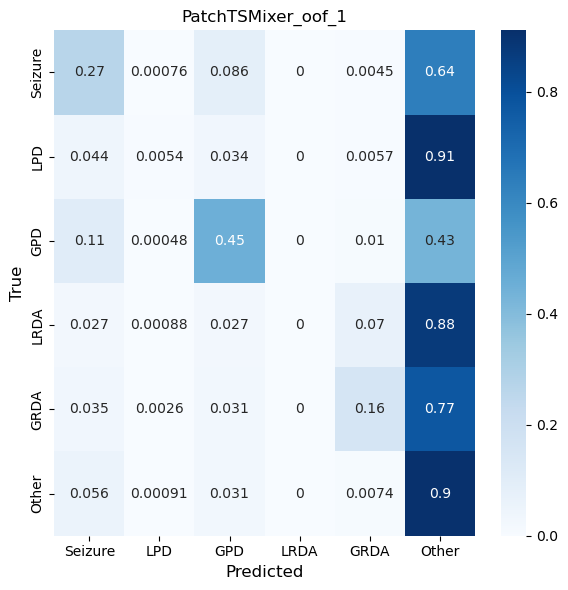

In [15]:
csv_path = f'./outputs/{ModelConfig.MODEL_NAME}_oof_1.csv'
print("CSV Path: ", csv_path)

oof_df = analyze_oof(csv_path)

print("Kaggle Score: ", calc_kaggle_score(oof_df))
print("Average KL Loss: ", oof_df["kl_loss"].mean())

display(oof_df.head())

# plot confusion matrix
cm = confusion_matrix(oof_df['target_id'], oof_df['target_pred']) # (y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=TARGET2ID.keys(), yticklabels=TARGET2ID.keys())
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(csv_path.split('/')[-1].split('.')[0], fontsize=12)
fig.tight_layout()
fig.savefig(f"./outputs/{csv_path.split('/')[-1].split('.')[0]}_CM.png")
plt.show()